# 大纲

一、获取数据

二、分析数据

三、逐个属性处理

四、新增派生属性

五、删除多余属性

六、训练

**一、获取数据**

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1、获取数据
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set(style="darkgrid")

data_store = pd.read_csv('../data/store.csv',low_memory=False)
data_test = pd.read_csv('../data/test.csv',low_memory=False)
data_train = pd.read_csv('../data/train.csv',low_memory=False)

# 增加客单价、Store分类、人流量 等商店参数
data_train_count = data_train
data_train_count['count'] = 1
data_train_count = data_train_count.groupby("Store").sum()
data_train_count["salesPerCustomer"] = data_train_count["Sales"]/data_train_count["Customers"]
data_train_count["salesPerCount"] = data_train_count["Sales"]/data_train_count["count"]
data_train_count["customerPerCount"] = data_train_count["Customers"]/data_train_count["count"]
data_train_count = data_train_count.reset_index()

# 将两个表合为一个
data_feature_all = data_test.append(data_train)
data_test["from"]=1
data_train["from"]=0
data_customer_entire=data_train.append(data_test)

# 将商店数据merge进去
data_train_count_real = data_train_count.loc[:,["Store","salesPerCustomer","salesPerCount","customerPerCount"]]
data_store_all = pd.merge(data_store,data_train_count_real,on="Store")
data_feature_all = pd.merge(data_customer_entire,data_store_all,on="Store")

**二、分析数据**

In [4]:
# 缺失值：
print("字段描述：")
print(data_feature_all.describe())

print("\r\n值为nan的比例：")
print(data_feature_all.isnull().sum()/len(data_feature_all))

字段描述：
          Customers     DayOfWeek            Id          Open         Promo  \
count  1.017209e+06  1.058297e+06  41088.000000  1.058286e+06  1.058297e+06   
mean   6.331459e+02  3.997596e+00  20544.500000  8.310466e-01  3.820704e-01   
std    4.644117e+02  1.998099e+00  11861.228267  3.747109e-01  4.858939e-01   
min    0.000000e+00  1.000000e+00      1.000000  0.000000e+00  0.000000e+00   
25%    4.050000e+02  2.000000e+00  10272.750000  1.000000e+00  0.000000e+00   
50%    6.090000e+02  4.000000e+00  20544.500000  1.000000e+00  0.000000e+00   
75%    8.370000e+02  6.000000e+00  30816.250000  1.000000e+00  1.000000e+00   
max    7.388000e+03  7.000000e+00  41088.000000  1.000000e+00  1.000000e+00   

              Sales  SchoolHoliday         Store      count          from  \
count  1.017209e+06   1.058297e+06  1.058297e+06  1017209.0  1.058297e+06   
mean   5.773819e+03   1.889290e-01  5.583315e+02        1.0  3.882464e-02   
std    3.849926e+03   3.914524e-01  3.218456e+02   

**可以看出：**

1、“Promo2SinceWeek”、“Promo2SinceYear”、”PromoInterval“、“CompetitionOpenSinceMonth”、“CompetitionOpenSinceYear”这五个字段为空的比例比较大。对于某些模型例如：knn、svm来说，缺失值影像比较大；但是对于我将要使用的xgboost来说，它在遇到有缺失值的属性时，会把缺失值分别放到左叶子节点和右叶子节点，然后再计算增益，哪个增益大就放到哪个叶子节点上。所以暂时不处理他们。

2、测试数据中，没有“customer”字段，所以进行训练的时候，不能使用该字段作为训练集属性，但是为了能够充分利用所有字段，我预计会将其进行加工处理，比如将其处理成商店的属性，如：“客单价”、“日客流量”等属性。

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


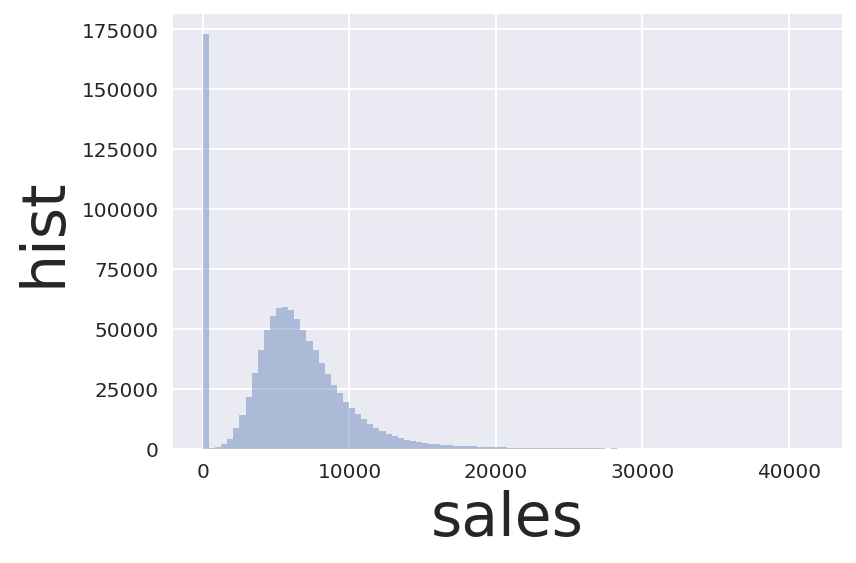

In [5]:
# 销售量分布状态
_ = sns.distplot(data_train["Sales"], hist=True, kde=False, bins=100)
plt.xlabel('sales', fontsize=30)
plt.ylabel('hist', fontsize=30)
plt.show()

从中可以看出，销售量并不是完全的正态分布。所以在后面我们会使用一定的方法来对其进行修正，使其更贴近于正态分布。

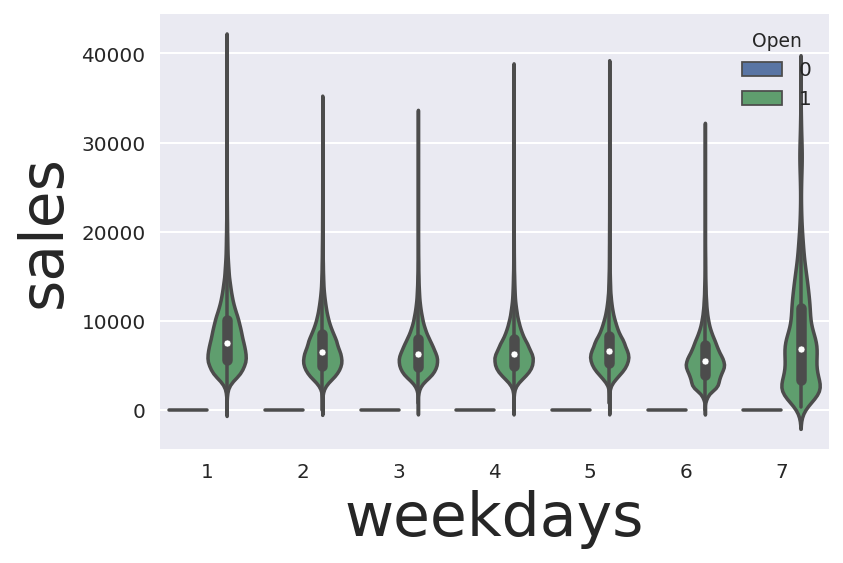

In [6]:
# 日期分布
_ = sns.violinplot(x='DayOfWeek', y='Sales', data=data_train, hue='Open')
plt.xlabel('weekdays', fontsize=30)
plt.ylabel('sales', fontsize=30)
plt.show()

从中可以看出，周六的销售量，不管从总量还是均值上来看，都是大大多于平时的，周日的销售量次之，可能是有些国家，比如德国因为由于法律原因，周日超市不开门，所以销量不如周六。

**三、逐个属性处理**

In [7]:
def insertOneHot(x,strCol,arrValues):
    for val in arrValues:
        newCol = strCol+"_"+val
        x[newCol]= 0
        x.loc[x[strCol]==val,newCol] = 1
    return x

# 处理 【Date】 字段
data_feature_all["Date"] = pd.to_datetime(data_feature_all["Date"], format="%Y-%m-%d", errors='ignore')
data_feature_all["date_year"] = data_feature_all["Date"].dt.year
data_feature_all["date_month"] = data_feature_all["Date"].dt.month
data_feature_all["date_day"] = data_feature_all["Date"].dt.day
data_feature_all['DayOfYear'] = data_feature_all["Date"].dt.dayofyear
data_feature_all['WeekOfYear'] = data_feature_all["Date"].dt.weekofyear

# 处理 【StoreType】 字段
StoreTypeKeys = ["a","b","c","d"]
insertOneHot(data_feature_all,"StoreType",StoreTypeKeys)

# 处理 【Assortment】 字段
AssortmentKeys = ["a","b","c"]
insertOneHot(data_feature_all,"Assortment",AssortmentKeys)

# 处理 【Promotnterval】 字段
PromoIntervalKeys = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec",]
for keyVal in PromoIntervalKeys:
    keyValEntire = "PromoInterval"+"_"+keyVal
    data_feature_all[keyValEntire] = data_feature_all["PromoInterval"].apply(lambda x:1 if str(x).find(keyVal)>=0 else 0)
    
# 处理 【Sales】 字段
# fig1, axes = plt.subplots(nrows=2, ncols=1)
# from_sales = data_feature_all[data_feature_all["from"]==0]["Sales"]
# pd.DataFrame(from_sales).hist(bins=100,ax=axes[0])
# sales_Q1 = np.percentile(from_sales,25)
# sales_Q3 = np.percentile(from_sales,75)
# sales_QR = sales_Q3 - sales_Q1
# data_feature_all.drop(data_feature_all[data_feature_all["from"]==0][data_feature_all["Sales"]>(sales_Q3 + 1.5*sales_QR)].index,axis=0,inplace=True)
# data_feature_all.drop(data_feature_all[data_feature_all["from"]==0][data_feature_all["Sales"]<(sales_Q1 - 1.5*sales_QR)].index,axis=0,inplace=True)
# pd.DataFrame(data_feature_all["Sales"]).hist(bins=100,ax=axes[1])

# 处理 【StateHoliday】 字段
StateHolidayKeys = ["a","b","c","0"]
insertOneHot(data_feature_all,"StateHoliday",StateHolidayKeys)

# 处理 【Open】 字段
data_feature_all = data_feature_all.fillna({"Open":1})

**四、新增派生属性**

In [8]:
#新增平均值数据
data_feature_all_train = data_feature_all[data_feature_all["from"]==0]
data_feature_all["store_sales_mean_promo"] = 0
data_feature_all["store_sales_mean_promo_no"] = 0

data_feature_all["store_sales_mean_2013"] = 0
data_feature_all["store_sales_mean_2014"] = 0
data_feature_all["store_sales_mean_2015"] = 0

data_feature_all["store_sales_mean_qur1"] = 0
data_feature_all["store_sales_mean_qur2"] = 0
data_feature_all["store_sales_mean_qur3"] = 0
data_feature_all["store_sales_mean_qur4"] = 0

for storeItem in data_train_count["Store"]:
    data_feature_all_train_store = data_feature_all_train.loc[data_feature_all_train["Store"] == storeItem,:]
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_promo'] = \
        data_feature_all_train_store[data_feature_all_train_store["Promo"]==1]["Sales"].mean()
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_promo_no'] = \
        data_feature_all_train_store[data_feature_all_train_store["Promo"]==0]["Sales"].mean()
    
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_2013'] = \
        data_feature_all_train_store[data_feature_all_train_store["date_year"]==2013]["Sales"].mean()
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_2014'] = \
        data_feature_all_train_store[data_feature_all_train_store["date_year"]==2014]["Sales"].mean()    
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_2015'] = \
        data_feature_all_train_store[data_feature_all_train_store["date_year"]==2015]["Sales"].mean()
    
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_qur1'] = \
        data_feature_all_train_store[(data_feature_all_train_store["date_month"]>=0) & (data_feature_all_train_store["date_month"]<=2)]["Sales"].mean()
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_qur2'] = \
        data_feature_all_train_store[(data_feature_all_train_store["date_month"]>=3) & (data_feature_all_train_store["date_month"]<=5)]["Sales"].mean()    
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_qur3'] = \
        data_feature_all_train_store[(data_feature_all_train_store["date_month"]>=6) & (data_feature_all_train_store["date_month"]<=8)]["Sales"].mean()
    data_feature_all.loc[data_feature_all["Store"] == storeItem,'store_sales_mean_qur4'] = \
        data_feature_all_train_store[(data_feature_all_train_store["date_month"]>=9) & (data_feature_all_train_store["date_month"]<=11)]["Sales"].mean()  

# 竞争对手开业月数
data_feature_all["CompetitionForMonths"] = (data_feature_all["date_year"] - data_feature_all["CompetitionOpenSinceYear"])*12 \
    +(data_feature_all["date_month"]-data_feature_all["CompetitionOpenSinceMonth"])

# promo持续天数
data_feature_all["Promo2LastDays"] = (data_feature_all["date_year"]-data_feature_all["Promo2SinceYear"])*365 \
    +(data_feature_all["DayOfYear"]-7*(data_feature_all["Promo2SinceWeek"]))

#距离holiday日期
holidayofyear = data_feature_all[data_feature_all["StateHoliday"]=="a"]
sortedholidays = sorted(holidayofyear["DayOfYear"].reset_index(name="DayOfHoliday")["DayOfHoliday"].unique())
for holiday in sortedholidays:
    data_feature_all["DayOfHoliday_"+str(holiday)] = holiday - data_feature_all["DayOfYear"]

#新增最近7天holiday数量
for storeItem in data_train_count["Store"]:
    data_feature_store = data_feature_all[data_feature_all["Store"]==storeItem]

    data_feature_store["index"] = data_feature_store.index
    data_feature_store.set_index("Date", inplace=True)
    data_feature_store.sort_index(inplace=True)

    #最近7天假日数
    data_feature_store["StateHoliday"] = data_feature_store["StateHoliday"].apply(lambda x: 0 if x=="0" else 1)
    data_feature_store["StateHolidayLast"] = data_feature_store["StateHoliday"].rolling(7).sum()
    data_feature_store["SchoolHolidayLast"] = data_feature_store["SchoolHoliday"].rolling(7).sum()
    data_feature_store.set_index("index", inplace=True)

    data_feature_all.loc[data_feature_all["Store"]==storeItem,'StateHolidayLast'] = \
        data_feature_store["StateHolidayLast"]
    data_feature_all.loc[data_feature_all["Store"]==storeItem,'SchoolHolidayLast'] = \
        data_feature_store["SchoolHolidayLast"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_

**五、删除多余属性**

In [9]:

# 去掉开门了且没有客户
data_feature_all_open_no_Sales = (data_feature_all[data_feature_all["Open"]==1][data_feature_all["Sales"]<=0])
data_feature_all.drop(data_feature_all_open_no_Sales.index,inplace=True)

# 去掉没开门的和销售额为0的数据
data_feature_all = data_feature_all.drop(data_feature_all[data_feature_all["from"]==0][data_feature_all["Open"] == 0].index,axis=0)
data_feature_all = data_feature_all.drop(data_feature_all[data_feature_all["from"]==0][data_feature_all["Sales"] <= 0].index,axis=0)


# 去掉customer、Store、count、Date、StoreType、Assortment、PromoIntervalPromoInterval 列
data_feature_all.drop("Customers",axis=1,inplace=True)
data_feature_all.drop("count",axis=1,inplace=True)
data_feature_all.drop("StoreType",axis=1,inplace=True)
data_feature_all.drop("Assortment",axis=1,inplace=True)
data_feature_all.drop("PromoInterval",axis=1,inplace=True)
data_feature_all.drop("StateHoliday",axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


**六、训练**

In [11]:
# 切分【测试数据】与【训练数据】
data_x_test = data_feature_all[data_feature_all["from"]==1]
data_x_test = data_x_test.sort_values(by=['Id'],axis=0,ascending=True)
data_x_test = data_x_test.reset_index()
data_x_test.drop("Id",axis=1,inplace=True)
data_x_test.drop("index",axis=1,inplace=True)
data_x_test.drop("Sales",axis=1,inplace=True)
# # 处理空Open
# data_x_test.loc[data_x_test["Open"].isnull(),"Open"] = 1

# 训练数据
data_all_Trains = data_feature_all[data_feature_all["from"]==0]
data_all_Trains.drop("Id",axis=1,inplace=True)

# 利用 xgboost 模型训练数据
import xgboost as xgb
import operator
from sklearn import cross_validation

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    y = y.get_label()
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return "rmspe",rmspe

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_bin":500,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed":1200,
          "min_child_weight" : 52 ,
          "alpha":2,
          "gamma":2
          }
num_trees = 1500

# data_all_Train, data_all_Valid = cross_validation.train_test_split(data_all_Train, test_size=0.01,random_state=40)
#切分倒数6周数据作为验证集
data_train["Date"] = pd.to_datetime(data_train["Date"], format="%Y-%m-%d", errors='ignore')
data_splite_flag = datetime.strptime('2015/06/20', '%Y/%m/%d')
data_all_Train = data_all_Trains[data_all_Trains["Date"]<data_splite_flag]
data_all_Valid = data_all_Trains[data_all_Trains["Date"]>=data_splite_flag]

#删除Date字段
data_all_Train.drop("Date",axis=1,inplace=True)
data_all_Valid.drop("Date",axis=1,inplace=True)
data_x_test.drop("Date",axis=1,inplace=True)

print(len(data_all_Train))
print(len(data_all_Valid))

data_y_Train = data_all_Train["Sales"]
data_y_Valid = data_all_Valid["Sales"]
data_all_Train.drop("Sales",axis=1,inplace=True)
data_all_Valid.drop("Sales",axis=1,inplace=True)
data_x_Valid = data_all_Valid
data_x_Train = data_all_Train
dtrain = xgb.DMatrix(data_x_Train, data_y_Train)
dvalid = xgb.DMatrix(data_x_Valid, data_y_Valid)
# dtest = xgb.DMatrix(data_x_test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees,evals=watchlist, early_stopping_rounds=50,feval=rmspe, verbose_eval=True)
# data_y_test = gbm.predict(dtest)

# # 输出
# f = open("submission_xgb_nodayin.csv", "w")
# print("\"Id\",\"Sales\"", file = f)
# for i in range(len(data_y_test)):
#     print("%d,%0.2f"%(i+1, data_y_test[i]), file = f)
# f.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

804056
40282


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	eval-rmse:7547.04	train-rmse:7544.21	eval-rmspe:0.989507	train-rmspe:0.989287
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:7473.07	train-rmse:7470.44	eval-rmspe:0.97927	train-rmspe:0.979174
[2]	eval-rmse:7402.83	train-rmse:7397.54	eval-rmspe:0.969612	train-rmspe:0.96916
[3]	eval-rmse:7332.34	train-rmse:7325.72	eval-rmspe:0.959897	train-rmspe:0.959168
[4]	eval-rmse:7262.3	train-rmse:7254.16	eval-rmspe:0.950317	train-rmspe:0.949369
[5]	eval-rmse:7194.29	train-rmse:7184.07	eval-rmspe:0.940795	train-rmspe:0.939563
[6]	eval-rmse:7123.61	train-rmse:7115.66	eval-rmspe:0.930577	train-rmspe:0.929663
[7]	eval-rmse:7054.71	train-rmse:7047.11	eval-rmspe:0.920802	train-rmspe:0.920057
[8]	eval-rmse:6987.17	train-rmse:6978.43	eval-rmspe:0.91154	train-rmspe:0.910671
[9]	eval-rmse:6920.69	train-rmse:6910.88	eval-rmspe:0.902369	train-rmspe:0.901304
[10]	eval-rmse:6856.3	train-rmse:6844

[98]	eval-rmse:3040.25	train-rmse:2991.01	eval-rmspe:0.36763	train-rmspe:0.378399
[99]	eval-rmse:3013.27	train-rmse:2964.58	eval-rmspe:0.363987	train-rmspe:0.375133
[100]	eval-rmse:2987.36	train-rmse:2938.33	eval-rmspe:0.360508	train-rmspe:0.371965
[101]	eval-rmse:2961.92	train-rmse:2911.99	eval-rmspe:0.357225	train-rmspe:0.368849
[102]	eval-rmse:2935.93	train-rmse:2886.25	eval-rmspe:0.353791	train-rmspe:0.365798
[103]	eval-rmse:2911.1	train-rmse:2861.03	eval-rmspe:0.35043	train-rmspe:0.362682
[104]	eval-rmse:2886.3	train-rmse:2835.9	eval-rmspe:0.347123	train-rmspe:0.35967
[105]	eval-rmse:2861.92	train-rmse:2810.63	eval-rmspe:0.343938	train-rmspe:0.356694
[106]	eval-rmse:2836.93	train-rmse:2786.12	eval-rmspe:0.340553	train-rmspe:0.353714
[107]	eval-rmse:2812.31	train-rmse:2761.4	eval-rmspe:0.337287	train-rmspe:0.350806
[108]	eval-rmse:2787.29	train-rmse:2737.27	eval-rmspe:0.333966	train-rmspe:0.347982
[109]	eval-rmse:2763.98	train-rmse:2713.17	eval-rmspe:0.330914	train-rmspe:0.345165
[

[197]	eval-rmse:1467.11	train-rmse:1381.85	eval-rmspe:0.170192	train-rmspe:0.213842
[198]	eval-rmse:1459.04	train-rmse:1373.36	eval-rmspe:0.169371	train-rmspe:0.213312
[199]	eval-rmse:1451.67	train-rmse:1365.13	eval-rmspe:0.168557	train-rmspe:0.212775
[200]	eval-rmse:1443.38	train-rmse:1356.47	eval-rmspe:0.167669	train-rmspe:0.212085
[201]	eval-rmse:1435.41	train-rmse:1347.95	eval-rmspe:0.166856	train-rmspe:0.211524
[202]	eval-rmse:1427.55	train-rmse:1339.57	eval-rmspe:0.16605	train-rmspe:0.210881
[203]	eval-rmse:1419.73	train-rmse:1331.61	eval-rmspe:0.165169	train-rmspe:0.210334
[204]	eval-rmse:1412.16	train-rmse:1323.71	eval-rmspe:0.16444	train-rmspe:0.209867
[205]	eval-rmse:1404.94	train-rmse:1315.68	eval-rmspe:0.163736	train-rmspe:0.209382
[206]	eval-rmse:1397.93	train-rmse:1308.26	eval-rmspe:0.163037	train-rmspe:0.208923
[207]	eval-rmse:1390.93	train-rmse:1300.47	eval-rmspe:0.162357	train-rmspe:0.208436
[208]	eval-rmse:1383.22	train-rmse:1293.09	eval-rmspe:0.161508	train-rmspe:0.2

[296]	eval-rmse:1044.97	train-rmse:898.864	eval-rmspe:0.135041	train-rmspe:0.190251
[297]	eval-rmse:1043.36	train-rmse:896.657	eval-rmspe:0.134976	train-rmspe:0.190227
[298]	eval-rmse:1041.53	train-rmse:894.395	eval-rmspe:0.134867	train-rmspe:0.190139
[299]	eval-rmse:1039.78	train-rmse:892.073	eval-rmspe:0.13487	train-rmspe:0.190124
[300]	eval-rmse:1037.78	train-rmse:889.851	eval-rmspe:0.134762	train-rmspe:0.19009
[301]	eval-rmse:1036.41	train-rmse:887.589	eval-rmspe:0.134777	train-rmspe:0.19007
[302]	eval-rmse:1034.94	train-rmse:885.439	eval-rmspe:0.134714	train-rmspe:0.189991
[303]	eval-rmse:1033.28	train-rmse:883.037	eval-rmspe:0.134678	train-rmspe:0.189899
[304]	eval-rmse:1031.32	train-rmse:880.641	eval-rmspe:0.134601	train-rmspe:0.18979
[305]	eval-rmse:1030.01	train-rmse:878.669	eval-rmspe:0.134572	train-rmspe:0.189784
[306]	eval-rmse:1028.53	train-rmse:876.626	eval-rmspe:0.134538	train-rmspe:0.189765
[307]	eval-rmse:1027.08	train-rmse:874.729	eval-rmspe:0.134527	train-rmspe:0.189

[395]	eval-rmse:951.987	train-rmse:759.541	eval-rmspe:0.133528	train-rmspe:0.1863
[396]	eval-rmse:951.315	train-rmse:758.786	eval-rmspe:0.133515	train-rmspe:0.186302
[397]	eval-rmse:950.557	train-rmse:757.884	eval-rmspe:0.133467	train-rmspe:0.186239
[398]	eval-rmse:950.071	train-rmse:757.156	eval-rmspe:0.133473	train-rmspe:0.186221
[399]	eval-rmse:949.339	train-rmse:756.336	eval-rmspe:0.133423	train-rmspe:0.186177
[400]	eval-rmse:949.172	train-rmse:755.666	eval-rmspe:0.133509	train-rmspe:0.186169
[401]	eval-rmse:949.083	train-rmse:754.837	eval-rmspe:0.133599	train-rmspe:0.186145
[402]	eval-rmse:948.751	train-rmse:753.983	eval-rmspe:0.133606	train-rmspe:0.186113
[403]	eval-rmse:948.276	train-rmse:753.174	eval-rmspe:0.133596	train-rmspe:0.185997
[404]	eval-rmse:948.259	train-rmse:752.504	eval-rmspe:0.133723	train-rmspe:0.185983
[405]	eval-rmse:947.798	train-rmse:751.912	eval-rmspe:0.133694	train-rmspe:0.185978
[406]	eval-rmse:947.497	train-rmse:751.167	eval-rmspe:0.133679	train-rmspe:0.1

[494]	eval-rmse:924.919	train-rmse:704.539	eval-rmspe:0.132863	train-rmspe:0.183156
[495]	eval-rmse:924.771	train-rmse:704.266	eval-rmspe:0.132851	train-rmspe:0.183158
[496]	eval-rmse:924.447	train-rmse:703.814	eval-rmspe:0.132809	train-rmspe:0.183132
[497]	eval-rmse:924.259	train-rmse:703.434	eval-rmspe:0.132794	train-rmspe:0.183113
[498]	eval-rmse:924.184	train-rmse:702.949	eval-rmspe:0.132805	train-rmspe:0.18307
[499]	eval-rmse:924.029	train-rmse:702.662	eval-rmspe:0.132788	train-rmspe:0.183055
[500]	eval-rmse:923.651	train-rmse:702.199	eval-rmspe:0.132766	train-rmspe:0.18303
[501]	eval-rmse:923.21	train-rmse:701.817	eval-rmspe:0.132742	train-rmspe:0.182989
[502]	eval-rmse:922.98	train-rmse:701.363	eval-rmspe:0.132719	train-rmspe:0.182953
[503]	eval-rmse:922.861	train-rmse:700.92	eval-rmspe:0.1327	train-rmspe:0.182929
[504]	eval-rmse:922.683	train-rmse:700.506	eval-rmspe:0.132678	train-rmspe:0.182898
[505]	eval-rmse:922.498	train-rmse:700.178	eval-rmspe:0.13267	train-rmspe:0.182876


[593]	eval-rmse:912.11	train-rmse:672.375	eval-rmspe:0.131647	train-rmspe:0.18031
[594]	eval-rmse:912.008	train-rmse:672.132	eval-rmspe:0.131641	train-rmspe:0.180287
[595]	eval-rmse:912.137	train-rmse:671.804	eval-rmspe:0.131657	train-rmspe:0.180267
[596]	eval-rmse:912.084	train-rmse:671.542	eval-rmspe:0.131652	train-rmspe:0.180218
[597]	eval-rmse:911.863	train-rmse:671.255	eval-rmspe:0.131629	train-rmspe:0.180188
[598]	eval-rmse:911.758	train-rmse:671.026	eval-rmspe:0.131617	train-rmspe:0.180166
[599]	eval-rmse:911.684	train-rmse:670.786	eval-rmspe:0.131592	train-rmspe:0.180141
[600]	eval-rmse:911.692	train-rmse:670.542	eval-rmspe:0.131594	train-rmspe:0.1801
[601]	eval-rmse:911.595	train-rmse:670.379	eval-rmspe:0.13158	train-rmspe:0.180098
[602]	eval-rmse:911.547	train-rmse:670.093	eval-rmspe:0.131582	train-rmspe:0.180056
[603]	eval-rmse:911.434	train-rmse:669.823	eval-rmspe:0.131558	train-rmspe:0.17996
[604]	eval-rmse:911.277	train-rmse:669.486	eval-rmspe:0.131535	train-rmspe:0.17993

[692]	eval-rmse:902.933	train-rmse:650.356	eval-rmspe:0.130226	train-rmspe:0.177702
[693]	eval-rmse:902.817	train-rmse:650.109	eval-rmspe:0.130206	train-rmspe:0.177687
[694]	eval-rmse:902.78	train-rmse:649.897	eval-rmspe:0.130205	train-rmspe:0.177657
[695]	eval-rmse:902.666	train-rmse:649.687	eval-rmspe:0.13019	train-rmspe:0.177639
[696]	eval-rmse:902.62	train-rmse:649.524	eval-rmspe:0.130186	train-rmspe:0.177611
[697]	eval-rmse:902.531	train-rmse:649.366	eval-rmspe:0.130178	train-rmspe:0.17759
[698]	eval-rmse:902.45	train-rmse:649.205	eval-rmspe:0.130164	train-rmspe:0.177573
[699]	eval-rmse:902.373	train-rmse:649.047	eval-rmspe:0.130141	train-rmspe:0.177564
[700]	eval-rmse:902.242	train-rmse:648.858	eval-rmspe:0.130125	train-rmspe:0.177502
[701]	eval-rmse:902.217	train-rmse:648.734	eval-rmspe:0.130123	train-rmspe:0.177485
[702]	eval-rmse:902.078	train-rmse:648.564	eval-rmspe:0.130094	train-rmspe:0.17744
[703]	eval-rmse:902.109	train-rmse:648.346	eval-rmspe:0.130096	train-rmspe:0.17738

[791]	eval-rmse:896.8	train-rmse:635.559	eval-rmspe:0.129344	train-rmspe:0.175684
[792]	eval-rmse:896.674	train-rmse:635.375	eval-rmspe:0.129309	train-rmspe:0.175645
[793]	eval-rmse:896.594	train-rmse:635.275	eval-rmspe:0.129303	train-rmspe:0.175641
[794]	eval-rmse:896.511	train-rmse:635.188	eval-rmspe:0.129294	train-rmspe:0.17564
[795]	eval-rmse:896.46	train-rmse:635.079	eval-rmspe:0.129289	train-rmspe:0.175629
[796]	eval-rmse:896.423	train-rmse:634.95	eval-rmspe:0.129286	train-rmspe:0.175612
[797]	eval-rmse:896.344	train-rmse:634.809	eval-rmspe:0.129272	train-rmspe:0.175599
[798]	eval-rmse:896.152	train-rmse:634.679	eval-rmspe:0.129222	train-rmspe:0.175592
[799]	eval-rmse:896.154	train-rmse:634.632	eval-rmspe:0.129222	train-rmspe:0.175584
[800]	eval-rmse:896.085	train-rmse:634.421	eval-rmspe:0.129184	train-rmspe:0.175557
[801]	eval-rmse:895.888	train-rmse:634.158	eval-rmspe:0.129152	train-rmspe:0.175487
[802]	eval-rmse:895.843	train-rmse:634.08	eval-rmspe:0.129143	train-rmspe:0.17547

[890]	eval-rmse:891.487	train-rmse:624.884	eval-rmspe:0.128206	train-rmspe:0.174198
[891]	eval-rmse:891.464	train-rmse:624.778	eval-rmspe:0.128199	train-rmspe:0.174183
[892]	eval-rmse:891.422	train-rmse:624.689	eval-rmspe:0.128191	train-rmspe:0.174169
[893]	eval-rmse:891.406	train-rmse:624.648	eval-rmspe:0.128193	train-rmspe:0.17417
[894]	eval-rmse:891.364	train-rmse:624.527	eval-rmspe:0.12818	train-rmspe:0.174138
[895]	eval-rmse:891.372	train-rmse:624.494	eval-rmspe:0.12818	train-rmspe:0.174134
[896]	eval-rmse:891.37	train-rmse:624.439	eval-rmspe:0.128181	train-rmspe:0.174127
[897]	eval-rmse:891.363	train-rmse:624.398	eval-rmspe:0.128178	train-rmspe:0.174113
[898]	eval-rmse:891.324	train-rmse:624.287	eval-rmspe:0.128172	train-rmspe:0.174103
[899]	eval-rmse:891.299	train-rmse:624.207	eval-rmspe:0.128172	train-rmspe:0.174096
[900]	eval-rmse:891.294	train-rmse:624.145	eval-rmspe:0.128163	train-rmspe:0.17409
[901]	eval-rmse:891.222	train-rmse:623.963	eval-rmspe:0.128119	train-rmspe:0.1740

[988]	eval-rmse:888.334	train-rmse:616.618	eval-rmspe:0.127491	train-rmspe:0.173184
[989]	eval-rmse:888.324	train-rmse:616.59	eval-rmspe:0.12749	train-rmspe:0.173184
[990]	eval-rmse:888.145	train-rmse:616.421	eval-rmspe:0.127459	train-rmspe:0.173158
[991]	eval-rmse:888.151	train-rmse:616.352	eval-rmspe:0.127458	train-rmspe:0.173146
[992]	eval-rmse:888.053	train-rmse:616.282	eval-rmspe:0.127451	train-rmspe:0.173134
[993]	eval-rmse:887.996	train-rmse:616.182	eval-rmspe:0.127434	train-rmspe:0.173122
[994]	eval-rmse:887.978	train-rmse:616.132	eval-rmspe:0.127432	train-rmspe:0.173113
[995]	eval-rmse:887.97	train-rmse:616.077	eval-rmspe:0.127428	train-rmspe:0.173108
[996]	eval-rmse:887.958	train-rmse:616.03	eval-rmspe:0.127426	train-rmspe:0.173098
[997]	eval-rmse:887.899	train-rmse:615.909	eval-rmspe:0.127414	train-rmspe:0.173086
[998]	eval-rmse:887.834	train-rmse:615.867	eval-rmspe:0.127363	train-rmspe:0.173078
[999]	eval-rmse:887.826	train-rmse:615.805	eval-rmspe:0.12736	train-rmspe:0.1730

[1086]	eval-rmse:886.096	train-rmse:609.287	eval-rmspe:0.126768	train-rmspe:0.172273
[1087]	eval-rmse:886.074	train-rmse:609.245	eval-rmspe:0.126765	train-rmspe:0.172269
[1088]	eval-rmse:886.036	train-rmse:609.213	eval-rmspe:0.126763	train-rmspe:0.172265
[1089]	eval-rmse:886.016	train-rmse:609.158	eval-rmspe:0.12676	train-rmspe:0.172256
[1090]	eval-rmse:886.004	train-rmse:609.121	eval-rmspe:0.126758	train-rmspe:0.172255
[1091]	eval-rmse:885.973	train-rmse:609.064	eval-rmspe:0.12675	train-rmspe:0.172253
[1092]	eval-rmse:885.955	train-rmse:609.02	eval-rmspe:0.126743	train-rmspe:0.172247
[1093]	eval-rmse:885.938	train-rmse:608.991	eval-rmspe:0.126739	train-rmspe:0.172243
[1094]	eval-rmse:885.875	train-rmse:608.89	eval-rmspe:0.126726	train-rmspe:0.172208
[1095]	eval-rmse:885.828	train-rmse:608.784	eval-rmspe:0.126719	train-rmspe:0.172192
[1096]	eval-rmse:885.839	train-rmse:608.757	eval-rmspe:0.126721	train-rmspe:0.172186
[1097]	eval-rmse:885.813	train-rmse:608.638	eval-rmspe:0.126701	train

[1183]	eval-rmse:884.177	train-rmse:603.542	eval-rmspe:0.126222	train-rmspe:0.171559
[1184]	eval-rmse:884.127	train-rmse:603.412	eval-rmspe:0.12621	train-rmspe:0.171543
[1185]	eval-rmse:884.129	train-rmse:603.357	eval-rmspe:0.126211	train-rmspe:0.171537
[1186]	eval-rmse:884.071	train-rmse:603.281	eval-rmspe:0.1262	train-rmspe:0.171528
[1187]	eval-rmse:884.063	train-rmse:603.255	eval-rmspe:0.126196	train-rmspe:0.171524
[1188]	eval-rmse:884.049	train-rmse:603.236	eval-rmspe:0.126194	train-rmspe:0.171522
[1189]	eval-rmse:884.046	train-rmse:603.196	eval-rmspe:0.126193	train-rmspe:0.171518
[1190]	eval-rmse:884.054	train-rmse:603.14	eval-rmspe:0.126197	train-rmspe:0.171518
[1191]	eval-rmse:883.988	train-rmse:603.064	eval-rmspe:0.126171	train-rmspe:0.171487
[1192]	eval-rmse:883.971	train-rmse:603.033	eval-rmspe:0.126165	train-rmspe:0.171481
[1193]	eval-rmse:883.924	train-rmse:603.002	eval-rmspe:0.126161	train-rmspe:0.171476
[1194]	eval-rmse:883.915	train-rmse:602.943	eval-rmspe:0.126162	train

[1280]	eval-rmse:882.986	train-rmse:598.346	eval-rmspe:0.125757	train-rmspe:0.170916
[1281]	eval-rmse:882.991	train-rmse:598.327	eval-rmspe:0.12576	train-rmspe:0.170914
[1282]	eval-rmse:882.937	train-rmse:598.217	eval-rmspe:0.125746	train-rmspe:0.170932
[1283]	eval-rmse:882.939	train-rmse:598.139	eval-rmspe:0.125728	train-rmspe:0.17095
[1284]	eval-rmse:882.919	train-rmse:598.092	eval-rmspe:0.125726	train-rmspe:0.170944
[1285]	eval-rmse:882.926	train-rmse:598.045	eval-rmspe:0.125723	train-rmspe:0.170941
[1286]	eval-rmse:882.93	train-rmse:597.998	eval-rmspe:0.125723	train-rmspe:0.170934
[1287]	eval-rmse:882.926	train-rmse:597.969	eval-rmspe:0.125722	train-rmspe:0.17093
[1288]	eval-rmse:882.914	train-rmse:597.943	eval-rmspe:0.125718	train-rmspe:0.170923
[1289]	eval-rmse:882.905	train-rmse:597.902	eval-rmspe:0.12572	train-rmspe:0.170914
[1290]	eval-rmse:882.903	train-rmse:597.863	eval-rmspe:0.125719	train-rmspe:0.170919
[1291]	eval-rmse:882.897	train-rmse:597.836	eval-rmspe:0.12572	train-r

[1377]	eval-rmse:881.497	train-rmse:593.966	eval-rmspe:0.125439	train-rmspe:0.170421
[1378]	eval-rmse:881.463	train-rmse:593.879	eval-rmspe:0.125438	train-rmspe:0.170414
[1379]	eval-rmse:881.452	train-rmse:593.77	eval-rmspe:0.12543	train-rmspe:0.170397
[1380]	eval-rmse:881.438	train-rmse:593.752	eval-rmspe:0.125426	train-rmspe:0.170394
[1381]	eval-rmse:881.424	train-rmse:593.714	eval-rmspe:0.125425	train-rmspe:0.170396
[1382]	eval-rmse:881.348	train-rmse:593.607	eval-rmspe:0.125413	train-rmspe:0.170362
[1383]	eval-rmse:881.343	train-rmse:593.592	eval-rmspe:0.125412	train-rmspe:0.170361
[1384]	eval-rmse:881.331	train-rmse:593.568	eval-rmspe:0.125411	train-rmspe:0.170359
[1385]	eval-rmse:881.312	train-rmse:593.542	eval-rmspe:0.125404	train-rmspe:0.170348
[1386]	eval-rmse:881.278	train-rmse:593.474	eval-rmspe:0.125401	train-rmspe:0.170335
[1387]	eval-rmse:881.276	train-rmse:593.442	eval-rmspe:0.125401	train-rmspe:0.17033
[1388]	eval-rmse:881.249	train-rmse:593.39	eval-rmspe:0.125398	train

[1474]	eval-rmse:880.185	train-rmse:589.622	eval-rmspe:0.124999	train-rmspe:0.169961
[1475]	eval-rmse:880.179	train-rmse:589.605	eval-rmspe:0.124998	train-rmspe:0.169957
[1476]	eval-rmse:880.179	train-rmse:589.584	eval-rmspe:0.124999	train-rmspe:0.169955
[1477]	eval-rmse:880.069	train-rmse:589.517	eval-rmspe:0.124985	train-rmspe:0.169947
[1478]	eval-rmse:880.061	train-rmse:589.467	eval-rmspe:0.124985	train-rmspe:0.169939
[1479]	eval-rmse:880.022	train-rmse:589.351	eval-rmspe:0.124977	train-rmspe:0.169961
[1480]	eval-rmse:880.009	train-rmse:589.315	eval-rmspe:0.124975	train-rmspe:0.169958
[1481]	eval-rmse:879.996	train-rmse:589.261	eval-rmspe:0.124971	train-rmspe:0.169952
[1482]	eval-rmse:879.979	train-rmse:589.244	eval-rmspe:0.124967	train-rmspe:0.16995
[1483]	eval-rmse:879.972	train-rmse:589.214	eval-rmspe:0.124966	train-rmspe:0.169947
[1484]	eval-rmse:880.107	train-rmse:589.122	eval-rmspe:0.124976	train-rmspe:0.169928
[1485]	eval-rmse:880.01	train-rmse:589.078	eval-rmspe:0.124952	tra

**七、预测**

In [16]:
num_trees = 20000

data_feature_all.drop("Date",axis=1,inplace=True)
data_all_Trains = data_feature_all[data_feature_all["from"]==0]
data_all_Trains.drop("Id",axis=1,inplace=True)

data_y_Train = data_all_Trains["Sales"]
data_all_Trains.drop("Sales",axis=1,inplace=True)
data_x_Train = data_all_Trains
dtrain = xgb.DMatrix(data_x_Train, data_y_Train)
dtest = xgb.DMatrix(data_x_test)

gbm = xgb.train(params, dtrain, num_trees, early_stopping_rounds=50,evals=watchlist,feval=rmspe, verbose_eval=True)
data_y_test = gbm.predict(dtest)

# 输出
f = open("solution_withouterrorhandle.csv", "w")
print("\"Id\",\"Sales\"", file = f)
for i in range(len(data_y_test)):
    print("%d,%0.2f"%(i+1, data_y_test[i]), file = f)
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[0]	eval-rmse:7543.96	train-rmse:7542.52	eval-rmspe:0.989718	train-rmspe:0.98958
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:7471.28	train-rmse:7468.74	eval-rmspe:0.979763	train-rmspe:0.979455
[2]	eval-rmse:7399.97	train-rmse:7397.47	eval-rmspe:0.96945	train-rmspe:0.969114
[3]	eval-rmse:7328.03	train-rmse:7325.66	eval-rmspe:0.959407	train-rmspe:0.959129
[4]	eval-rmse:7257.59	train-rmse:7254.55	eval-rmspe:0.949613	train-rmspe:0.949243
[5]	eval-rmse:7186.85	train-rmse:7184.63	eval-rmspe:0.93967	train-rmspe:0.939431
[6]	eval-rmse:7117.98	train-rmse:7114.48	eval-rmspe:0.93024	train-rmspe:0.929831
[7]	eval-rmse:7049.36	train-rmse:7046.01	eval-rmspe:0.920583	train-rmspe:0.920212
[8]	eval-rmse:6981.76	train-rmse:6977.27	eval-rmspe:0.91135	train-rmspe:0.91082
[9]	eval-rmse:6914.89	train-rmse:6909.21	eval-rmspe:0.902238	train-rmspe:0.901527
[10]	eval-rmse:6848.26	train-rmse:6841.

[98]	eval-rmse:3031.25	train-rmse:2986.19	eval-rmspe:0.369949	train-rmspe:0.378557
[99]	eval-rmse:3004.67	train-rmse:2959.28	eval-rmspe:0.366448	train-rmspe:0.375337
[100]	eval-rmse:2978.32	train-rmse:2932.68	eval-rmspe:0.362985	train-rmspe:0.372172
[101]	eval-rmse:2952.5	train-rmse:2906.72	eval-rmspe:0.35952	train-rmspe:0.369029
[102]	eval-rmse:2926.95	train-rmse:2881.67	eval-rmspe:0.356012	train-rmspe:0.365905
[103]	eval-rmse:2902.23	train-rmse:2856.59	eval-rmspe:0.352581	train-rmspe:0.362775
[104]	eval-rmse:2877.14	train-rmse:2832.26	eval-rmspe:0.348993	train-rmspe:0.359714
[105]	eval-rmse:2852.43	train-rmse:2807.39	eval-rmspe:0.345693	train-rmspe:0.356765
[106]	eval-rmse:2827.97	train-rmse:2782.45	eval-rmspe:0.342488	train-rmspe:0.353871
[107]	eval-rmse:2803.23	train-rmse:2757.7	eval-rmspe:0.339241	train-rmspe:0.35099
[108]	eval-rmse:2779.23	train-rmse:2733.31	eval-rmspe:0.336106	train-rmspe:0.348165
[109]	eval-rmse:2755.44	train-rmse:2709.5	eval-rmspe:0.332958	train-rmspe:0.345377

[197]	eval-rmse:1427.12	train-rmse:1380.82	eval-rmspe:0.166193	train-rmspe:0.214035
[198]	eval-rmse:1418.57	train-rmse:1371.99	eval-rmspe:0.165264	train-rmspe:0.213436
[199]	eval-rmse:1410.1	train-rmse:1363.39	eval-rmspe:0.164346	train-rmspe:0.21291
[200]	eval-rmse:1402.24	train-rmse:1354.95	eval-rmspe:0.163517	train-rmspe:0.212383
[201]	eval-rmse:1393.78	train-rmse:1347.11	eval-rmspe:0.162533	train-rmspe:0.211916
[202]	eval-rmse:1385.99	train-rmse:1339.5	eval-rmspe:0.161709	train-rmspe:0.211491
[203]	eval-rmse:1378.05	train-rmse:1331.65	eval-rmspe:0.160823	train-rmspe:0.211012
[204]	eval-rmse:1370.03	train-rmse:1323.5	eval-rmspe:0.159938	train-rmspe:0.210426
[205]	eval-rmse:1362.56	train-rmse:1315.57	eval-rmspe:0.159152	train-rmspe:0.209837
[206]	eval-rmse:1354.38	train-rmse:1307.89	eval-rmspe:0.158276	train-rmspe:0.209408
[207]	eval-rmse:1346.6	train-rmse:1299.99	eval-rmspe:0.15745	train-rmspe:0.208833
[208]	eval-rmse:1339.17	train-rmse:1292.57	eval-rmspe:0.156699	train-rmspe:0.20842

[296]	eval-rmse:942.068	train-rmse:897.423	eval-rmspe:0.119812	train-rmspe:0.190922
[297]	eval-rmse:939.722	train-rmse:895.005	eval-rmspe:0.119642	train-rmspe:0.190843
[298]	eval-rmse:937.36	train-rmse:892.601	eval-rmspe:0.119484	train-rmspe:0.190772
[299]	eval-rmse:935.022	train-rmse:890.336	eval-rmspe:0.119299	train-rmspe:0.190704
[300]	eval-rmse:932.764	train-rmse:887.983	eval-rmspe:0.119149	train-rmspe:0.190635
[301]	eval-rmse:930.573	train-rmse:885.715	eval-rmspe:0.119006	train-rmspe:0.190578
[302]	eval-rmse:928.628	train-rmse:883.654	eval-rmspe:0.118906	train-rmspe:0.190579
[303]	eval-rmse:926.453	train-rmse:881.36	eval-rmspe:0.118751	train-rmspe:0.190429
[304]	eval-rmse:924.252	train-rmse:879.087	eval-rmspe:0.11858	train-rmspe:0.190351
[305]	eval-rmse:922.235	train-rmse:876.923	eval-rmspe:0.118433	train-rmspe:0.190278
[306]	eval-rmse:920.123	train-rmse:874.712	eval-rmspe:0.1183	train-rmspe:0.190201
[307]	eval-rmse:918.236	train-rmse:872.792	eval-rmspe:0.118206	train-rmspe:0.1901

[395]	eval-rmse:802.454	train-rmse:760.224	eval-rmspe:0.11039	train-rmspe:0.187035
[396]	eval-rmse:801.54	train-rmse:759.337	eval-rmspe:0.110302	train-rmspe:0.187005
[397]	eval-rmse:800.62	train-rmse:758.462	eval-rmspe:0.110226	train-rmspe:0.186932
[398]	eval-rmse:799.62	train-rmse:757.621	eval-rmspe:0.110135	train-rmspe:0.186892
[399]	eval-rmse:798.975	train-rmse:756.999	eval-rmspe:0.110112	train-rmspe:0.186891
[400]	eval-rmse:798.195	train-rmse:756.233	eval-rmspe:0.110076	train-rmspe:0.186884
[401]	eval-rmse:797.269	train-rmse:755.378	eval-rmspe:0.110006	train-rmspe:0.186796
[402]	eval-rmse:796.691	train-rmse:754.788	eval-rmspe:0.109973	train-rmspe:0.1868
[403]	eval-rmse:796.218	train-rmse:754.237	eval-rmspe:0.109956	train-rmspe:0.18681
[404]	eval-rmse:795.453	train-rmse:753.489	eval-rmspe:0.1099	train-rmspe:0.18678
[405]	eval-rmse:794.723	train-rmse:752.648	eval-rmspe:0.109863	train-rmspe:0.186739
[406]	eval-rmse:794.069	train-rmse:752.063	eval-rmspe:0.109817	train-rmspe:0.18673
[40

[494]	eval-rmse:739.525	train-rmse:705.36	eval-rmspe:0.10509	train-rmspe:0.184214
[495]	eval-rmse:738.707	train-rmse:704.728	eval-rmspe:0.104994	train-rmspe:0.18417
[496]	eval-rmse:738.244	train-rmse:704.217	eval-rmspe:0.104928	train-rmspe:0.184101
[497]	eval-rmse:737.619	train-rmse:703.8	eval-rmspe:0.104863	train-rmspe:0.184074
[498]	eval-rmse:737.146	train-rmse:703.321	eval-rmspe:0.104826	train-rmspe:0.184046
[499]	eval-rmse:736.712	train-rmse:702.965	eval-rmspe:0.1048	train-rmspe:0.183975
[500]	eval-rmse:736.33	train-rmse:702.609	eval-rmspe:0.104765	train-rmspe:0.183956
[501]	eval-rmse:735.625	train-rmse:702.094	eval-rmspe:0.104695	train-rmspe:0.183884
[502]	eval-rmse:735.112	train-rmse:701.682	eval-rmspe:0.104643	train-rmspe:0.183825
[503]	eval-rmse:734.572	train-rmse:701.346	eval-rmspe:0.104607	train-rmspe:0.183801
[504]	eval-rmse:734.172	train-rmse:700.976	eval-rmspe:0.104571	train-rmspe:0.183779
[505]	eval-rmse:733.794	train-rmse:700.583	eval-rmspe:0.104527	train-rmspe:0.183736


[592]	eval-rmse:701.275	train-rmse:672.402	eval-rmspe:0.100859	train-rmspe:0.180506
[593]	eval-rmse:701.03	train-rmse:672.138	eval-rmspe:0.100835	train-rmspe:0.180475
[594]	eval-rmse:700.743	train-rmse:671.846	eval-rmspe:0.100803	train-rmspe:0.180449
[595]	eval-rmse:700.496	train-rmse:671.634	eval-rmspe:0.100781	train-rmspe:0.180435
[596]	eval-rmse:700.157	train-rmse:671.383	eval-rmspe:0.100747	train-rmspe:0.180397
[597]	eval-rmse:699.892	train-rmse:671.133	eval-rmspe:0.100725	train-rmspe:0.180379
[598]	eval-rmse:699.444	train-rmse:670.741	eval-rmspe:0.100675	train-rmspe:0.180285
[599]	eval-rmse:699.141	train-rmse:670.463	eval-rmspe:0.100645	train-rmspe:0.180265
[600]	eval-rmse:698.705	train-rmse:670.196	eval-rmspe:0.100587	train-rmspe:0.180249
[601]	eval-rmse:698.345	train-rmse:669.91	eval-rmspe:0.100555	train-rmspe:0.180238
[602]	eval-rmse:698.03	train-rmse:669.718	eval-rmspe:0.100515	train-rmspe:0.180228
[603]	eval-rmse:697.63	train-rmse:669.546	eval-rmspe:0.100457	train-rmspe:0.180

[691]	eval-rmse:675.536	train-rmse:650.745	eval-rmspe:0.097814	train-rmspe:0.178016
[692]	eval-rmse:675.448	train-rmse:650.624	eval-rmspe:0.097799	train-rmspe:0.178008
[693]	eval-rmse:675.194	train-rmse:650.457	eval-rmspe:0.097767	train-rmspe:0.177988
[694]	eval-rmse:674.921	train-rmse:650.271	eval-rmspe:0.097742	train-rmspe:0.177983
[695]	eval-rmse:674.65	train-rmse:650.114	eval-rmspe:0.09771	train-rmspe:0.177971
[696]	eval-rmse:674.331	train-rmse:649.935	eval-rmspe:0.097663	train-rmspe:0.177946
[697]	eval-rmse:674.01	train-rmse:649.708	eval-rmspe:0.097634	train-rmspe:0.177919
[698]	eval-rmse:673.896	train-rmse:649.594	eval-rmspe:0.097622	train-rmspe:0.177908
[699]	eval-rmse:673.667	train-rmse:649.428	eval-rmspe:0.097608	train-rmspe:0.177901
[700]	eval-rmse:673.471	train-rmse:649.233	eval-rmspe:0.097589	train-rmspe:0.177905
[701]	eval-rmse:673.188	train-rmse:649.011	eval-rmspe:0.097563	train-rmspe:0.177903
[702]	eval-rmse:673.025	train-rmse:648.861	eval-rmspe:0.09754	train-rmspe:0.177

[790]	eval-rmse:657.644	train-rmse:636.11	eval-rmspe:0.095675	train-rmspe:0.176233
[791]	eval-rmse:657.52	train-rmse:635.993	eval-rmspe:0.09565	train-rmspe:0.176212
[792]	eval-rmse:657.445	train-rmse:635.928	eval-rmspe:0.095635	train-rmspe:0.176198
[793]	eval-rmse:657.328	train-rmse:635.823	eval-rmspe:0.095617	train-rmspe:0.176201
[794]	eval-rmse:657.19	train-rmse:635.722	eval-rmspe:0.095604	train-rmspe:0.176193
[795]	eval-rmse:657.066	train-rmse:635.579	eval-rmspe:0.095588	train-rmspe:0.176165
[796]	eval-rmse:656.849	train-rmse:635.45	eval-rmspe:0.095564	train-rmspe:0.176151
[797]	eval-rmse:656.742	train-rmse:635.328	eval-rmspe:0.095553	train-rmspe:0.17609
[798]	eval-rmse:656.55	train-rmse:635.166	eval-rmspe:0.095531	train-rmspe:0.176083
[799]	eval-rmse:656.396	train-rmse:635.045	eval-rmspe:0.095519	train-rmspe:0.176057
[800]	eval-rmse:656.241	train-rmse:634.944	eval-rmspe:0.095498	train-rmspe:0.176042
[801]	eval-rmse:656.186	train-rmse:634.872	eval-rmspe:0.09549	train-rmspe:0.176031


[889]	eval-rmse:644.722	train-rmse:625.433	eval-rmspe:0.094008	train-rmspe:0.174755
[890]	eval-rmse:644.547	train-rmse:625.329	eval-rmspe:0.093983	train-rmspe:0.174741
[891]	eval-rmse:644.469	train-rmse:625.282	eval-rmspe:0.093971	train-rmspe:0.174733
[892]	eval-rmse:644.345	train-rmse:625.165	eval-rmspe:0.093949	train-rmspe:0.174716
[893]	eval-rmse:644.256	train-rmse:625.079	eval-rmspe:0.093944	train-rmspe:0.174706
[894]	eval-rmse:644.14	train-rmse:624.976	eval-rmspe:0.093929	train-rmspe:0.174672
[895]	eval-rmse:644.061	train-rmse:624.855	eval-rmspe:0.093916	train-rmspe:0.174654
[896]	eval-rmse:643.99	train-rmse:624.774	eval-rmspe:0.093908	train-rmspe:0.17464
[897]	eval-rmse:643.929	train-rmse:624.737	eval-rmspe:0.093904	train-rmspe:0.17464
[898]	eval-rmse:643.902	train-rmse:624.672	eval-rmspe:0.093899	train-rmspe:0.174627
[899]	eval-rmse:643.825	train-rmse:624.595	eval-rmspe:0.093892	train-rmspe:0.174616
[900]	eval-rmse:643.56	train-rmse:624.472	eval-rmspe:0.093868	train-rmspe:0.1745

[987]	eval-rmse:635.043	train-rmse:617.5	eval-rmspe:0.092795	train-rmspe:0.173531
[988]	eval-rmse:635.019	train-rmse:617.449	eval-rmspe:0.092793	train-rmspe:0.173523
[989]	eval-rmse:634.957	train-rmse:617.401	eval-rmspe:0.092786	train-rmspe:0.173516
[990]	eval-rmse:634.857	train-rmse:617.305	eval-rmspe:0.092777	train-rmspe:0.173522
[991]	eval-rmse:634.792	train-rmse:617.262	eval-rmspe:0.092768	train-rmspe:0.173516
[992]	eval-rmse:634.742	train-rmse:617.192	eval-rmspe:0.092765	train-rmspe:0.173506
[993]	eval-rmse:634.696	train-rmse:617.136	eval-rmspe:0.09276	train-rmspe:0.1735
[994]	eval-rmse:634.656	train-rmse:617.066	eval-rmspe:0.092755	train-rmspe:0.173492
[995]	eval-rmse:634.626	train-rmse:617.006	eval-rmspe:0.092752	train-rmspe:0.173482
[996]	eval-rmse:634.341	train-rmse:616.895	eval-rmspe:0.092708	train-rmspe:0.173468
[997]	eval-rmse:634.324	train-rmse:616.858	eval-rmspe:0.092705	train-rmspe:0.173464
[998]	eval-rmse:634.089	train-rmse:616.739	eval-rmspe:0.09267	train-rmspe:0.17345

[1085]	eval-rmse:628.336	train-rmse:611.543	eval-rmspe:0.091929	train-rmspe:0.172644
[1086]	eval-rmse:628.309	train-rmse:611.493	eval-rmspe:0.091925	train-rmspe:0.172638
[1087]	eval-rmse:628.294	train-rmse:611.47	eval-rmspe:0.091923	train-rmspe:0.172631
[1088]	eval-rmse:628.251	train-rmse:611.408	eval-rmspe:0.091913	train-rmspe:0.172614
[1089]	eval-rmse:628.231	train-rmse:611.361	eval-rmspe:0.09191	train-rmspe:0.172609
[1090]	eval-rmse:628.178	train-rmse:611.323	eval-rmspe:0.0919	train-rmspe:0.172603
[1091]	eval-rmse:628.092	train-rmse:611.278	eval-rmspe:0.091888	train-rmspe:0.172599
[1092]	eval-rmse:628.056	train-rmse:611.24	eval-rmspe:0.091887	train-rmspe:0.172594
[1093]	eval-rmse:627.984	train-rmse:611.213	eval-rmspe:0.091877	train-rmspe:0.172592
[1094]	eval-rmse:627.957	train-rmse:611.197	eval-rmspe:0.091872	train-rmspe:0.172591
[1095]	eval-rmse:627.828	train-rmse:611.101	eval-rmspe:0.091854	train-rmspe:0.172541
[1096]	eval-rmse:627.81	train-rmse:611.04	eval-rmspe:0.091851	train-rm

[1182]	eval-rmse:621.49	train-rmse:605.57	eval-rmspe:0.091009	train-rmspe:0.171779
[1183]	eval-rmse:621.453	train-rmse:605.526	eval-rmspe:0.091004	train-rmspe:0.171774
[1184]	eval-rmse:621.452	train-rmse:605.511	eval-rmspe:0.091004	train-rmspe:0.171773
[1185]	eval-rmse:621.381	train-rmse:605.414	eval-rmspe:0.090983	train-rmspe:0.171748
[1186]	eval-rmse:621.307	train-rmse:605.362	eval-rmspe:0.090972	train-rmspe:0.171737
[1187]	eval-rmse:621.253	train-rmse:605.312	eval-rmspe:0.090965	train-rmspe:0.171732
[1188]	eval-rmse:621.176	train-rmse:605.266	eval-rmspe:0.09096	train-rmspe:0.171731
[1189]	eval-rmse:620.983	train-rmse:605.145	eval-rmspe:0.090935	train-rmspe:0.171723
[1190]	eval-rmse:620.926	train-rmse:605.11	eval-rmspe:0.090928	train-rmspe:0.171717
[1191]	eval-rmse:620.83	train-rmse:605.064	eval-rmspe:0.090918	train-rmspe:0.171712
[1192]	eval-rmse:620.793	train-rmse:605.016	eval-rmspe:0.090911	train-rmspe:0.171683
[1193]	eval-rmse:620.77	train-rmse:604.944	eval-rmspe:0.090907	train-r

[1280]	eval-rmse:616.258	train-rmse:600.509	eval-rmspe:0.090278	train-rmspe:0.171111
[1281]	eval-rmse:616.208	train-rmse:600.446	eval-rmspe:0.090274	train-rmspe:0.171112
[1282]	eval-rmse:616.125	train-rmse:600.381	eval-rmspe:0.090263	train-rmspe:0.171106
[1283]	eval-rmse:616.095	train-rmse:600.35	eval-rmspe:0.090255	train-rmspe:0.1711
[1284]	eval-rmse:616.077	train-rmse:600.263	eval-rmspe:0.090256	train-rmspe:0.171079
[1285]	eval-rmse:616.068	train-rmse:600.226	eval-rmspe:0.090255	train-rmspe:0.171072
[1286]	eval-rmse:615.929	train-rmse:600.122	eval-rmspe:0.090239	train-rmspe:0.171065
[1287]	eval-rmse:615.8	train-rmse:599.989	eval-rmspe:0.090227	train-rmspe:0.171034
[1288]	eval-rmse:615.757	train-rmse:599.94	eval-rmspe:0.09022	train-rmspe:0.171026
[1289]	eval-rmse:615.684	train-rmse:599.883	eval-rmspe:0.090214	train-rmspe:0.171019
[1290]	eval-rmse:615.672	train-rmse:599.853	eval-rmspe:0.090212	train-rmspe:0.171014
[1291]	eval-rmse:615.657	train-rmse:599.83	eval-rmspe:0.090209	train-rms

[1377]	eval-rmse:611.068	train-rmse:595.324	eval-rmspe:0.089628	train-rmspe:0.170385
[1378]	eval-rmse:611.005	train-rmse:595.287	eval-rmspe:0.089615	train-rmspe:0.170379
[1379]	eval-rmse:611.002	train-rmse:595.256	eval-rmspe:0.089614	train-rmspe:0.170376
[1380]	eval-rmse:610.94	train-rmse:595.221	eval-rmspe:0.089605	train-rmspe:0.170373
[1381]	eval-rmse:610.872	train-rmse:595.145	eval-rmspe:0.089595	train-rmspe:0.170356
[1382]	eval-rmse:610.818	train-rmse:595.096	eval-rmspe:0.089583	train-rmspe:0.170346
[1383]	eval-rmse:610.773	train-rmse:595.04	eval-rmspe:0.089576	train-rmspe:0.170335
[1384]	eval-rmse:610.764	train-rmse:594.987	eval-rmspe:0.089576	train-rmspe:0.170322
[1385]	eval-rmse:610.743	train-rmse:594.954	eval-rmspe:0.089571	train-rmspe:0.170318
[1386]	eval-rmse:610.726	train-rmse:594.936	eval-rmspe:0.089568	train-rmspe:0.170313
[1387]	eval-rmse:610.704	train-rmse:594.872	eval-rmspe:0.089562	train-rmspe:0.170299
[1388]	eval-rmse:610.65	train-rmse:594.852	eval-rmspe:0.089559	trai

[1474]	eval-rmse:606.196	train-rmse:590.967	eval-rmspe:0.089002	train-rmspe:0.169791
[1475]	eval-rmse:606.183	train-rmse:590.935	eval-rmspe:0.088998	train-rmspe:0.169787
[1476]	eval-rmse:606.029	train-rmse:590.767	eval-rmspe:0.088973	train-rmspe:0.169803
[1477]	eval-rmse:606.008	train-rmse:590.748	eval-rmspe:0.08897	train-rmspe:0.169802
[1478]	eval-rmse:605.981	train-rmse:590.715	eval-rmspe:0.08897	train-rmspe:0.169796
[1479]	eval-rmse:605.924	train-rmse:590.668	eval-rmspe:0.088966	train-rmspe:0.169791
[1480]	eval-rmse:605.866	train-rmse:590.613	eval-rmspe:0.08896	train-rmspe:0.169786
[1481]	eval-rmse:605.854	train-rmse:590.573	eval-rmspe:0.088959	train-rmspe:0.169774
[1482]	eval-rmse:605.821	train-rmse:590.529	eval-rmspe:0.088954	train-rmspe:0.169771
[1483]	eval-rmse:605.777	train-rmse:590.514	eval-rmspe:0.08895	train-rmspe:0.169768
[1484]	eval-rmse:605.705	train-rmse:590.461	eval-rmspe:0.088946	train-rmspe:0.169744
[1485]	eval-rmse:605.644	train-rmse:590.393	eval-rmspe:0.088947	train

[1571]	eval-rmse:601.423	train-rmse:586.496	eval-rmspe:0.088435	train-rmspe:0.16927
[1572]	eval-rmse:601.419	train-rmse:586.478	eval-rmspe:0.088435	train-rmspe:0.169268
[1573]	eval-rmse:601.349	train-rmse:586.383	eval-rmspe:0.088418	train-rmspe:0.169246
[1574]	eval-rmse:601.325	train-rmse:586.361	eval-rmspe:0.088415	train-rmspe:0.169245
[1575]	eval-rmse:601.318	train-rmse:586.346	eval-rmspe:0.088414	train-rmspe:0.169242
[1576]	eval-rmse:601.303	train-rmse:586.325	eval-rmspe:0.08841	train-rmspe:0.169243
[1577]	eval-rmse:601.301	train-rmse:586.319	eval-rmspe:0.088409	train-rmspe:0.169242
[1578]	eval-rmse:601.294	train-rmse:586.303	eval-rmspe:0.088409	train-rmspe:0.16924
[1579]	eval-rmse:601.257	train-rmse:586.256	eval-rmspe:0.088401	train-rmspe:0.169237
[1580]	eval-rmse:601.179	train-rmse:586.208	eval-rmspe:0.088389	train-rmspe:0.169239
[1581]	eval-rmse:601.117	train-rmse:586.176	eval-rmspe:0.088387	train-rmspe:0.169237
[1582]	eval-rmse:601.11	train-rmse:586.139	eval-rmspe:0.088385	train

[1669]	eval-rmse:597.55	train-rmse:583.021	eval-rmspe:0.087924	train-rmspe:0.168845
[1670]	eval-rmse:597.539	train-rmse:583.012	eval-rmspe:0.087922	train-rmspe:0.168844
[1671]	eval-rmse:597.466	train-rmse:582.935	eval-rmspe:0.087915	train-rmspe:0.168836
[1672]	eval-rmse:597.453	train-rmse:582.916	eval-rmspe:0.087914	train-rmspe:0.168834
[1673]	eval-rmse:597.419	train-rmse:582.904	eval-rmspe:0.087909	train-rmspe:0.168833
[1674]	eval-rmse:597.377	train-rmse:582.856	eval-rmspe:0.087903	train-rmspe:0.168826
[1675]	eval-rmse:597.369	train-rmse:582.837	eval-rmspe:0.087904	train-rmspe:0.168824
[1676]	eval-rmse:597.355	train-rmse:582.816	eval-rmspe:0.087898	train-rmspe:0.168821
[1677]	eval-rmse:597.352	train-rmse:582.8	eval-rmspe:0.087898	train-rmspe:0.16882
[1678]	eval-rmse:597.31	train-rmse:582.765	eval-rmspe:0.08789	train-rmspe:0.168817
[1679]	eval-rmse:597.291	train-rmse:582.748	eval-rmspe:0.087889	train-rmspe:0.168814
[1680]	eval-rmse:597.288	train-rmse:582.738	eval-rmspe:0.087889	train-r

[1766]	eval-rmse:594.495	train-rmse:579.542	eval-rmspe:0.08753	train-rmspe:0.168399
[1767]	eval-rmse:594.48	train-rmse:579.504	eval-rmspe:0.087525	train-rmspe:0.168392
[1768]	eval-rmse:594.472	train-rmse:579.481	eval-rmspe:0.087525	train-rmspe:0.16839
[1769]	eval-rmse:594.437	train-rmse:579.436	eval-rmspe:0.087522	train-rmspe:0.168386
[1770]	eval-rmse:594.397	train-rmse:579.435	eval-rmspe:0.087517	train-rmspe:0.168386
[1771]	eval-rmse:594.382	train-rmse:579.395	eval-rmspe:0.087517	train-rmspe:0.168379
[1772]	eval-rmse:594.362	train-rmse:579.351	eval-rmspe:0.08751	train-rmspe:0.168369
[1773]	eval-rmse:594.346	train-rmse:579.333	eval-rmspe:0.087509	train-rmspe:0.168367
[1774]	eval-rmse:594.293	train-rmse:579.262	eval-rmspe:0.087503	train-rmspe:0.168363
[1775]	eval-rmse:594.266	train-rmse:579.239	eval-rmspe:0.087502	train-rmspe:0.168358
[1776]	eval-rmse:594.236	train-rmse:579.197	eval-rmspe:0.087499	train-rmspe:0.168349
[1777]	eval-rmse:594.184	train-rmse:579.175	eval-rmspe:0.087493	train

[1863]	eval-rmse:590.78	train-rmse:575.844	eval-rmspe:0.087072	train-rmspe:0.167905
[1864]	eval-rmse:590.743	train-rmse:575.784	eval-rmspe:0.087066	train-rmspe:0.1679
[1865]	eval-rmse:590.733	train-rmse:575.774	eval-rmspe:0.087065	train-rmspe:0.167898
[1866]	eval-rmse:590.732	train-rmse:575.756	eval-rmspe:0.087065	train-rmspe:0.167895
[1867]	eval-rmse:590.714	train-rmse:575.736	eval-rmspe:0.087063	train-rmspe:0.167894
[1868]	eval-rmse:590.683	train-rmse:575.727	eval-rmspe:0.08706	train-rmspe:0.167893
[1869]	eval-rmse:590.591	train-rmse:575.655	eval-rmspe:0.087049	train-rmspe:0.167921
[1870]	eval-rmse:590.527	train-rmse:575.573	eval-rmspe:0.08704	train-rmspe:0.167909
[1871]	eval-rmse:590.46	train-rmse:575.508	eval-rmspe:0.087034	train-rmspe:0.167902
[1872]	eval-rmse:590.44	train-rmse:575.488	eval-rmspe:0.087033	train-rmspe:0.1679
[1873]	eval-rmse:590.378	train-rmse:575.397	eval-rmspe:0.087022	train-rmspe:0.167884
[1874]	eval-rmse:590.358	train-rmse:575.379	eval-rmspe:0.08702	train-rmspe

[1960]	eval-rmse:586.998	train-rmse:572.435	eval-rmspe:0.086587	train-rmspe:0.167627
[1961]	eval-rmse:586.944	train-rmse:572.408	eval-rmspe:0.086582	train-rmspe:0.167625
[1962]	eval-rmse:586.915	train-rmse:572.369	eval-rmspe:0.086577	train-rmspe:0.167621
[1963]	eval-rmse:586.867	train-rmse:572.332	eval-rmspe:0.086568	train-rmspe:0.167617
[1964]	eval-rmse:586.853	train-rmse:572.31	eval-rmspe:0.086564	train-rmspe:0.167613
[1965]	eval-rmse:586.796	train-rmse:572.272	eval-rmspe:0.086559	train-rmspe:0.167621
[1966]	eval-rmse:586.786	train-rmse:572.255	eval-rmspe:0.086557	train-rmspe:0.167619
[1967]	eval-rmse:586.697	train-rmse:572.21	eval-rmspe:0.086549	train-rmspe:0.167612
[1968]	eval-rmse:586.687	train-rmse:572.187	eval-rmspe:0.086549	train-rmspe:0.167608
[1969]	eval-rmse:586.687	train-rmse:572.166	eval-rmspe:0.086549	train-rmspe:0.167605
[1970]	eval-rmse:586.635	train-rmse:572.099	eval-rmspe:0.086538	train-rmspe:0.167599
[1971]	eval-rmse:586.603	train-rmse:572.088	eval-rmspe:0.086534	tra

[2057]	eval-rmse:583.531	train-rmse:569.072	eval-rmspe:0.086128	train-rmspe:0.167201
[2058]	eval-rmse:583.453	train-rmse:569.015	eval-rmspe:0.086121	train-rmspe:0.167182
[2059]	eval-rmse:583.441	train-rmse:568.966	eval-rmspe:0.08612	train-rmspe:0.167177
[2060]	eval-rmse:583.383	train-rmse:568.919	eval-rmspe:0.08612	train-rmspe:0.167179
[2061]	eval-rmse:583.376	train-rmse:568.901	eval-rmspe:0.086118	train-rmspe:0.167178
[2062]	eval-rmse:583.312	train-rmse:568.853	eval-rmspe:0.086114	train-rmspe:0.167185
[2063]	eval-rmse:583.24	train-rmse:568.824	eval-rmspe:0.086105	train-rmspe:0.167185
[2064]	eval-rmse:583.23	train-rmse:568.794	eval-rmspe:0.086104	train-rmspe:0.167171
[2065]	eval-rmse:583.215	train-rmse:568.785	eval-rmspe:0.086102	train-rmspe:0.16717
[2066]	eval-rmse:583.172	train-rmse:568.772	eval-rmspe:0.086097	train-rmspe:0.16717
[2067]	eval-rmse:583.149	train-rmse:568.754	eval-rmspe:0.086096	train-rmspe:0.167169
[2068]	eval-rmse:583.075	train-rmse:568.705	eval-rmspe:0.086089	train-r

[2154]	eval-rmse:579.984	train-rmse:565.927	eval-rmspe:0.085697	train-rmspe:0.166956
[2155]	eval-rmse:579.969	train-rmse:565.909	eval-rmspe:0.085695	train-rmspe:0.166955
[2156]	eval-rmse:579.946	train-rmse:565.893	eval-rmspe:0.085692	train-rmspe:0.166954
[2157]	eval-rmse:579.917	train-rmse:565.855	eval-rmspe:0.085692	train-rmspe:0.16695
[2158]	eval-rmse:579.897	train-rmse:565.823	eval-rmspe:0.085689	train-rmspe:0.166948
[2159]	eval-rmse:579.838	train-rmse:565.743	eval-rmspe:0.085681	train-rmspe:0.166939
[2160]	eval-rmse:579.838	train-rmse:565.713	eval-rmspe:0.085681	train-rmspe:0.166935
[2161]	eval-rmse:579.812	train-rmse:565.673	eval-rmspe:0.085676	train-rmspe:0.166934
[2162]	eval-rmse:579.8	train-rmse:565.646	eval-rmspe:0.085674	train-rmspe:0.166932
[2163]	eval-rmse:579.78	train-rmse:565.613	eval-rmspe:0.085671	train-rmspe:0.166932
[2164]	eval-rmse:579.752	train-rmse:565.598	eval-rmspe:0.085669	train-rmspe:0.166932
[2165]	eval-rmse:579.654	train-rmse:565.551	eval-rmspe:0.085657	train

[2251]	eval-rmse:576.853	train-rmse:562.875	eval-rmspe:0.085298	train-rmspe:0.166713
[2252]	eval-rmse:576.838	train-rmse:562.866	eval-rmspe:0.085297	train-rmspe:0.166712
[2253]	eval-rmse:576.817	train-rmse:562.843	eval-rmspe:0.085294	train-rmspe:0.166716
[2254]	eval-rmse:576.816	train-rmse:562.83	eval-rmspe:0.085294	train-rmspe:0.166715
[2255]	eval-rmse:576.812	train-rmse:562.819	eval-rmspe:0.085294	train-rmspe:0.166713
[2256]	eval-rmse:576.812	train-rmse:562.814	eval-rmspe:0.085293	train-rmspe:0.166712
[2257]	eval-rmse:576.803	train-rmse:562.799	eval-rmspe:0.085293	train-rmspe:0.166711
[2258]	eval-rmse:576.77	train-rmse:562.753	eval-rmspe:0.08529	train-rmspe:0.16671
[2259]	eval-rmse:576.756	train-rmse:562.73	eval-rmspe:0.08529	train-rmspe:0.166706
[2260]	eval-rmse:576.69	train-rmse:562.687	eval-rmspe:0.085284	train-rmspe:0.166702
[2261]	eval-rmse:576.676	train-rmse:562.666	eval-rmspe:0.085283	train-rmspe:0.1667
[2262]	eval-rmse:576.633	train-rmse:562.626	eval-rmspe:0.085278	train-rmsp

[2348]	eval-rmse:573.832	train-rmse:560.184	eval-rmspe:0.084955	train-rmspe:0.166327
[2349]	eval-rmse:573.833	train-rmse:560.179	eval-rmspe:0.084955	train-rmspe:0.166325
[2350]	eval-rmse:573.795	train-rmse:560.144	eval-rmspe:0.084953	train-rmspe:0.166314
[2351]	eval-rmse:573.791	train-rmse:560.131	eval-rmspe:0.084953	train-rmspe:0.166313
[2352]	eval-rmse:573.781	train-rmse:560.117	eval-rmspe:0.084953	train-rmspe:0.166312
[2353]	eval-rmse:573.772	train-rmse:560.088	eval-rmspe:0.084951	train-rmspe:0.166309
[2354]	eval-rmse:573.756	train-rmse:560.055	eval-rmspe:0.084949	train-rmspe:0.166307
[2355]	eval-rmse:573.748	train-rmse:560.036	eval-rmspe:0.084948	train-rmspe:0.166303
[2356]	eval-rmse:573.746	train-rmse:560.005	eval-rmspe:0.084947	train-rmspe:0.1663
[2357]	eval-rmse:573.732	train-rmse:559.978	eval-rmspe:0.084947	train-rmspe:0.166296
[2358]	eval-rmse:573.732	train-rmse:559.955	eval-rmspe:0.084947	train-rmspe:0.166291
[2359]	eval-rmse:573.68	train-rmse:559.901	eval-rmspe:0.084939	trai

[2445]	eval-rmse:570.413	train-rmse:557.078	eval-rmspe:0.084573	train-rmspe:0.165927
[2446]	eval-rmse:570.384	train-rmse:557.064	eval-rmspe:0.084571	train-rmspe:0.165925
[2447]	eval-rmse:570.313	train-rmse:557.03	eval-rmspe:0.084565	train-rmspe:0.165926
[2448]	eval-rmse:570.313	train-rmse:557.01	eval-rmspe:0.084565	train-rmspe:0.165922
[2449]	eval-rmse:570.248	train-rmse:556.934	eval-rmspe:0.084556	train-rmspe:0.165909
[2450]	eval-rmse:570.174	train-rmse:556.894	eval-rmspe:0.084547	train-rmspe:0.165906
[2451]	eval-rmse:570.165	train-rmse:556.886	eval-rmspe:0.084544	train-rmspe:0.165905
[2452]	eval-rmse:570.164	train-rmse:556.873	eval-rmspe:0.084544	train-rmspe:0.165904
[2453]	eval-rmse:570.156	train-rmse:556.855	eval-rmspe:0.084543	train-rmspe:0.165902
[2454]	eval-rmse:570.105	train-rmse:556.802	eval-rmspe:0.084534	train-rmspe:0.165889
[2455]	eval-rmse:570.093	train-rmse:556.79	eval-rmspe:0.084531	train-rmspe:0.165888
[2456]	eval-rmse:570.093	train-rmse:556.756	eval-rmspe:0.084531	trai

[2542]	eval-rmse:567.613	train-rmse:554.426	eval-rmspe:0.084238	train-rmspe:0.165705
[2543]	eval-rmse:567.584	train-rmse:554.403	eval-rmspe:0.084236	train-rmspe:0.165703
[2544]	eval-rmse:567.572	train-rmse:554.373	eval-rmspe:0.084234	train-rmspe:0.165702
[2545]	eval-rmse:567.54	train-rmse:554.369	eval-rmspe:0.084231	train-rmspe:0.165702
[2546]	eval-rmse:567.524	train-rmse:554.358	eval-rmspe:0.08423	train-rmspe:0.165701
[2547]	eval-rmse:567.477	train-rmse:554.333	eval-rmspe:0.084227	train-rmspe:0.1657
[2548]	eval-rmse:567.462	train-rmse:554.313	eval-rmspe:0.084227	train-rmspe:0.165699
[2549]	eval-rmse:567.457	train-rmse:554.307	eval-rmspe:0.084227	train-rmspe:0.165697
[2550]	eval-rmse:567.454	train-rmse:554.304	eval-rmspe:0.084226	train-rmspe:0.165696
[2551]	eval-rmse:567.432	train-rmse:554.296	eval-rmspe:0.084221	train-rmspe:0.165695
[2552]	eval-rmse:567.415	train-rmse:554.267	eval-rmspe:0.084218	train-rmspe:0.165688
[2553]	eval-rmse:567.382	train-rmse:554.255	eval-rmspe:0.084213	train

[2639]	eval-rmse:564.884	train-rmse:551.995	eval-rmspe:0.083926	train-rmspe:0.165429
[2640]	eval-rmse:564.862	train-rmse:551.969	eval-rmspe:0.083925	train-rmspe:0.165428
[2641]	eval-rmse:564.84	train-rmse:551.946	eval-rmspe:0.083924	train-rmspe:0.165426
[2642]	eval-rmse:564.837	train-rmse:551.939	eval-rmspe:0.083923	train-rmspe:0.165419
[2643]	eval-rmse:564.795	train-rmse:551.919	eval-rmspe:0.083919	train-rmspe:0.165417
[2644]	eval-rmse:564.748	train-rmse:551.863	eval-rmspe:0.083913	train-rmspe:0.165414
[2645]	eval-rmse:564.686	train-rmse:551.802	eval-rmspe:0.083907	train-rmspe:0.165438
[2646]	eval-rmse:564.638	train-rmse:551.765	eval-rmspe:0.083902	train-rmspe:0.165436
[2647]	eval-rmse:564.629	train-rmse:551.756	eval-rmspe:0.083903	train-rmspe:0.165435
[2648]	eval-rmse:564.586	train-rmse:551.749	eval-rmspe:0.083902	train-rmspe:0.165434
[2649]	eval-rmse:564.527	train-rmse:551.705	eval-rmspe:0.083894	train-rmspe:0.16543
[2650]	eval-rmse:564.498	train-rmse:551.678	eval-rmspe:0.083892	tra

[2736]	eval-rmse:561.492	train-rmse:549.164	eval-rmspe:0.083538	train-rmspe:0.165178
[2737]	eval-rmse:561.49	train-rmse:549.152	eval-rmspe:0.083537	train-rmspe:0.165175
[2738]	eval-rmse:561.458	train-rmse:549.146	eval-rmspe:0.083532	train-rmspe:0.165175
[2739]	eval-rmse:561.458	train-rmse:549.12	eval-rmspe:0.083532	train-rmspe:0.165172
[2740]	eval-rmse:561.402	train-rmse:549.06	eval-rmspe:0.083524	train-rmspe:0.165166
[2741]	eval-rmse:561.399	train-rmse:549.046	eval-rmspe:0.083523	train-rmspe:0.165164
[2742]	eval-rmse:561.305	train-rmse:548.985	eval-rmspe:0.083515	train-rmspe:0.165149
[2743]	eval-rmse:561.272	train-rmse:548.939	eval-rmspe:0.083511	train-rmspe:0.165143
[2744]	eval-rmse:561.267	train-rmse:548.921	eval-rmspe:0.08351	train-rmspe:0.165143
[2745]	eval-rmse:561.239	train-rmse:548.89	eval-rmspe:0.083506	train-rmspe:0.165138
[2746]	eval-rmse:561.202	train-rmse:548.863	eval-rmspe:0.083504	train-rmspe:0.165131
[2747]	eval-rmse:561.194	train-rmse:548.849	eval-rmspe:0.083502	train-

[2834]	eval-rmse:558.6	train-rmse:546.678	eval-rmspe:0.083228	train-rmspe:0.164854
[2835]	eval-rmse:558.48	train-rmse:546.616	eval-rmspe:0.083207	train-rmspe:0.164855
[2836]	eval-rmse:558.473	train-rmse:546.608	eval-rmspe:0.083206	train-rmspe:0.164854
[2837]	eval-rmse:558.469	train-rmse:546.594	eval-rmspe:0.083205	train-rmspe:0.164851
[2838]	eval-rmse:558.402	train-rmse:546.568	eval-rmspe:0.083198	train-rmspe:0.16485
[2839]	eval-rmse:558.367	train-rmse:546.54	eval-rmspe:0.083193	train-rmspe:0.164849
[2840]	eval-rmse:558.343	train-rmse:546.515	eval-rmspe:0.08319	train-rmspe:0.164845
[2841]	eval-rmse:558.322	train-rmse:546.507	eval-rmspe:0.083188	train-rmspe:0.164844
[2842]	eval-rmse:558.293	train-rmse:546.471	eval-rmspe:0.083187	train-rmspe:0.164842
[2843]	eval-rmse:558.285	train-rmse:546.462	eval-rmspe:0.083187	train-rmspe:0.164841
[2844]	eval-rmse:558.281	train-rmse:546.457	eval-rmspe:0.083186	train-rmspe:0.164841
[2845]	eval-rmse:558.235	train-rmse:546.399	eval-rmspe:0.083177	train-r

[2931]	eval-rmse:555.817	train-rmse:544.308	eval-rmspe:0.082922	train-rmspe:0.164629
[2932]	eval-rmse:555.811	train-rmse:544.294	eval-rmspe:0.082921	train-rmspe:0.164628
[2933]	eval-rmse:555.791	train-rmse:544.258	eval-rmspe:0.08292	train-rmspe:0.164622
[2934]	eval-rmse:555.75	train-rmse:544.218	eval-rmspe:0.082914	train-rmspe:0.16461
[2935]	eval-rmse:555.688	train-rmse:544.201	eval-rmspe:0.082907	train-rmspe:0.164608
[2936]	eval-rmse:555.67	train-rmse:544.176	eval-rmspe:0.082902	train-rmspe:0.164599
[2937]	eval-rmse:555.66	train-rmse:544.163	eval-rmspe:0.082901	train-rmspe:0.164598
[2938]	eval-rmse:555.652	train-rmse:544.134	eval-rmspe:0.082898	train-rmspe:0.164594
[2939]	eval-rmse:555.65	train-rmse:544.131	eval-rmspe:0.082897	train-rmspe:0.164594
[2940]	eval-rmse:555.614	train-rmse:544.104	eval-rmspe:0.082892	train-rmspe:0.164592
[2941]	eval-rmse:555.607	train-rmse:544.061	eval-rmspe:0.082891	train-rmspe:0.164586
[2942]	eval-rmse:555.588	train-rmse:544.048	eval-rmspe:0.082889	train-r

[3028]	eval-rmse:553.435	train-rmse:542.19	eval-rmspe:0.08264	train-rmspe:0.164383
[3029]	eval-rmse:553.411	train-rmse:542.171	eval-rmspe:0.082637	train-rmspe:0.16438
[3030]	eval-rmse:553.383	train-rmse:542.136	eval-rmspe:0.082634	train-rmspe:0.164374
[3031]	eval-rmse:553.378	train-rmse:542.131	eval-rmspe:0.082634	train-rmspe:0.164373
[3032]	eval-rmse:553.358	train-rmse:542.114	eval-rmspe:0.082632	train-rmspe:0.164374
[3033]	eval-rmse:553.338	train-rmse:542.103	eval-rmspe:0.082631	train-rmspe:0.164375
[3034]	eval-rmse:553.327	train-rmse:542.087	eval-rmspe:0.08263	train-rmspe:0.164374
[3035]	eval-rmse:553.314	train-rmse:542.07	eval-rmspe:0.082628	train-rmspe:0.164373
[3036]	eval-rmse:553.281	train-rmse:542.052	eval-rmspe:0.082626	train-rmspe:0.164372
[3037]	eval-rmse:553.257	train-rmse:542.02	eval-rmspe:0.082623	train-rmspe:0.16437
[3038]	eval-rmse:553.192	train-rmse:541.941	eval-rmspe:0.08261	train-rmspe:0.164372
[3039]	eval-rmse:553.099	train-rmse:541.905	eval-rmspe:0.082601	train-rms

[3125]	eval-rmse:551.099	train-rmse:540.024	eval-rmspe:0.082368	train-rmspe:0.164141
[3126]	eval-rmse:551.087	train-rmse:540.014	eval-rmspe:0.082366	train-rmspe:0.16414
[3127]	eval-rmse:551.078	train-rmse:540.002	eval-rmspe:0.082365	train-rmspe:0.164139
[3128]	eval-rmse:551.053	train-rmse:539.982	eval-rmspe:0.082362	train-rmspe:0.164137
[3129]	eval-rmse:551.041	train-rmse:539.966	eval-rmspe:0.082361	train-rmspe:0.164136
[3130]	eval-rmse:551.017	train-rmse:539.939	eval-rmspe:0.082357	train-rmspe:0.164134
[3131]	eval-rmse:551.009	train-rmse:539.904	eval-rmspe:0.082356	train-rmspe:0.164114
[3132]	eval-rmse:550.943	train-rmse:539.86	eval-rmspe:0.082352	train-rmspe:0.164108
[3133]	eval-rmse:550.943	train-rmse:539.847	eval-rmspe:0.082352	train-rmspe:0.164107
[3134]	eval-rmse:550.914	train-rmse:539.818	eval-rmspe:0.082349	train-rmspe:0.164104
[3135]	eval-rmse:550.891	train-rmse:539.795	eval-rmspe:0.082348	train-rmspe:0.16408
[3136]	eval-rmse:550.872	train-rmse:539.774	eval-rmspe:0.082345	trai

[3222]	eval-rmse:548.498	train-rmse:537.79	eval-rmspe:0.082082	train-rmspe:0.163917
[3223]	eval-rmse:548.494	train-rmse:537.77	eval-rmspe:0.082082	train-rmspe:0.163914
[3224]	eval-rmse:548.44	train-rmse:537.736	eval-rmspe:0.082076	train-rmspe:0.163912
[3225]	eval-rmse:548.412	train-rmse:537.708	eval-rmspe:0.082074	train-rmspe:0.163909
[3226]	eval-rmse:548.406	train-rmse:537.703	eval-rmspe:0.082073	train-rmspe:0.163908
[3227]	eval-rmse:548.367	train-rmse:537.678	eval-rmspe:0.082069	train-rmspe:0.163897
[3228]	eval-rmse:548.353	train-rmse:537.667	eval-rmspe:0.082068	train-rmspe:0.163897
[3229]	eval-rmse:548.329	train-rmse:537.662	eval-rmspe:0.082065	train-rmspe:0.163897
[3230]	eval-rmse:548.303	train-rmse:537.643	eval-rmspe:0.082062	train-rmspe:0.163896
[3231]	eval-rmse:548.267	train-rmse:537.627	eval-rmspe:0.082057	train-rmspe:0.163895
[3232]	eval-rmse:548.248	train-rmse:537.622	eval-rmspe:0.082059	train-rmspe:0.163895
[3233]	eval-rmse:548.242	train-rmse:537.591	eval-rmspe:0.082057	trai

[3319]	eval-rmse:546.15	train-rmse:535.861	eval-rmspe:0.081835	train-rmspe:0.163631
[3320]	eval-rmse:546.149	train-rmse:535.856	eval-rmspe:0.081834	train-rmspe:0.163631
[3321]	eval-rmse:546.138	train-rmse:535.826	eval-rmspe:0.081833	train-rmspe:0.16363
[3322]	eval-rmse:546.054	train-rmse:535.774	eval-rmspe:0.081823	train-rmspe:0.163627
[3323]	eval-rmse:546.04	train-rmse:535.75	eval-rmspe:0.081821	train-rmspe:0.163622
[3324]	eval-rmse:546.034	train-rmse:535.734	eval-rmspe:0.081821	train-rmspe:0.16362
[3325]	eval-rmse:546.029	train-rmse:535.726	eval-rmspe:0.08182	train-rmspe:0.163619
[3326]	eval-rmse:545.994	train-rmse:535.714	eval-rmspe:0.081817	train-rmspe:0.163618
[3327]	eval-rmse:545.963	train-rmse:535.671	eval-rmspe:0.081813	train-rmspe:0.163616
[3328]	eval-rmse:545.944	train-rmse:535.654	eval-rmspe:0.081814	train-rmspe:0.163614
[3329]	eval-rmse:545.915	train-rmse:535.619	eval-rmspe:0.081811	train-rmspe:0.16361
[3330]	eval-rmse:545.895	train-rmse:535.587	eval-rmspe:0.081809	train-rm

[3416]	eval-rmse:543.565	train-rmse:533.633	eval-rmspe:0.081572	train-rmspe:0.163431
[3417]	eval-rmse:543.56	train-rmse:533.622	eval-rmspe:0.081571	train-rmspe:0.16343
[3418]	eval-rmse:543.524	train-rmse:533.596	eval-rmspe:0.081567	train-rmspe:0.163427
[3419]	eval-rmse:543.524	train-rmse:533.585	eval-rmspe:0.081567	train-rmspe:0.163425
[3420]	eval-rmse:543.523	train-rmse:533.576	eval-rmspe:0.081567	train-rmspe:0.163425
[3421]	eval-rmse:543.519	train-rmse:533.563	eval-rmspe:0.081567	train-rmspe:0.163422
[3422]	eval-rmse:543.497	train-rmse:533.528	eval-rmspe:0.081562	train-rmspe:0.163453
[3423]	eval-rmse:543.487	train-rmse:533.513	eval-rmspe:0.081561	train-rmspe:0.16345
[3424]	eval-rmse:543.472	train-rmse:533.488	eval-rmspe:0.081559	train-rmspe:0.163454
[3425]	eval-rmse:543.44	train-rmse:533.474	eval-rmspe:0.081557	train-rmspe:0.163453
[3426]	eval-rmse:543.392	train-rmse:533.448	eval-rmspe:0.081554	train-rmspe:0.163449
[3427]	eval-rmse:543.367	train-rmse:533.424	eval-rmspe:0.081555	train

[3513]	eval-rmse:541.187	train-rmse:531.548	eval-rmspe:0.081336	train-rmspe:0.163139
[3514]	eval-rmse:541.081	train-rmse:531.478	eval-rmspe:0.081319	train-rmspe:0.163132
[3515]	eval-rmse:541.08	train-rmse:531.464	eval-rmspe:0.081319	train-rmspe:0.163131
[3516]	eval-rmse:541.077	train-rmse:531.444	eval-rmspe:0.081318	train-rmspe:0.163125
[3517]	eval-rmse:541.066	train-rmse:531.433	eval-rmspe:0.081314	train-rmspe:0.163123
[3518]	eval-rmse:541.036	train-rmse:531.407	eval-rmspe:0.081311	train-rmspe:0.163117
[3519]	eval-rmse:541.018	train-rmse:531.386	eval-rmspe:0.081307	train-rmspe:0.163115
[3520]	eval-rmse:541.009	train-rmse:531.379	eval-rmspe:0.081308	train-rmspe:0.163115
[3521]	eval-rmse:540.968	train-rmse:531.334	eval-rmspe:0.081301	train-rmspe:0.163133
[3522]	eval-rmse:540.901	train-rmse:531.284	eval-rmspe:0.081295	train-rmspe:0.163125
[3523]	eval-rmse:540.828	train-rmse:531.239	eval-rmspe:0.081288	train-rmspe:0.16312
[3524]	eval-rmse:540.821	train-rmse:531.212	eval-rmspe:0.081287	tra

[3610]	eval-rmse:538.871	train-rmse:529.698	eval-rmspe:0.081079	train-rmspe:0.16291
[3611]	eval-rmse:538.841	train-rmse:529.673	eval-rmspe:0.081076	train-rmspe:0.162909
[3612]	eval-rmse:538.809	train-rmse:529.655	eval-rmspe:0.081072	train-rmspe:0.162908
[3613]	eval-rmse:538.739	train-rmse:529.619	eval-rmspe:0.081063	train-rmspe:0.162905
[3614]	eval-rmse:538.722	train-rmse:529.612	eval-rmspe:0.081061	train-rmspe:0.162904
[3615]	eval-rmse:538.701	train-rmse:529.585	eval-rmspe:0.081058	train-rmspe:0.162902
[3616]	eval-rmse:538.694	train-rmse:529.579	eval-rmspe:0.081058	train-rmspe:0.162902
[3617]	eval-rmse:538.681	train-rmse:529.559	eval-rmspe:0.081057	train-rmspe:0.1629
[3618]	eval-rmse:538.642	train-rmse:529.555	eval-rmspe:0.081054	train-rmspe:0.162901
[3619]	eval-rmse:538.636	train-rmse:529.549	eval-rmspe:0.081053	train-rmspe:0.1629
[3620]	eval-rmse:538.621	train-rmse:529.539	eval-rmspe:0.081051	train-rmspe:0.1629
[3621]	eval-rmse:538.596	train-rmse:529.516	eval-rmspe:0.081049	train-rm

[3707]	eval-rmse:536.822	train-rmse:527.904	eval-rmspe:0.080842	train-rmspe:0.162737
[3708]	eval-rmse:536.822	train-rmse:527.902	eval-rmspe:0.080842	train-rmspe:0.162736
[3709]	eval-rmse:536.821	train-rmse:527.876	eval-rmspe:0.080842	train-rmspe:0.162733
[3710]	eval-rmse:536.792	train-rmse:527.869	eval-rmspe:0.08084	train-rmspe:0.162733
[3711]	eval-rmse:536.756	train-rmse:527.853	eval-rmspe:0.080834	train-rmspe:0.162733
[3712]	eval-rmse:536.752	train-rmse:527.832	eval-rmspe:0.080832	train-rmspe:0.162733
[3713]	eval-rmse:536.737	train-rmse:527.818	eval-rmspe:0.080831	train-rmspe:0.162721
[3714]	eval-rmse:536.7	train-rmse:527.777	eval-rmspe:0.080827	train-rmspe:0.162708
[3715]	eval-rmse:536.682	train-rmse:527.76	eval-rmspe:0.080823	train-rmspe:0.162696
[3716]	eval-rmse:536.651	train-rmse:527.739	eval-rmspe:0.080818	train-rmspe:0.162693
[3717]	eval-rmse:536.633	train-rmse:527.712	eval-rmspe:0.080814	train-rmspe:0.162691
[3718]	eval-rmse:536.622	train-rmse:527.697	eval-rmspe:0.080812	train

[3804]	eval-rmse:534.76	train-rmse:526.096	eval-rmspe:0.080596	train-rmspe:0.162507
[3805]	eval-rmse:534.757	train-rmse:526.064	eval-rmspe:0.080596	train-rmspe:0.162505
[3806]	eval-rmse:534.753	train-rmse:526.06	eval-rmspe:0.080595	train-rmspe:0.162502
[3807]	eval-rmse:534.717	train-rmse:526.043	eval-rmspe:0.080592	train-rmspe:0.162502
[3808]	eval-rmse:534.714	train-rmse:526.027	eval-rmspe:0.080591	train-rmspe:0.162501
[3809]	eval-rmse:534.698	train-rmse:526.011	eval-rmspe:0.080589	train-rmspe:0.1625
[3810]	eval-rmse:534.662	train-rmse:525.988	eval-rmspe:0.080584	train-rmspe:0.162498
[3811]	eval-rmse:534.632	train-rmse:525.958	eval-rmspe:0.080581	train-rmspe:0.162495
[3812]	eval-rmse:534.621	train-rmse:525.949	eval-rmspe:0.08058	train-rmspe:0.162495
[3813]	eval-rmse:534.605	train-rmse:525.919	eval-rmspe:0.080578	train-rmspe:0.162486
[3814]	eval-rmse:534.551	train-rmse:525.874	eval-rmspe:0.080571	train-rmspe:0.162481
[3815]	eval-rmse:534.546	train-rmse:525.85	eval-rmspe:0.080571	train-r

[3901]	eval-rmse:532.611	train-rmse:524.282	eval-rmspe:0.080335	train-rmspe:0.162307
[3902]	eval-rmse:532.584	train-rmse:524.263	eval-rmspe:0.080333	train-rmspe:0.162306
[3903]	eval-rmse:532.565	train-rmse:524.25	eval-rmspe:0.080332	train-rmspe:0.162305
[3904]	eval-rmse:532.552	train-rmse:524.215	eval-rmspe:0.08033	train-rmspe:0.162299
[3905]	eval-rmse:532.536	train-rmse:524.199	eval-rmspe:0.08033	train-rmspe:0.162299
[3906]	eval-rmse:532.533	train-rmse:524.181	eval-rmspe:0.08033	train-rmspe:0.162298
[3907]	eval-rmse:532.497	train-rmse:524.148	eval-rmspe:0.080323	train-rmspe:0.162321
[3908]	eval-rmse:532.495	train-rmse:524.134	eval-rmspe:0.080322	train-rmspe:0.162319
[3909]	eval-rmse:532.433	train-rmse:524.11	eval-rmspe:0.080311	train-rmspe:0.162316
[3910]	eval-rmse:532.395	train-rmse:524.085	eval-rmspe:0.080307	train-rmspe:0.162318
[3911]	eval-rmse:532.388	train-rmse:524.072	eval-rmspe:0.080305	train-rmspe:0.162316
[3912]	eval-rmse:532.383	train-rmse:524.068	eval-rmspe:0.080305	train-

[3998]	eval-rmse:530.296	train-rmse:522.374	eval-rmspe:0.08008	train-rmspe:0.162129
[3999]	eval-rmse:530.296	train-rmse:522.373	eval-rmspe:0.08008	train-rmspe:0.162128
[4000]	eval-rmse:530.292	train-rmse:522.366	eval-rmspe:0.080079	train-rmspe:0.162125
[4001]	eval-rmse:530.268	train-rmse:522.361	eval-rmspe:0.080077	train-rmspe:0.162125
[4002]	eval-rmse:530.254	train-rmse:522.35	eval-rmspe:0.080074	train-rmspe:0.162123
[4003]	eval-rmse:530.201	train-rmse:522.313	eval-rmspe:0.080071	train-rmspe:0.162121
[4004]	eval-rmse:530.189	train-rmse:522.307	eval-rmspe:0.08007	train-rmspe:0.16212
[4005]	eval-rmse:530.142	train-rmse:522.27	eval-rmspe:0.080063	train-rmspe:0.162114
[4006]	eval-rmse:530.142	train-rmse:522.265	eval-rmspe:0.080063	train-rmspe:0.162113
[4007]	eval-rmse:530.128	train-rmse:522.245	eval-rmspe:0.080062	train-rmspe:0.162113
[4008]	eval-rmse:530.115	train-rmse:522.23	eval-rmspe:0.080059	train-rmspe:0.162112
[4009]	eval-rmse:530.086	train-rmse:522.212	eval-rmspe:0.08006	train-rms

[4096]	eval-rmse:527.831	train-rmse:520.456	eval-rmspe:0.079814	train-rmspe:0.161883
[4097]	eval-rmse:527.804	train-rmse:520.448	eval-rmspe:0.079814	train-rmspe:0.161882
[4098]	eval-rmse:527.792	train-rmse:520.439	eval-rmspe:0.079812	train-rmspe:0.161881
[4099]	eval-rmse:527.649	train-rmse:520.398	eval-rmspe:0.079803	train-rmspe:0.161871
[4100]	eval-rmse:527.563	train-rmse:520.367	eval-rmspe:0.079797	train-rmspe:0.161868
[4101]	eval-rmse:527.517	train-rmse:520.333	eval-rmspe:0.079793	train-rmspe:0.161861
[4102]	eval-rmse:527.511	train-rmse:520.326	eval-rmspe:0.079793	train-rmspe:0.161857
[4103]	eval-rmse:527.509	train-rmse:520.315	eval-rmspe:0.079793	train-rmspe:0.161856
[4104]	eval-rmse:527.496	train-rmse:520.312	eval-rmspe:0.079792	train-rmspe:0.161855
[4105]	eval-rmse:527.49	train-rmse:520.303	eval-rmspe:0.079791	train-rmspe:0.161852
[4106]	eval-rmse:527.41	train-rmse:520.259	eval-rmspe:0.079782	train-rmspe:0.161842
[4107]	eval-rmse:527.356	train-rmse:520.211	eval-rmspe:0.079777	tra

[4194]	eval-rmse:525.549	train-rmse:518.637	eval-rmspe:0.079556	train-rmspe:0.161728
[4195]	eval-rmse:525.532	train-rmse:518.627	eval-rmspe:0.079558	train-rmspe:0.161728
[4196]	eval-rmse:525.53	train-rmse:518.623	eval-rmspe:0.079558	train-rmspe:0.161728
[4197]	eval-rmse:525.511	train-rmse:518.611	eval-rmspe:0.079556	train-rmspe:0.161725
[4198]	eval-rmse:525.506	train-rmse:518.59	eval-rmspe:0.079556	train-rmspe:0.161723
[4199]	eval-rmse:525.493	train-rmse:518.58	eval-rmspe:0.079555	train-rmspe:0.161723
[4200]	eval-rmse:525.47	train-rmse:518.563	eval-rmspe:0.079553	train-rmspe:0.161721
[4201]	eval-rmse:525.456	train-rmse:518.552	eval-rmspe:0.079553	train-rmspe:0.161719
[4202]	eval-rmse:525.447	train-rmse:518.543	eval-rmspe:0.079552	train-rmspe:0.161718
[4203]	eval-rmse:525.428	train-rmse:518.536	eval-rmspe:0.079548	train-rmspe:0.161719
[4204]	eval-rmse:525.422	train-rmse:518.521	eval-rmspe:0.079547	train-rmspe:0.161707
[4205]	eval-rmse:525.381	train-rmse:518.483	eval-rmspe:0.079538	train

[4291]	eval-rmse:523.437	train-rmse:516.984	eval-rmspe:0.079322	train-rmspe:0.16148
[4292]	eval-rmse:523.427	train-rmse:516.966	eval-rmspe:0.079321	train-rmspe:0.16148
[4293]	eval-rmse:523.41	train-rmse:516.955	eval-rmspe:0.079319	train-rmspe:0.161447
[4294]	eval-rmse:523.403	train-rmse:516.945	eval-rmspe:0.079318	train-rmspe:0.161446
[4295]	eval-rmse:523.365	train-rmse:516.908	eval-rmspe:0.079314	train-rmspe:0.161444
[4296]	eval-rmse:523.35	train-rmse:516.899	eval-rmspe:0.079311	train-rmspe:0.161444
[4297]	eval-rmse:523.348	train-rmse:516.89	eval-rmspe:0.079311	train-rmspe:0.161442
[4298]	eval-rmse:523.343	train-rmse:516.879	eval-rmspe:0.07931	train-rmspe:0.161441
[4299]	eval-rmse:523.329	train-rmse:516.856	eval-rmspe:0.07931	train-rmspe:0.161439
[4300]	eval-rmse:523.297	train-rmse:516.834	eval-rmspe:0.079308	train-rmspe:0.16144
[4301]	eval-rmse:523.275	train-rmse:516.81	eval-rmspe:0.079303	train-rmspe:0.161439
[4302]	eval-rmse:523.26	train-rmse:516.798	eval-rmspe:0.079301	train-rmspe

[4388]	eval-rmse:521.735	train-rmse:515.417	eval-rmspe:0.079139	train-rmspe:0.161301
[4389]	eval-rmse:521.73	train-rmse:515.407	eval-rmspe:0.079138	train-rmspe:0.161302
[4390]	eval-rmse:521.713	train-rmse:515.393	eval-rmspe:0.079135	train-rmspe:0.161303
[4391]	eval-rmse:521.704	train-rmse:515.371	eval-rmspe:0.079131	train-rmspe:0.161301
[4392]	eval-rmse:521.676	train-rmse:515.343	eval-rmspe:0.079126	train-rmspe:0.161298
[4393]	eval-rmse:521.656	train-rmse:515.327	eval-rmspe:0.079125	train-rmspe:0.161297
[4394]	eval-rmse:521.656	train-rmse:515.324	eval-rmspe:0.079125	train-rmspe:0.161296
[4395]	eval-rmse:521.647	train-rmse:515.317	eval-rmspe:0.079124	train-rmspe:0.161296
[4396]	eval-rmse:521.639	train-rmse:515.297	eval-rmspe:0.079123	train-rmspe:0.161294
[4397]	eval-rmse:521.623	train-rmse:515.278	eval-rmspe:0.079121	train-rmspe:0.161294
[4398]	eval-rmse:521.602	train-rmse:515.268	eval-rmspe:0.079119	train-rmspe:0.161294
[4399]	eval-rmse:521.586	train-rmse:515.248	eval-rmspe:0.079117	tr

[4485]	eval-rmse:520.269	train-rmse:513.948	eval-rmspe:0.078965	train-rmspe:0.16103
[4486]	eval-rmse:520.256	train-rmse:513.938	eval-rmspe:0.078965	train-rmspe:0.16103
[4487]	eval-rmse:520.245	train-rmse:513.926	eval-rmspe:0.078964	train-rmspe:0.161029
[4488]	eval-rmse:520.24	train-rmse:513.903	eval-rmspe:0.078963	train-rmspe:0.161027
[4489]	eval-rmse:520.202	train-rmse:513.878	eval-rmspe:0.078961	train-rmspe:0.161025
[4490]	eval-rmse:520.201	train-rmse:513.867	eval-rmspe:0.078961	train-rmspe:0.161008
[4491]	eval-rmse:520.201	train-rmse:513.86	eval-rmspe:0.078961	train-rmspe:0.161008
[4492]	eval-rmse:520.198	train-rmse:513.856	eval-rmspe:0.078961	train-rmspe:0.161007
[4493]	eval-rmse:520.185	train-rmse:513.845	eval-rmspe:0.07896	train-rmspe:0.161006
[4494]	eval-rmse:520.173	train-rmse:513.841	eval-rmspe:0.078956	train-rmspe:0.161006
[4495]	eval-rmse:520.155	train-rmse:513.817	eval-rmspe:0.078955	train-rmspe:0.161005
[4496]	eval-rmse:520.12	train-rmse:513.779	eval-rmspe:0.078952	train-r

[4582]	eval-rmse:518.559	train-rmse:512.412	eval-rmspe:0.078787	train-rmspe:0.160805
[4583]	eval-rmse:518.545	train-rmse:512.402	eval-rmspe:0.078786	train-rmspe:0.160803
[4584]	eval-rmse:518.516	train-rmse:512.383	eval-rmspe:0.078783	train-rmspe:0.16079
[4585]	eval-rmse:518.49	train-rmse:512.368	eval-rmspe:0.07878	train-rmspe:0.160789
[4586]	eval-rmse:518.474	train-rmse:512.353	eval-rmspe:0.078778	train-rmspe:0.160787
[4587]	eval-rmse:518.455	train-rmse:512.336	eval-rmspe:0.078775	train-rmspe:0.160786
[4588]	eval-rmse:518.437	train-rmse:512.318	eval-rmspe:0.078773	train-rmspe:0.160781
[4589]	eval-rmse:518.403	train-rmse:512.299	eval-rmspe:0.078769	train-rmspe:0.16078
[4590]	eval-rmse:518.347	train-rmse:512.25	eval-rmspe:0.078763	train-rmspe:0.160783
[4591]	eval-rmse:518.341	train-rmse:512.243	eval-rmspe:0.078763	train-rmspe:0.160783
[4592]	eval-rmse:518.319	train-rmse:512.223	eval-rmspe:0.078762	train-rmspe:0.16078
[4593]	eval-rmse:518.311	train-rmse:512.213	eval-rmspe:0.07876	train-rm

[4679]	eval-rmse:516.012	train-rmse:510.627	eval-rmspe:0.078464	train-rmspe:0.160647
[4680]	eval-rmse:515.989	train-rmse:510.624	eval-rmspe:0.078461	train-rmspe:0.160647
[4681]	eval-rmse:515.984	train-rmse:510.607	eval-rmspe:0.07846	train-rmspe:0.160646
[4682]	eval-rmse:515.914	train-rmse:510.569	eval-rmspe:0.07845	train-rmspe:0.160644
[4683]	eval-rmse:515.894	train-rmse:510.565	eval-rmspe:0.078445	train-rmspe:0.160643
[4684]	eval-rmse:515.894	train-rmse:510.552	eval-rmspe:0.078445	train-rmspe:0.160643
[4685]	eval-rmse:515.871	train-rmse:510.549	eval-rmspe:0.078441	train-rmspe:0.160642
[4686]	eval-rmse:515.863	train-rmse:510.543	eval-rmspe:0.078441	train-rmspe:0.160643
[4687]	eval-rmse:515.833	train-rmse:510.538	eval-rmspe:0.07844	train-rmspe:0.160642
[4688]	eval-rmse:515.831	train-rmse:510.524	eval-rmspe:0.078439	train-rmspe:0.160644
[4689]	eval-rmse:515.821	train-rmse:510.512	eval-rmspe:0.078438	train-rmspe:0.160643
[4690]	eval-rmse:515.81	train-rmse:510.504	eval-rmspe:0.078438	train

[4776]	eval-rmse:514.118	train-rmse:509.127	eval-rmspe:0.078236	train-rmspe:0.160428
[4777]	eval-rmse:514.111	train-rmse:509.117	eval-rmspe:0.078235	train-rmspe:0.160428
[4778]	eval-rmse:514.101	train-rmse:509.112	eval-rmspe:0.078234	train-rmspe:0.160428
[4779]	eval-rmse:514.068	train-rmse:509.067	eval-rmspe:0.07823	train-rmspe:0.160424
[4780]	eval-rmse:514.055	train-rmse:509.062	eval-rmspe:0.078228	train-rmspe:0.160424
[4781]	eval-rmse:514.032	train-rmse:509.052	eval-rmspe:0.078229	train-rmspe:0.160423
[4782]	eval-rmse:514.031	train-rmse:509.047	eval-rmspe:0.078229	train-rmspe:0.160423
[4783]	eval-rmse:514.014	train-rmse:509.043	eval-rmspe:0.078227	train-rmspe:0.160423
[4784]	eval-rmse:514.007	train-rmse:509.034	eval-rmspe:0.078227	train-rmspe:0.160422
[4785]	eval-rmse:513.937	train-rmse:509.009	eval-rmspe:0.078218	train-rmspe:0.160416
[4786]	eval-rmse:513.935	train-rmse:509.003	eval-rmspe:0.078217	train-rmspe:0.160416
[4787]	eval-rmse:513.914	train-rmse:508.993	eval-rmspe:0.078215	tr

[4873]	eval-rmse:512.174	train-rmse:507.656	eval-rmspe:0.078028	train-rmspe:0.160157
[4874]	eval-rmse:512.151	train-rmse:507.646	eval-rmspe:0.078026	train-rmspe:0.160157
[4875]	eval-rmse:512.117	train-rmse:507.622	eval-rmspe:0.078022	train-rmspe:0.160156
[4876]	eval-rmse:512.09	train-rmse:507.604	eval-rmspe:0.07802	train-rmspe:0.160154
[4877]	eval-rmse:512.059	train-rmse:507.578	eval-rmspe:0.078018	train-rmspe:0.160151
[4878]	eval-rmse:512.051	train-rmse:507.553	eval-rmspe:0.078016	train-rmspe:0.160152
[4879]	eval-rmse:512.047	train-rmse:507.542	eval-rmspe:0.078016	train-rmspe:0.160152
[4880]	eval-rmse:512.041	train-rmse:507.538	eval-rmspe:0.078014	train-rmspe:0.160152
[4881]	eval-rmse:512.014	train-rmse:507.523	eval-rmspe:0.078013	train-rmspe:0.160153
[4882]	eval-rmse:512.012	train-rmse:507.518	eval-rmspe:0.078013	train-rmspe:0.160153
[4883]	eval-rmse:512.002	train-rmse:507.511	eval-rmspe:0.078012	train-rmspe:0.160152
[4884]	eval-rmse:511.978	train-rmse:507.497	eval-rmspe:0.078009	tra

[4970]	eval-rmse:510.372	train-rmse:506.311	eval-rmspe:0.077858	train-rmspe:0.160012
[4971]	eval-rmse:510.282	train-rmse:506.293	eval-rmspe:0.077848	train-rmspe:0.16001
[4972]	eval-rmse:510.273	train-rmse:506.283	eval-rmspe:0.077847	train-rmspe:0.160008
[4973]	eval-rmse:510.268	train-rmse:506.277	eval-rmspe:0.077846	train-rmspe:0.160008
[4974]	eval-rmse:510.242	train-rmse:506.259	eval-rmspe:0.077843	train-rmspe:0.159996
[4975]	eval-rmse:510.229	train-rmse:506.232	eval-rmspe:0.077842	train-rmspe:0.159993
[4976]	eval-rmse:510.229	train-rmse:506.229	eval-rmspe:0.077842	train-rmspe:0.159992
[4977]	eval-rmse:510.22	train-rmse:506.217	eval-rmspe:0.077841	train-rmspe:0.159992
[4978]	eval-rmse:510.217	train-rmse:506.208	eval-rmspe:0.077841	train-rmspe:0.159991
[4979]	eval-rmse:510.213	train-rmse:506.197	eval-rmspe:0.07784	train-rmspe:0.15999
[4980]	eval-rmse:510.202	train-rmse:506.193	eval-rmspe:0.077839	train-rmspe:0.159989
[4981]	eval-rmse:510.194	train-rmse:506.19	eval-rmspe:0.07784	train-r

[5067]	eval-rmse:508.86	train-rmse:504.966	eval-rmspe:0.077687	train-rmspe:0.159855
[5068]	eval-rmse:508.846	train-rmse:504.946	eval-rmspe:0.077685	train-rmspe:0.159847
[5069]	eval-rmse:508.836	train-rmse:504.94	eval-rmspe:0.077683	train-rmspe:0.159846
[5070]	eval-rmse:508.809	train-rmse:504.916	eval-rmspe:0.077681	train-rmspe:0.159835
[5071]	eval-rmse:508.8	train-rmse:504.895	eval-rmspe:0.077681	train-rmspe:0.159835
[5072]	eval-rmse:508.784	train-rmse:504.886	eval-rmspe:0.077679	train-rmspe:0.159833
[5073]	eval-rmse:508.766	train-rmse:504.873	eval-rmspe:0.077676	train-rmspe:0.159832
[5074]	eval-rmse:508.76	train-rmse:504.865	eval-rmspe:0.077676	train-rmspe:0.159831
[5075]	eval-rmse:508.742	train-rmse:504.851	eval-rmspe:0.077672	train-rmspe:0.15983
[5076]	eval-rmse:508.69	train-rmse:504.83	eval-rmspe:0.077667	train-rmspe:0.159829
[5077]	eval-rmse:508.666	train-rmse:504.809	eval-rmspe:0.077664	train-rmspe:0.159838
[5078]	eval-rmse:508.663	train-rmse:504.797	eval-rmspe:0.077664	train-rms

[5164]	eval-rmse:507.185	train-rmse:503.612	eval-rmspe:0.077507	train-rmspe:0.159617
[5165]	eval-rmse:507.179	train-rmse:503.608	eval-rmspe:0.077507	train-rmspe:0.159617
[5166]	eval-rmse:507.165	train-rmse:503.604	eval-rmspe:0.077506	train-rmspe:0.159617
[5167]	eval-rmse:507.159	train-rmse:503.599	eval-rmspe:0.077506	train-rmspe:0.159615
[5168]	eval-rmse:507.145	train-rmse:503.582	eval-rmspe:0.077504	train-rmspe:0.159614
[5169]	eval-rmse:507.122	train-rmse:503.568	eval-rmspe:0.0775	train-rmspe:0.159611
[5170]	eval-rmse:507.113	train-rmse:503.56	eval-rmspe:0.077499	train-rmspe:0.159609
[5171]	eval-rmse:507.085	train-rmse:503.547	eval-rmspe:0.077495	train-rmspe:0.159608
[5172]	eval-rmse:507.081	train-rmse:503.533	eval-rmspe:0.077495	train-rmspe:0.159607
[5173]	eval-rmse:507.051	train-rmse:503.488	eval-rmspe:0.077489	train-rmspe:0.159602
[5174]	eval-rmse:507.048	train-rmse:503.477	eval-rmspe:0.077488	train-rmspe:0.159599
[5175]	eval-rmse:507.021	train-rmse:503.461	eval-rmspe:0.077488	trai

[5261]	eval-rmse:505.361	train-rmse:502.336	eval-rmspe:0.077295	train-rmspe:0.159393
[5262]	eval-rmse:505.355	train-rmse:502.314	eval-rmspe:0.077294	train-rmspe:0.15939
[5263]	eval-rmse:505.332	train-rmse:502.293	eval-rmspe:0.077293	train-rmspe:0.159389
[5264]	eval-rmse:505.329	train-rmse:502.288	eval-rmspe:0.077293	train-rmspe:0.159389
[5265]	eval-rmse:505.325	train-rmse:502.272	eval-rmspe:0.077292	train-rmspe:0.159385
[5266]	eval-rmse:505.315	train-rmse:502.256	eval-rmspe:0.077291	train-rmspe:0.159382
[5267]	eval-rmse:505.303	train-rmse:502.244	eval-rmspe:0.077289	train-rmspe:0.159381
[5268]	eval-rmse:505.27	train-rmse:502.221	eval-rmspe:0.077285	train-rmspe:0.15938
[5269]	eval-rmse:505.268	train-rmse:502.213	eval-rmspe:0.077285	train-rmspe:0.159379
[5270]	eval-rmse:505.26	train-rmse:502.211	eval-rmspe:0.077286	train-rmspe:0.159379
[5271]	eval-rmse:505.26	train-rmse:502.202	eval-rmspe:0.077286	train-rmspe:0.159377
[5272]	eval-rmse:505.257	train-rmse:502.191	eval-rmspe:0.077286	train-

[5358]	eval-rmse:503.848	train-rmse:501.03	eval-rmspe:0.077138	train-rmspe:0.159169
[5359]	eval-rmse:503.818	train-rmse:501.019	eval-rmspe:0.077135	train-rmspe:0.159168
[5360]	eval-rmse:503.806	train-rmse:501.002	eval-rmspe:0.077131	train-rmspe:0.159167
[5361]	eval-rmse:503.794	train-rmse:500.988	eval-rmspe:0.07713	train-rmspe:0.159166
[5362]	eval-rmse:503.78	train-rmse:500.98	eval-rmspe:0.077126	train-rmspe:0.159165
[5363]	eval-rmse:503.756	train-rmse:500.967	eval-rmspe:0.077125	train-rmspe:0.159163
[5364]	eval-rmse:503.745	train-rmse:500.963	eval-rmspe:0.077124	train-rmspe:0.159163
[5365]	eval-rmse:503.703	train-rmse:500.957	eval-rmspe:0.07712	train-rmspe:0.159163
[5366]	eval-rmse:503.699	train-rmse:500.948	eval-rmspe:0.07712	train-rmspe:0.159161
[5367]	eval-rmse:503.682	train-rmse:500.937	eval-rmspe:0.077119	train-rmspe:0.15916
[5368]	eval-rmse:503.669	train-rmse:500.927	eval-rmspe:0.077119	train-rmspe:0.15916
[5369]	eval-rmse:503.668	train-rmse:500.921	eval-rmspe:0.077119	train-rms

[5455]	eval-rmse:502.23	train-rmse:499.762	eval-rmspe:0.076928	train-rmspe:0.159036
[5456]	eval-rmse:502.229	train-rmse:499.761	eval-rmspe:0.076928	train-rmspe:0.159036
[5457]	eval-rmse:502.214	train-rmse:499.753	eval-rmspe:0.076926	train-rmspe:0.159036
[5458]	eval-rmse:502.189	train-rmse:499.736	eval-rmspe:0.076925	train-rmspe:0.159035
[5459]	eval-rmse:502.184	train-rmse:499.732	eval-rmspe:0.076925	train-rmspe:0.159035
[5460]	eval-rmse:502.168	train-rmse:499.716	eval-rmspe:0.076924	train-rmspe:0.159033
[5461]	eval-rmse:502.159	train-rmse:499.712	eval-rmspe:0.076924	train-rmspe:0.159033
[5462]	eval-rmse:502.121	train-rmse:499.685	eval-rmspe:0.076918	train-rmspe:0.159029
[5463]	eval-rmse:502.12	train-rmse:499.674	eval-rmspe:0.076918	train-rmspe:0.159027
[5464]	eval-rmse:502.094	train-rmse:499.652	eval-rmspe:0.076915	train-rmspe:0.159023
[5465]	eval-rmse:502.074	train-rmse:499.644	eval-rmspe:0.076913	train-rmspe:0.159023
[5466]	eval-rmse:502.061	train-rmse:499.629	eval-rmspe:0.076912	tra

[5552]	eval-rmse:500.941	train-rmse:498.519	eval-rmspe:0.076792	train-rmspe:0.158847
[5553]	eval-rmse:500.939	train-rmse:498.513	eval-rmspe:0.076791	train-rmspe:0.158846
[5554]	eval-rmse:500.9	train-rmse:498.492	eval-rmspe:0.076787	train-rmspe:0.158835
[5555]	eval-rmse:500.896	train-rmse:498.484	eval-rmspe:0.076787	train-rmspe:0.158834
[5556]	eval-rmse:500.872	train-rmse:498.482	eval-rmspe:0.076784	train-rmspe:0.158834
[5557]	eval-rmse:500.845	train-rmse:498.472	eval-rmspe:0.07678	train-rmspe:0.158842
[5558]	eval-rmse:500.84	train-rmse:498.467	eval-rmspe:0.07678	train-rmspe:0.158842
[5559]	eval-rmse:500.815	train-rmse:498.45	eval-rmspe:0.076779	train-rmspe:0.158841
[5560]	eval-rmse:500.757	train-rmse:498.422	eval-rmspe:0.076769	train-rmspe:0.158839
[5561]	eval-rmse:500.742	train-rmse:498.412	eval-rmspe:0.076768	train-rmspe:0.158839
[5562]	eval-rmse:500.741	train-rmse:498.407	eval-rmspe:0.076768	train-rmspe:0.158839
[5563]	eval-rmse:500.729	train-rmse:498.391	eval-rmspe:0.076766	train-r

[5649]	eval-rmse:499.372	train-rmse:497.23	eval-rmspe:0.076607	train-rmspe:0.158686
[5650]	eval-rmse:499.352	train-rmse:497.21	eval-rmspe:0.076603	train-rmspe:0.158683
[5651]	eval-rmse:499.316	train-rmse:497.193	eval-rmspe:0.076599	train-rmspe:0.158681
[5652]	eval-rmse:499.287	train-rmse:497.181	eval-rmspe:0.076598	train-rmspe:0.15868
[5653]	eval-rmse:499.256	train-rmse:497.159	eval-rmspe:0.076592	train-rmspe:0.158678
[5654]	eval-rmse:499.254	train-rmse:497.15	eval-rmspe:0.076592	train-rmspe:0.158677
[5655]	eval-rmse:499.245	train-rmse:497.146	eval-rmspe:0.076591	train-rmspe:0.158676
[5656]	eval-rmse:499.198	train-rmse:497.106	eval-rmspe:0.076584	train-rmspe:0.15868
[5657]	eval-rmse:499.172	train-rmse:497.092	eval-rmspe:0.076582	train-rmspe:0.15868
[5658]	eval-rmse:499.16	train-rmse:497.085	eval-rmspe:0.076582	train-rmspe:0.158678
[5659]	eval-rmse:499.146	train-rmse:497.07	eval-rmspe:0.076579	train-rmspe:0.158669
[5660]	eval-rmse:499.122	train-rmse:497.058	eval-rmspe:0.076576	train-rms

[5746]	eval-rmse:497.516	train-rmse:495.78	eval-rmspe:0.076364	train-rmspe:0.158553
[5747]	eval-rmse:497.475	train-rmse:495.744	eval-rmspe:0.07636	train-rmspe:0.158559
[5748]	eval-rmse:497.454	train-rmse:495.73	eval-rmspe:0.076356	train-rmspe:0.158561
[5749]	eval-rmse:497.438	train-rmse:495.718	eval-rmspe:0.076353	train-rmspe:0.158559
[5750]	eval-rmse:497.416	train-rmse:495.696	eval-rmspe:0.076349	train-rmspe:0.15856
[5751]	eval-rmse:497.413	train-rmse:495.692	eval-rmspe:0.076349	train-rmspe:0.15856
[5752]	eval-rmse:497.395	train-rmse:495.683	eval-rmspe:0.076346	train-rmspe:0.158559
[5753]	eval-rmse:497.38	train-rmse:495.667	eval-rmspe:0.076345	train-rmspe:0.158558
[5754]	eval-rmse:497.36	train-rmse:495.645	eval-rmspe:0.076342	train-rmspe:0.158553
[5755]	eval-rmse:497.353	train-rmse:495.639	eval-rmspe:0.076341	train-rmspe:0.158552
[5756]	eval-rmse:497.349	train-rmse:495.63	eval-rmspe:0.07634	train-rmspe:0.158551
[5757]	eval-rmse:497.32	train-rmse:495.601	eval-rmspe:0.076337	train-rmspe

[5843]	eval-rmse:495.964	train-rmse:494.435	eval-rmspe:0.076194	train-rmspe:0.158417
[5844]	eval-rmse:495.942	train-rmse:494.422	eval-rmspe:0.076192	train-rmspe:0.158416
[5845]	eval-rmse:495.936	train-rmse:494.411	eval-rmspe:0.076191	train-rmspe:0.158416
[5846]	eval-rmse:495.916	train-rmse:494.398	eval-rmspe:0.07619	train-rmspe:0.158416
[5847]	eval-rmse:495.909	train-rmse:494.388	eval-rmspe:0.076188	train-rmspe:0.158414
[5848]	eval-rmse:495.905	train-rmse:494.382	eval-rmspe:0.076188	train-rmspe:0.158413
[5849]	eval-rmse:495.894	train-rmse:494.376	eval-rmspe:0.076186	train-rmspe:0.158413
[5850]	eval-rmse:495.893	train-rmse:494.362	eval-rmspe:0.076186	train-rmspe:0.158411
[5851]	eval-rmse:495.877	train-rmse:494.332	eval-rmspe:0.076185	train-rmspe:0.158404
[5852]	eval-rmse:495.875	train-rmse:494.327	eval-rmspe:0.076184	train-rmspe:0.158403
[5853]	eval-rmse:495.865	train-rmse:494.317	eval-rmspe:0.076184	train-rmspe:0.1584
[5854]	eval-rmse:495.853	train-rmse:494.305	eval-rmspe:0.076182	trai

[5941]	eval-rmse:494.469	train-rmse:493.183	eval-rmspe:0.076018	train-rmspe:0.15816
[5942]	eval-rmse:494.453	train-rmse:493.163	eval-rmspe:0.076016	train-rmspe:0.158158
[5943]	eval-rmse:494.43	train-rmse:493.141	eval-rmspe:0.076013	train-rmspe:0.158139
[5944]	eval-rmse:494.422	train-rmse:493.135	eval-rmspe:0.076013	train-rmspe:0.158139
[5945]	eval-rmse:494.402	train-rmse:493.128	eval-rmspe:0.07601	train-rmspe:0.158138
[5946]	eval-rmse:494.385	train-rmse:493.12	eval-rmspe:0.076009	train-rmspe:0.158137
[5947]	eval-rmse:494.381	train-rmse:493.112	eval-rmspe:0.076007	train-rmspe:0.158136
[5948]	eval-rmse:494.37	train-rmse:493.099	eval-rmspe:0.076006	train-rmspe:0.158136
[5949]	eval-rmse:494.362	train-rmse:493.085	eval-rmspe:0.076004	train-rmspe:0.158135
[5950]	eval-rmse:494.347	train-rmse:493.06	eval-rmspe:0.076001	train-rmspe:0.158136
[5951]	eval-rmse:494.347	train-rmse:493.054	eval-rmspe:0.076001	train-rmspe:0.158135
[5952]	eval-rmse:494.312	train-rmse:493.039	eval-rmspe:0.076001	train-r

[6038]	eval-rmse:492.92	train-rmse:491.912	eval-rmspe:0.075848	train-rmspe:0.15793
[6039]	eval-rmse:492.902	train-rmse:491.906	eval-rmspe:0.075846	train-rmspe:0.157929
[6040]	eval-rmse:492.885	train-rmse:491.9	eval-rmspe:0.075845	train-rmspe:0.157928
[6041]	eval-rmse:492.862	train-rmse:491.873	eval-rmspe:0.07584	train-rmspe:0.157943
[6042]	eval-rmse:492.851	train-rmse:491.856	eval-rmspe:0.075838	train-rmspe:0.157941
[6043]	eval-rmse:492.828	train-rmse:491.84	eval-rmspe:0.075834	train-rmspe:0.157941
[6044]	eval-rmse:492.807	train-rmse:491.833	eval-rmspe:0.075833	train-rmspe:0.157939
[6045]	eval-rmse:492.799	train-rmse:491.819	eval-rmspe:0.075832	train-rmspe:0.157938
[6046]	eval-rmse:492.789	train-rmse:491.81	eval-rmspe:0.075831	train-rmspe:0.157937
[6047]	eval-rmse:492.776	train-rmse:491.808	eval-rmspe:0.07583	train-rmspe:0.157935
[6048]	eval-rmse:492.728	train-rmse:491.771	eval-rmspe:0.075826	train-rmspe:0.157931
[6049]	eval-rmse:492.725	train-rmse:491.762	eval-rmspe:0.075826	train-rms

[6135]	eval-rmse:491.454	train-rmse:490.626	eval-rmspe:0.075694	train-rmspe:0.157677
[6136]	eval-rmse:491.442	train-rmse:490.612	eval-rmspe:0.075693	train-rmspe:0.157674
[6137]	eval-rmse:491.392	train-rmse:490.585	eval-rmspe:0.075688	train-rmspe:0.157668
[6138]	eval-rmse:491.382	train-rmse:490.571	eval-rmspe:0.075686	train-rmspe:0.157665
[6139]	eval-rmse:491.379	train-rmse:490.564	eval-rmspe:0.075686	train-rmspe:0.157664
[6140]	eval-rmse:491.376	train-rmse:490.561	eval-rmspe:0.075686	train-rmspe:0.157664
[6141]	eval-rmse:491.373	train-rmse:490.557	eval-rmspe:0.075686	train-rmspe:0.157663
[6142]	eval-rmse:491.358	train-rmse:490.549	eval-rmspe:0.075685	train-rmspe:0.157662
[6143]	eval-rmse:491.354	train-rmse:490.541	eval-rmspe:0.075685	train-rmspe:0.157662
[6144]	eval-rmse:491.335	train-rmse:490.526	eval-rmspe:0.075685	train-rmspe:0.157662
[6145]	eval-rmse:491.319	train-rmse:490.509	eval-rmspe:0.075684	train-rmspe:0.157655
[6146]	eval-rmse:491.296	train-rmse:490.482	eval-rmspe:0.075679	t

[6232]	eval-rmse:490.082	train-rmse:489.348	eval-rmspe:0.075547	train-rmspe:0.157481
[6233]	eval-rmse:490.068	train-rmse:489.326	eval-rmspe:0.075545	train-rmspe:0.15748
[6234]	eval-rmse:490.059	train-rmse:489.318	eval-rmspe:0.075545	train-rmspe:0.157478
[6235]	eval-rmse:490.038	train-rmse:489.306	eval-rmspe:0.075543	train-rmspe:0.157477
[6236]	eval-rmse:490.012	train-rmse:489.299	eval-rmspe:0.075542	train-rmspe:0.157477
[6237]	eval-rmse:490.002	train-rmse:489.293	eval-rmspe:0.075543	train-rmspe:0.157477
[6238]	eval-rmse:489.983	train-rmse:489.27	eval-rmspe:0.07554	train-rmspe:0.157475
[6239]	eval-rmse:489.982	train-rmse:489.265	eval-rmspe:0.07554	train-rmspe:0.157474
[6240]	eval-rmse:489.98	train-rmse:489.262	eval-rmspe:0.07554	train-rmspe:0.157474
[6241]	eval-rmse:489.955	train-rmse:489.245	eval-rmspe:0.075537	train-rmspe:0.157474
[6242]	eval-rmse:489.946	train-rmse:489.236	eval-rmspe:0.075536	train-rmspe:0.157473
[6243]	eval-rmse:489.934	train-rmse:489.22	eval-rmspe:0.075536	train-rm

[6329]	eval-rmse:488.81	train-rmse:488.237	eval-rmspe:0.075411	train-rmspe:0.157371
[6330]	eval-rmse:488.795	train-rmse:488.226	eval-rmspe:0.075411	train-rmspe:0.15737
[6331]	eval-rmse:488.787	train-rmse:488.22	eval-rmspe:0.07541	train-rmspe:0.157369
[6332]	eval-rmse:488.783	train-rmse:488.215	eval-rmspe:0.07541	train-rmspe:0.157368
[6333]	eval-rmse:488.747	train-rmse:488.198	eval-rmspe:0.075404	train-rmspe:0.157368
[6334]	eval-rmse:488.734	train-rmse:488.188	eval-rmspe:0.075403	train-rmspe:0.157355
[6335]	eval-rmse:488.711	train-rmse:488.171	eval-rmspe:0.0754	train-rmspe:0.157354
[6336]	eval-rmse:488.698	train-rmse:488.161	eval-rmspe:0.075401	train-rmspe:0.157353
[6337]	eval-rmse:488.692	train-rmse:488.142	eval-rmspe:0.0754	train-rmspe:0.157352
[6338]	eval-rmse:488.689	train-rmse:488.126	eval-rmspe:0.075399	train-rmspe:0.15734
[6339]	eval-rmse:488.675	train-rmse:488.12	eval-rmspe:0.075398	train-rmspe:0.15734
[6340]	eval-rmse:488.671	train-rmse:488.112	eval-rmspe:0.075398	train-rmspe:0

[6426]	eval-rmse:487.533	train-rmse:487.131	eval-rmspe:0.075267	train-rmspe:0.157184
[6427]	eval-rmse:487.525	train-rmse:487.12	eval-rmspe:0.075266	train-rmspe:0.157183
[6428]	eval-rmse:487.514	train-rmse:487.108	eval-rmspe:0.075265	train-rmspe:0.157183
[6429]	eval-rmse:487.502	train-rmse:487.102	eval-rmspe:0.075263	train-rmspe:0.157183
[6430]	eval-rmse:487.496	train-rmse:487.097	eval-rmspe:0.075263	train-rmspe:0.157183
[6431]	eval-rmse:487.489	train-rmse:487.084	eval-rmspe:0.075262	train-rmspe:0.157181
[6432]	eval-rmse:487.475	train-rmse:487.065	eval-rmspe:0.07526	train-rmspe:0.15718
[6433]	eval-rmse:487.472	train-rmse:487.053	eval-rmspe:0.07526	train-rmspe:0.157178
[6434]	eval-rmse:487.458	train-rmse:487.041	eval-rmspe:0.075258	train-rmspe:0.157176
[6435]	eval-rmse:487.453	train-rmse:487.026	eval-rmspe:0.075258	train-rmspe:0.157175
[6436]	eval-rmse:487.453	train-rmse:487.018	eval-rmspe:0.075258	train-rmspe:0.157174
[6437]	eval-rmse:487.433	train-rmse:487.005	eval-rmspe:0.075255	train

[6523]	eval-rmse:485.927	train-rmse:486.03	eval-rmspe:0.075071	train-rmspe:0.157023
[6524]	eval-rmse:485.913	train-rmse:486.015	eval-rmspe:0.07507	train-rmspe:0.157022
[6525]	eval-rmse:485.904	train-rmse:486.005	eval-rmspe:0.075068	train-rmspe:0.157018
[6526]	eval-rmse:485.868	train-rmse:485.986	eval-rmspe:0.075066	train-rmspe:0.157011
[6527]	eval-rmse:485.818	train-rmse:485.965	eval-rmspe:0.075059	train-rmspe:0.157008
[6528]	eval-rmse:485.805	train-rmse:485.958	eval-rmspe:0.075058	train-rmspe:0.157007
[6529]	eval-rmse:485.76	train-rmse:485.942	eval-rmspe:0.075053	train-rmspe:0.157003
[6530]	eval-rmse:485.738	train-rmse:485.929	eval-rmspe:0.075052	train-rmspe:0.157003
[6531]	eval-rmse:485.722	train-rmse:485.918	eval-rmspe:0.075051	train-rmspe:0.157001
[6532]	eval-rmse:485.715	train-rmse:485.915	eval-rmspe:0.07505	train-rmspe:0.156999
[6533]	eval-rmse:485.692	train-rmse:485.898	eval-rmspe:0.075048	train-rmspe:0.156999
[6534]	eval-rmse:485.659	train-rmse:485.882	eval-rmspe:0.075045	train

[6620]	eval-rmse:484.442	train-rmse:484.845	eval-rmspe:0.074915	train-rmspe:0.156869
[6621]	eval-rmse:484.433	train-rmse:484.83	eval-rmspe:0.074913	train-rmspe:0.156867
[6622]	eval-rmse:484.425	train-rmse:484.82	eval-rmspe:0.074913	train-rmspe:0.156866
[6623]	eval-rmse:484.42	train-rmse:484.811	eval-rmspe:0.074912	train-rmspe:0.156864
[6624]	eval-rmse:484.4	train-rmse:484.792	eval-rmspe:0.074909	train-rmspe:0.15686
[6625]	eval-rmse:484.373	train-rmse:484.76	eval-rmspe:0.074905	train-rmspe:0.156859
[6626]	eval-rmse:484.336	train-rmse:484.725	eval-rmspe:0.074901	train-rmspe:0.156847
[6627]	eval-rmse:484.321	train-rmse:484.717	eval-rmspe:0.0749	train-rmspe:0.156846
[6628]	eval-rmse:484.303	train-rmse:484.697	eval-rmspe:0.074896	train-rmspe:0.156844
[6629]	eval-rmse:484.298	train-rmse:484.69	eval-rmspe:0.074895	train-rmspe:0.156844
[6630]	eval-rmse:484.298	train-rmse:484.688	eval-rmspe:0.074895	train-rmspe:0.156844
[6631]	eval-rmse:484.263	train-rmse:484.669	eval-rmspe:0.074892	train-rmspe

[6717]	eval-rmse:483.125	train-rmse:483.69	eval-rmspe:0.074762	train-rmspe:0.156662
[6718]	eval-rmse:482.996	train-rmse:483.668	eval-rmspe:0.074743	train-rmspe:0.15666
[6719]	eval-rmse:482.98	train-rmse:483.661	eval-rmspe:0.074742	train-rmspe:0.156657
[6720]	eval-rmse:482.972	train-rmse:483.656	eval-rmspe:0.074741	train-rmspe:0.156657
[6721]	eval-rmse:482.952	train-rmse:483.639	eval-rmspe:0.074737	train-rmspe:0.156637
[6722]	eval-rmse:482.934	train-rmse:483.63	eval-rmspe:0.074736	train-rmspe:0.156641
[6723]	eval-rmse:482.926	train-rmse:483.628	eval-rmspe:0.074736	train-rmspe:0.156641
[6724]	eval-rmse:482.912	train-rmse:483.618	eval-rmspe:0.074734	train-rmspe:0.156642
[6725]	eval-rmse:482.894	train-rmse:483.61	eval-rmspe:0.074734	train-rmspe:0.156641
[6726]	eval-rmse:482.883	train-rmse:483.594	eval-rmspe:0.074732	train-rmspe:0.156639
[6727]	eval-rmse:482.851	train-rmse:483.578	eval-rmspe:0.074729	train-rmspe:0.156636
[6728]	eval-rmse:482.827	train-rmse:483.56	eval-rmspe:0.074727	train-r

[6814]	eval-rmse:481.81	train-rmse:482.671	eval-rmspe:0.074595	train-rmspe:0.156487
[6815]	eval-rmse:481.794	train-rmse:482.666	eval-rmspe:0.074595	train-rmspe:0.156487
[6816]	eval-rmse:481.784	train-rmse:482.663	eval-rmspe:0.074594	train-rmspe:0.156487
[6817]	eval-rmse:481.753	train-rmse:482.641	eval-rmspe:0.07459	train-rmspe:0.156485
[6818]	eval-rmse:481.748	train-rmse:482.629	eval-rmspe:0.07459	train-rmspe:0.156487
[6819]	eval-rmse:481.747	train-rmse:482.622	eval-rmspe:0.074589	train-rmspe:0.156486
[6820]	eval-rmse:481.734	train-rmse:482.602	eval-rmspe:0.074587	train-rmspe:0.156483
[6821]	eval-rmse:481.717	train-rmse:482.598	eval-rmspe:0.074587	train-rmspe:0.156484
[6822]	eval-rmse:481.698	train-rmse:482.589	eval-rmspe:0.074586	train-rmspe:0.156483
[6823]	eval-rmse:481.696	train-rmse:482.577	eval-rmspe:0.074585	train-rmspe:0.156482
[6824]	eval-rmse:481.664	train-rmse:482.555	eval-rmspe:0.074581	train-rmspe:0.15648
[6825]	eval-rmse:481.656	train-rmse:482.55	eval-rmspe:0.074579	train-

[6911]	eval-rmse:480.368	train-rmse:481.598	eval-rmspe:0.074441	train-rmspe:0.156306
[6912]	eval-rmse:480.355	train-rmse:481.587	eval-rmspe:0.074439	train-rmspe:0.156305
[6913]	eval-rmse:480.352	train-rmse:481.579	eval-rmspe:0.074439	train-rmspe:0.156305
[6914]	eval-rmse:480.324	train-rmse:481.566	eval-rmspe:0.074437	train-rmspe:0.156304
[6915]	eval-rmse:480.282	train-rmse:481.534	eval-rmspe:0.07443	train-rmspe:0.156258
[6916]	eval-rmse:480.281	train-rmse:481.532	eval-rmspe:0.074429	train-rmspe:0.156258
[6917]	eval-rmse:480.264	train-rmse:481.523	eval-rmspe:0.074428	train-rmspe:0.156255
[6918]	eval-rmse:480.243	train-rmse:481.499	eval-rmspe:0.074425	train-rmspe:0.156253
[6919]	eval-rmse:480.241	train-rmse:481.482	eval-rmspe:0.074424	train-rmspe:0.156251
[6920]	eval-rmse:480.217	train-rmse:481.464	eval-rmspe:0.074422	train-rmspe:0.156241
[6921]	eval-rmse:480.203	train-rmse:481.454	eval-rmspe:0.074419	train-rmspe:0.156239
[6922]	eval-rmse:480.199	train-rmse:481.447	eval-rmspe:0.074419	tr

[7008]	eval-rmse:479.223	train-rmse:480.602	eval-rmspe:0.074309	train-rmspe:0.156137
[7009]	eval-rmse:479.218	train-rmse:480.596	eval-rmspe:0.074308	train-rmspe:0.156136
[7010]	eval-rmse:479.21	train-rmse:480.589	eval-rmspe:0.074308	train-rmspe:0.156136
[7011]	eval-rmse:479.202	train-rmse:480.58	eval-rmspe:0.074308	train-rmspe:0.156135
[7012]	eval-rmse:479.202	train-rmse:480.576	eval-rmspe:0.074308	train-rmspe:0.156134
[7013]	eval-rmse:479.184	train-rmse:480.574	eval-rmspe:0.074305	train-rmspe:0.156134
[7014]	eval-rmse:479.183	train-rmse:480.569	eval-rmspe:0.074305	train-rmspe:0.156133
[7015]	eval-rmse:479.18	train-rmse:480.561	eval-rmspe:0.074305	train-rmspe:0.156133
[7016]	eval-rmse:479.169	train-rmse:480.55	eval-rmspe:0.074304	train-rmspe:0.156132
[7017]	eval-rmse:479.125	train-rmse:480.516	eval-rmspe:0.074299	train-rmspe:0.156134
[7018]	eval-rmse:479.119	train-rmse:480.506	eval-rmspe:0.074298	train-rmspe:0.156132
[7019]	eval-rmse:479.109	train-rmse:480.5	eval-rmspe:0.074297	train-r

[7105]	eval-rmse:478.156	train-rmse:479.557	eval-rmspe:0.07418	train-rmspe:0.155981
[7106]	eval-rmse:478.15	train-rmse:479.554	eval-rmspe:0.07418	train-rmspe:0.155981
[7107]	eval-rmse:478.122	train-rmse:479.534	eval-rmspe:0.074176	train-rmspe:0.15598
[7108]	eval-rmse:478.1	train-rmse:479.524	eval-rmspe:0.074174	train-rmspe:0.155979
[7109]	eval-rmse:478.087	train-rmse:479.515	eval-rmspe:0.074172	train-rmspe:0.155979
[7110]	eval-rmse:478.067	train-rmse:479.501	eval-rmspe:0.074168	train-rmspe:0.155974
[7111]	eval-rmse:478.058	train-rmse:479.493	eval-rmspe:0.074167	train-rmspe:0.155972
[7112]	eval-rmse:478.035	train-rmse:479.475	eval-rmspe:0.074165	train-rmspe:0.155971
[7113]	eval-rmse:478.02	train-rmse:479.465	eval-rmspe:0.074164	train-rmspe:0.15597
[7114]	eval-rmse:478.013	train-rmse:479.453	eval-rmspe:0.074163	train-rmspe:0.15597
[7115]	eval-rmse:477.999	train-rmse:479.441	eval-rmspe:0.074162	train-rmspe:0.155969
[7116]	eval-rmse:477.978	train-rmse:479.427	eval-rmspe:0.074159	train-rmsp

[7202]	eval-rmse:476.897	train-rmse:478.518	eval-rmspe:0.074038	train-rmspe:0.155869
[7203]	eval-rmse:476.893	train-rmse:478.512	eval-rmspe:0.074037	train-rmspe:0.155869
[7204]	eval-rmse:476.875	train-rmse:478.501	eval-rmspe:0.074034	train-rmspe:0.155868
[7205]	eval-rmse:476.844	train-rmse:478.482	eval-rmspe:0.07403	train-rmspe:0.155866
[7206]	eval-rmse:476.842	train-rmse:478.477	eval-rmspe:0.07403	train-rmspe:0.155866
[7207]	eval-rmse:476.842	train-rmse:478.472	eval-rmspe:0.07403	train-rmspe:0.155866
[7208]	eval-rmse:476.831	train-rmse:478.459	eval-rmspe:0.074029	train-rmspe:0.155865
[7209]	eval-rmse:476.824	train-rmse:478.447	eval-rmspe:0.074029	train-rmspe:0.155864
[7210]	eval-rmse:476.808	train-rmse:478.44	eval-rmspe:0.074027	train-rmspe:0.155864
[7211]	eval-rmse:476.799	train-rmse:478.435	eval-rmspe:0.074026	train-rmspe:0.155863
[7212]	eval-rmse:476.795	train-rmse:478.424	eval-rmspe:0.074026	train-rmspe:0.155862
[7213]	eval-rmse:476.763	train-rmse:478.391	eval-rmspe:0.07402	train-

[7299]	eval-rmse:475.762	train-rmse:477.432	eval-rmspe:0.07391	train-rmspe:0.155733
[7300]	eval-rmse:475.75	train-rmse:477.428	eval-rmspe:0.073909	train-rmspe:0.155733
[7301]	eval-rmse:475.746	train-rmse:477.424	eval-rmspe:0.073908	train-rmspe:0.155732
[7302]	eval-rmse:475.729	train-rmse:477.408	eval-rmspe:0.073905	train-rmspe:0.155732
[7303]	eval-rmse:475.727	train-rmse:477.399	eval-rmspe:0.073904	train-rmspe:0.155731
[7304]	eval-rmse:475.709	train-rmse:477.38	eval-rmspe:0.0739	train-rmspe:0.155715
[7305]	eval-rmse:475.696	train-rmse:477.36	eval-rmspe:0.073899	train-rmspe:0.155712
[7306]	eval-rmse:475.686	train-rmse:477.357	eval-rmspe:0.073898	train-rmspe:0.155712
[7307]	eval-rmse:475.668	train-rmse:477.339	eval-rmspe:0.073897	train-rmspe:0.155707
[7308]	eval-rmse:475.655	train-rmse:477.329	eval-rmspe:0.073896	train-rmspe:0.155706
[7309]	eval-rmse:475.653	train-rmse:477.326	eval-rmspe:0.073896	train-rmspe:0.155706
[7310]	eval-rmse:475.653	train-rmse:477.322	eval-rmspe:0.073896	train-r

[7396]	eval-rmse:474.618	train-rmse:476.459	eval-rmspe:0.073771	train-rmspe:0.155599
[7397]	eval-rmse:474.614	train-rmse:476.455	eval-rmspe:0.073771	train-rmspe:0.155599
[7398]	eval-rmse:474.602	train-rmse:476.442	eval-rmspe:0.07377	train-rmspe:0.155585
[7399]	eval-rmse:474.599	train-rmse:476.433	eval-rmspe:0.07377	train-rmspe:0.155585
[7400]	eval-rmse:474.584	train-rmse:476.423	eval-rmspe:0.073769	train-rmspe:0.155583
[7401]	eval-rmse:474.552	train-rmse:476.405	eval-rmspe:0.073762	train-rmspe:0.155579
[7402]	eval-rmse:474.54	train-rmse:476.389	eval-rmspe:0.073759	train-rmspe:0.155578
[7403]	eval-rmse:474.536	train-rmse:476.383	eval-rmspe:0.073759	train-rmspe:0.155577
[7404]	eval-rmse:474.532	train-rmse:476.368	eval-rmspe:0.073757	train-rmspe:0.155575
[7405]	eval-rmse:474.528	train-rmse:476.366	eval-rmspe:0.073757	train-rmspe:0.155575
[7406]	eval-rmse:474.514	train-rmse:476.353	eval-rmspe:0.073755	train-rmspe:0.155574
[7407]	eval-rmse:474.504	train-rmse:476.34	eval-rmspe:0.073755	train

[7493]	eval-rmse:473.423	train-rmse:475.446	eval-rmspe:0.073608	train-rmspe:0.155402
[7494]	eval-rmse:473.415	train-rmse:475.439	eval-rmspe:0.073607	train-rmspe:0.155402
[7495]	eval-rmse:473.409	train-rmse:475.433	eval-rmspe:0.073606	train-rmspe:0.155402
[7496]	eval-rmse:473.409	train-rmse:475.429	eval-rmspe:0.073607	train-rmspe:0.155401
[7497]	eval-rmse:473.401	train-rmse:475.425	eval-rmspe:0.073605	train-rmspe:0.155401
[7498]	eval-rmse:473.363	train-rmse:475.403	eval-rmspe:0.073602	train-rmspe:0.155397
[7499]	eval-rmse:473.354	train-rmse:475.386	eval-rmspe:0.0736	train-rmspe:0.155395
[7500]	eval-rmse:473.321	train-rmse:475.368	eval-rmspe:0.073597	train-rmspe:0.155393
[7501]	eval-rmse:473.299	train-rmse:475.345	eval-rmspe:0.073594	train-rmspe:0.155391
[7502]	eval-rmse:473.297	train-rmse:475.341	eval-rmspe:0.073594	train-rmspe:0.15539
[7503]	eval-rmse:473.287	train-rmse:475.335	eval-rmspe:0.073593	train-rmspe:0.15539
[7504]	eval-rmse:473.282	train-rmse:475.33	eval-rmspe:0.073592	train-

[7590]	eval-rmse:472.311	train-rmse:474.455	eval-rmspe:0.07346	train-rmspe:0.155304
[7591]	eval-rmse:472.292	train-rmse:474.441	eval-rmspe:0.073457	train-rmspe:0.155304
[7592]	eval-rmse:472.277	train-rmse:474.424	eval-rmspe:0.073456	train-rmspe:0.155299
[7593]	eval-rmse:472.273	train-rmse:474.418	eval-rmspe:0.073455	train-rmspe:0.155298
[7594]	eval-rmse:472.27	train-rmse:474.415	eval-rmspe:0.073454	train-rmspe:0.155298
[7595]	eval-rmse:472.248	train-rmse:474.383	eval-rmspe:0.073451	train-rmspe:0.155285
[7596]	eval-rmse:472.242	train-rmse:474.374	eval-rmspe:0.07345	train-rmspe:0.155284
[7597]	eval-rmse:472.23	train-rmse:474.357	eval-rmspe:0.073449	train-rmspe:0.155286
[7598]	eval-rmse:472.228	train-rmse:474.345	eval-rmspe:0.073449	train-rmspe:0.155286
[7599]	eval-rmse:472.228	train-rmse:474.335	eval-rmspe:0.073449	train-rmspe:0.155274
[7600]	eval-rmse:472.216	train-rmse:474.325	eval-rmspe:0.073448	train-rmspe:0.155273
[7601]	eval-rmse:472.212	train-rmse:474.317	eval-rmspe:0.073447	train

[7687]	eval-rmse:471.09	train-rmse:473.379	eval-rmspe:0.073308	train-rmspe:0.155146
[7688]	eval-rmse:471.074	train-rmse:473.371	eval-rmspe:0.073307	train-rmspe:0.155146
[7689]	eval-rmse:471.071	train-rmse:473.363	eval-rmspe:0.073306	train-rmspe:0.155145
[7690]	eval-rmse:471.062	train-rmse:473.349	eval-rmspe:0.073306	train-rmspe:0.155144
[7691]	eval-rmse:471.046	train-rmse:473.329	eval-rmspe:0.073305	train-rmspe:0.155141
[7692]	eval-rmse:471.031	train-rmse:473.318	eval-rmspe:0.073303	train-rmspe:0.155135
[7693]	eval-rmse:471.031	train-rmse:473.315	eval-rmspe:0.073303	train-rmspe:0.155134
[7694]	eval-rmse:471.03	train-rmse:473.305	eval-rmspe:0.073303	train-rmspe:0.155134
[7695]	eval-rmse:471.029	train-rmse:473.299	eval-rmspe:0.073303	train-rmspe:0.155134
[7696]	eval-rmse:471.021	train-rmse:473.284	eval-rmspe:0.073302	train-rmspe:0.155118
[7697]	eval-rmse:471.012	train-rmse:473.266	eval-rmspe:0.0733	train-rmspe:0.155115
[7698]	eval-rmse:471.004	train-rmse:473.246	eval-rmspe:0.073299	train

[7784]	eval-rmse:470.045	train-rmse:472.352	eval-rmspe:0.073194	train-rmspe:0.154902
[7785]	eval-rmse:470.044	train-rmse:472.341	eval-rmspe:0.073194	train-rmspe:0.154901
[7786]	eval-rmse:470.035	train-rmse:472.337	eval-rmspe:0.073192	train-rmspe:0.154901
[7787]	eval-rmse:470.025	train-rmse:472.33	eval-rmspe:0.073192	train-rmspe:0.1549
[7788]	eval-rmse:470.016	train-rmse:472.324	eval-rmspe:0.073192	train-rmspe:0.154901
[7789]	eval-rmse:470.012	train-rmse:472.318	eval-rmspe:0.073192	train-rmspe:0.1549
[7790]	eval-rmse:470.012	train-rmse:472.312	eval-rmspe:0.073191	train-rmspe:0.1549
[7791]	eval-rmse:469.997	train-rmse:472.299	eval-rmspe:0.07319	train-rmspe:0.154899
[7792]	eval-rmse:469.995	train-rmse:472.294	eval-rmspe:0.07319	train-rmspe:0.154897
[7793]	eval-rmse:469.988	train-rmse:472.288	eval-rmspe:0.073189	train-rmspe:0.154897
[7794]	eval-rmse:469.969	train-rmse:472.282	eval-rmspe:0.073187	train-rmspe:0.154896
[7795]	eval-rmse:469.96	train-rmse:472.273	eval-rmspe:0.073185	train-rmspe

[7881]	eval-rmse:468.919	train-rmse:471.336	eval-rmspe:0.073065	train-rmspe:0.154736
[7882]	eval-rmse:468.901	train-rmse:471.321	eval-rmspe:0.07307	train-rmspe:0.154729
[7883]	eval-rmse:468.877	train-rmse:471.299	eval-rmspe:0.073067	train-rmspe:0.154726
[7884]	eval-rmse:468.863	train-rmse:471.289	eval-rmspe:0.073066	train-rmspe:0.154725
[7885]	eval-rmse:468.849	train-rmse:471.274	eval-rmspe:0.073065	train-rmspe:0.154724
[7886]	eval-rmse:468.845	train-rmse:471.268	eval-rmspe:0.073064	train-rmspe:0.154724
[7887]	eval-rmse:468.804	train-rmse:471.241	eval-rmspe:0.073059	train-rmspe:0.15472
[7888]	eval-rmse:468.785	train-rmse:471.23	eval-rmspe:0.073056	train-rmspe:0.154719
[7889]	eval-rmse:468.771	train-rmse:471.217	eval-rmspe:0.073055	train-rmspe:0.154725
[7890]	eval-rmse:468.769	train-rmse:471.216	eval-rmspe:0.073055	train-rmspe:0.154724
[7891]	eval-rmse:468.766	train-rmse:471.215	eval-rmspe:0.073055	train-rmspe:0.154724
[7892]	eval-rmse:468.744	train-rmse:471.195	eval-rmspe:0.073051	trai

[7978]	eval-rmse:467.477	train-rmse:470.258	eval-rmspe:0.072899	train-rmspe:0.154506
[7979]	eval-rmse:467.468	train-rmse:470.242	eval-rmspe:0.072902	train-rmspe:0.154504
[7980]	eval-rmse:467.45	train-rmse:470.229	eval-rmspe:0.072902	train-rmspe:0.154502
[7981]	eval-rmse:467.441	train-rmse:470.222	eval-rmspe:0.072902	train-rmspe:0.154501
[7982]	eval-rmse:467.429	train-rmse:470.212	eval-rmspe:0.072901	train-rmspe:0.154506
[7983]	eval-rmse:467.408	train-rmse:470.194	eval-rmspe:0.072898	train-rmspe:0.154501
[7984]	eval-rmse:467.385	train-rmse:470.159	eval-rmspe:0.072895	train-rmspe:0.154497
[7985]	eval-rmse:467.38	train-rmse:470.151	eval-rmspe:0.072894	train-rmspe:0.154497
[7986]	eval-rmse:467.368	train-rmse:470.135	eval-rmspe:0.072892	train-rmspe:0.154493
[7987]	eval-rmse:467.362	train-rmse:470.124	eval-rmspe:0.07289	train-rmspe:0.154492
[7988]	eval-rmse:467.36	train-rmse:470.121	eval-rmspe:0.072889	train-rmspe:0.154491
[7989]	eval-rmse:467.353	train-rmse:470.115	eval-rmspe:0.072887	train

[8075]	eval-rmse:466.199	train-rmse:469.186	eval-rmspe:0.072752	train-rmspe:0.15434
[8076]	eval-rmse:466.184	train-rmse:469.171	eval-rmspe:0.07275	train-rmspe:0.154341
[8077]	eval-rmse:466.178	train-rmse:469.169	eval-rmspe:0.072749	train-rmspe:0.154341
[8078]	eval-rmse:466.169	train-rmse:469.162	eval-rmspe:0.072749	train-rmspe:0.15434
[8079]	eval-rmse:466.157	train-rmse:469.149	eval-rmspe:0.072747	train-rmspe:0.15434
[8080]	eval-rmse:466.147	train-rmse:469.142	eval-rmspe:0.072746	train-rmspe:0.154339
[8081]	eval-rmse:466.136	train-rmse:469.134	eval-rmspe:0.072746	train-rmspe:0.154339
[8082]	eval-rmse:466.115	train-rmse:469.125	eval-rmspe:0.072744	train-rmspe:0.154343
[8083]	eval-rmse:466.105	train-rmse:469.12	eval-rmspe:0.072744	train-rmspe:0.154343
[8084]	eval-rmse:466.095	train-rmse:469.117	eval-rmspe:0.072743	train-rmspe:0.154343
[8085]	eval-rmse:466.09	train-rmse:469.109	eval-rmspe:0.072742	train-rmspe:0.154343
[8086]	eval-rmse:466.088	train-rmse:469.103	eval-rmspe:0.072741	train-r

[8172]	eval-rmse:464.952	train-rmse:468.211	eval-rmspe:0.072602	train-rmspe:0.154192
[8173]	eval-rmse:464.949	train-rmse:468.193	eval-rmspe:0.072601	train-rmspe:0.15419
[8174]	eval-rmse:464.94	train-rmse:468.186	eval-rmspe:0.072601	train-rmspe:0.15419
[8175]	eval-rmse:464.934	train-rmse:468.181	eval-rmspe:0.072601	train-rmspe:0.15419
[8176]	eval-rmse:464.919	train-rmse:468.169	eval-rmspe:0.0726	train-rmspe:0.154189
[8177]	eval-rmse:464.905	train-rmse:468.158	eval-rmspe:0.072599	train-rmspe:0.154188
[8178]	eval-rmse:464.903	train-rmse:468.156	eval-rmspe:0.072598	train-rmspe:0.154188
[8179]	eval-rmse:464.88	train-rmse:468.145	eval-rmspe:0.072597	train-rmspe:0.154185
[8180]	eval-rmse:464.879	train-rmse:468.141	eval-rmspe:0.072597	train-rmspe:0.154185
[8181]	eval-rmse:464.873	train-rmse:468.13	eval-rmspe:0.072597	train-rmspe:0.154177
[8182]	eval-rmse:464.847	train-rmse:468.124	eval-rmspe:0.072587	train-rmspe:0.154175
[8183]	eval-rmse:464.837	train-rmse:468.115	eval-rmspe:0.072586	train-rms

[8269]	eval-rmse:464.066	train-rmse:467.334	eval-rmspe:0.072499	train-rmspe:0.154063
[8270]	eval-rmse:464.048	train-rmse:467.331	eval-rmspe:0.072497	train-rmspe:0.154063
[8271]	eval-rmse:464.046	train-rmse:467.325	eval-rmspe:0.072497	train-rmspe:0.154063
[8272]	eval-rmse:464.04	train-rmse:467.32	eval-rmspe:0.072495	train-rmspe:0.154056
[8273]	eval-rmse:464.025	train-rmse:467.306	eval-rmspe:0.072495	train-rmspe:0.154055
[8274]	eval-rmse:464.021	train-rmse:467.303	eval-rmspe:0.072493	train-rmspe:0.154054
[8275]	eval-rmse:464.019	train-rmse:467.298	eval-rmspe:0.072493	train-rmspe:0.154048
[8276]	eval-rmse:464.007	train-rmse:467.277	eval-rmspe:0.072491	train-rmspe:0.154035
[8277]	eval-rmse:464.001	train-rmse:467.269	eval-rmspe:0.072491	train-rmspe:0.154034
[8278]	eval-rmse:463.992	train-rmse:467.257	eval-rmspe:0.072488	train-rmspe:0.154033
[8279]	eval-rmse:463.988	train-rmse:467.252	eval-rmspe:0.072488	train-rmspe:0.154033
[8280]	eval-rmse:463.979	train-rmse:467.239	eval-rmspe:0.072487	tra

[8366]	eval-rmse:463.104	train-rmse:466.432	eval-rmspe:0.072377	train-rmspe:0.153883
[8367]	eval-rmse:463.095	train-rmse:466.424	eval-rmspe:0.072377	train-rmspe:0.153883
[8368]	eval-rmse:463.093	train-rmse:466.417	eval-rmspe:0.072377	train-rmspe:0.15388
[8369]	eval-rmse:463.073	train-rmse:466.405	eval-rmspe:0.072376	train-rmspe:0.153878
[8370]	eval-rmse:463.062	train-rmse:466.399	eval-rmspe:0.072375	train-rmspe:0.153878
[8371]	eval-rmse:463.043	train-rmse:466.39	eval-rmspe:0.072372	train-rmspe:0.153876
[8372]	eval-rmse:463.017	train-rmse:466.376	eval-rmspe:0.072369	train-rmspe:0.153875
[8373]	eval-rmse:462.975	train-rmse:466.357	eval-rmspe:0.072365	train-rmspe:0.153873
[8374]	eval-rmse:462.962	train-rmse:466.347	eval-rmspe:0.072364	train-rmspe:0.153872
[8375]	eval-rmse:462.955	train-rmse:466.343	eval-rmspe:0.072365	train-rmspe:0.153871
[8376]	eval-rmse:462.949	train-rmse:466.34	eval-rmspe:0.072365	train-rmspe:0.153871
[8377]	eval-rmse:462.941	train-rmse:466.333	eval-rmspe:0.072363	trai

[8463]	eval-rmse:462.09	train-rmse:465.523	eval-rmspe:0.072257	train-rmspe:0.153725
[8464]	eval-rmse:462.091	train-rmse:465.519	eval-rmspe:0.072256	train-rmspe:0.153725
[8465]	eval-rmse:462.073	train-rmse:465.498	eval-rmspe:0.072255	train-rmspe:0.153719
[8466]	eval-rmse:462.064	train-rmse:465.489	eval-rmspe:0.072254	train-rmspe:0.153718
[8467]	eval-rmse:462.041	train-rmse:465.476	eval-rmspe:0.072251	train-rmspe:0.153717
[8468]	eval-rmse:462.04	train-rmse:465.47	eval-rmspe:0.072251	train-rmspe:0.153716
[8469]	eval-rmse:462.028	train-rmse:465.462	eval-rmspe:0.07225	train-rmspe:0.153716
[8470]	eval-rmse:462.007	train-rmse:465.451	eval-rmspe:0.072249	train-rmspe:0.153715
[8471]	eval-rmse:462.005	train-rmse:465.445	eval-rmspe:0.072248	train-rmspe:0.153715
[8472]	eval-rmse:461.995	train-rmse:465.437	eval-rmspe:0.072248	train-rmspe:0.153714
[8473]	eval-rmse:461.994	train-rmse:465.436	eval-rmspe:0.072248	train-rmspe:0.153714
[8474]	eval-rmse:461.987	train-rmse:465.427	eval-rmspe:0.072247	train

[8560]	eval-rmse:461.085	train-rmse:464.6	eval-rmspe:0.07215	train-rmspe:0.153496
[8561]	eval-rmse:461.061	train-rmse:464.592	eval-rmspe:0.072148	train-rmspe:0.153495
[8562]	eval-rmse:461.057	train-rmse:464.586	eval-rmspe:0.072147	train-rmspe:0.153496
[8563]	eval-rmse:461.044	train-rmse:464.571	eval-rmspe:0.072145	train-rmspe:0.153478
[8564]	eval-rmse:461.037	train-rmse:464.568	eval-rmspe:0.072144	train-rmspe:0.153478
[8565]	eval-rmse:461.036	train-rmse:464.564	eval-rmspe:0.072144	train-rmspe:0.153478
[8566]	eval-rmse:461.022	train-rmse:464.557	eval-rmspe:0.072143	train-rmspe:0.153477
[8567]	eval-rmse:460.986	train-rmse:464.533	eval-rmspe:0.072141	train-rmspe:0.153465
[8568]	eval-rmse:460.978	train-rmse:464.524	eval-rmspe:0.07214	train-rmspe:0.153464
[8569]	eval-rmse:460.955	train-rmse:464.509	eval-rmspe:0.072138	train-rmspe:0.153453
[8570]	eval-rmse:460.949	train-rmse:464.503	eval-rmspe:0.072137	train-rmspe:0.153452
[8571]	eval-rmse:460.898	train-rmse:464.493	eval-rmspe:0.07213	train-

[8658]	eval-rmse:460.061	train-rmse:463.755	eval-rmspe:0.072035	train-rmspe:0.153343
[8659]	eval-rmse:460.054	train-rmse:463.745	eval-rmspe:0.072034	train-rmspe:0.15333
[8660]	eval-rmse:460.046	train-rmse:463.731	eval-rmspe:0.072033	train-rmspe:0.153331
[8661]	eval-rmse:460.038	train-rmse:463.727	eval-rmspe:0.072032	train-rmspe:0.153331
[8662]	eval-rmse:460.018	train-rmse:463.718	eval-rmspe:0.072028	train-rmspe:0.15333
[8663]	eval-rmse:460.01	train-rmse:463.707	eval-rmspe:0.072028	train-rmspe:0.153313
[8664]	eval-rmse:460.005	train-rmse:463.703	eval-rmspe:0.072028	train-rmspe:0.153313
[8665]	eval-rmse:459.996	train-rmse:463.689	eval-rmspe:0.072027	train-rmspe:0.153311
[8666]	eval-rmse:459.978	train-rmse:463.68	eval-rmspe:0.072027	train-rmspe:0.153311
[8667]	eval-rmse:459.966	train-rmse:463.67	eval-rmspe:0.072025	train-rmspe:0.153311
[8668]	eval-rmse:459.96	train-rmse:463.655	eval-rmspe:0.072025	train-rmspe:0.153309
[8669]	eval-rmse:459.942	train-rmse:463.645	eval-rmspe:0.072022	train-r

[8776]	eval-rmse:458.836	train-rmse:462.662	eval-rmspe:0.071892	train-rmspe:0.153043
[8777]	eval-rmse:458.833	train-rmse:462.655	eval-rmspe:0.071892	train-rmspe:0.153043
[8778]	eval-rmse:458.828	train-rmse:462.651	eval-rmspe:0.071892	train-rmspe:0.153043
[8779]	eval-rmse:458.813	train-rmse:462.635	eval-rmspe:0.07189	train-rmspe:0.153042
[8780]	eval-rmse:458.755	train-rmse:462.624	eval-rmspe:0.071881	train-rmspe:0.15304
[8781]	eval-rmse:458.747	train-rmse:462.613	eval-rmspe:0.07188	train-rmspe:0.153021
[8782]	eval-rmse:458.745	train-rmse:462.603	eval-rmspe:0.07188	train-rmspe:0.15302
[8783]	eval-rmse:458.727	train-rmse:462.594	eval-rmspe:0.071877	train-rmspe:0.15302
[8784]	eval-rmse:458.725	train-rmse:462.586	eval-rmspe:0.071877	train-rmspe:0.153018
[8785]	eval-rmse:458.706	train-rmse:462.574	eval-rmspe:0.071876	train-rmspe:0.153016
[8786]	eval-rmse:458.703	train-rmse:462.57	eval-rmspe:0.071876	train-rmspe:0.153016
[8787]	eval-rmse:458.674	train-rmse:462.549	eval-rmspe:0.071874	train-rm

[8873]	eval-rmse:457.83	train-rmse:461.735	eval-rmspe:0.071778	train-rmspe:0.152868
[8874]	eval-rmse:457.814	train-rmse:461.724	eval-rmspe:0.071776	train-rmspe:0.152866
[8875]	eval-rmse:457.811	train-rmse:461.718	eval-rmspe:0.071776	train-rmspe:0.152865
[8876]	eval-rmse:457.796	train-rmse:461.706	eval-rmspe:0.071774	train-rmspe:0.152862
[8877]	eval-rmse:457.789	train-rmse:461.7	eval-rmspe:0.071774	train-rmspe:0.152862
[8878]	eval-rmse:457.779	train-rmse:461.679	eval-rmspe:0.071773	train-rmspe:0.152859
[8879]	eval-rmse:457.769	train-rmse:461.671	eval-rmspe:0.071772	train-rmspe:0.152859
[8880]	eval-rmse:457.752	train-rmse:461.649	eval-rmspe:0.07177	train-rmspe:0.152862
[8881]	eval-rmse:457.718	train-rmse:461.641	eval-rmspe:0.071762	train-rmspe:0.152861
[8882]	eval-rmse:457.705	train-rmse:461.625	eval-rmspe:0.071758	train-rmspe:0.152861
[8883]	eval-rmse:457.702	train-rmse:461.622	eval-rmspe:0.071758	train-rmspe:0.152861
[8884]	eval-rmse:457.697	train-rmse:461.615	eval-rmspe:0.071757	train

[8970]	eval-rmse:456.926	train-rmse:460.84	eval-rmspe:0.071672	train-rmspe:0.152738
[8971]	eval-rmse:456.918	train-rmse:460.829	eval-rmspe:0.071672	train-rmspe:0.152737
[8972]	eval-rmse:456.912	train-rmse:460.816	eval-rmspe:0.071671	train-rmspe:0.152738
[8973]	eval-rmse:456.901	train-rmse:460.813	eval-rmspe:0.07167	train-rmspe:0.152737
[8974]	eval-rmse:456.89	train-rmse:460.789	eval-rmspe:0.071669	train-rmspe:0.152731
[8975]	eval-rmse:456.877	train-rmse:460.786	eval-rmspe:0.071668	train-rmspe:0.15273
[8976]	eval-rmse:456.878	train-rmse:460.783	eval-rmspe:0.071667	train-rmspe:0.152731
[8977]	eval-rmse:456.868	train-rmse:460.77	eval-rmspe:0.071667	train-rmspe:0.15273
[8978]	eval-rmse:456.853	train-rmse:460.75	eval-rmspe:0.071665	train-rmspe:0.152728
[8979]	eval-rmse:456.838	train-rmse:460.74	eval-rmspe:0.071663	train-rmspe:0.152728
[8980]	eval-rmse:456.831	train-rmse:460.738	eval-rmspe:0.071662	train-rmspe:0.152727
[8981]	eval-rmse:456.828	train-rmse:460.737	eval-rmspe:0.071661	train-rms

[9068]	eval-rmse:455.867	train-rmse:459.93	eval-rmspe:0.071529	train-rmspe:0.152496
[9069]	eval-rmse:455.858	train-rmse:459.916	eval-rmspe:0.071528	train-rmspe:0.152495
[9070]	eval-rmse:455.854	train-rmse:459.904	eval-rmspe:0.071528	train-rmspe:0.152495
[9071]	eval-rmse:455.835	train-rmse:459.889	eval-rmspe:0.071526	train-rmspe:0.152473
[9072]	eval-rmse:455.836	train-rmse:459.884	eval-rmspe:0.071526	train-rmspe:0.152472
[9073]	eval-rmse:455.831	train-rmse:459.876	eval-rmspe:0.071525	train-rmspe:0.152471
[9074]	eval-rmse:455.822	train-rmse:459.873	eval-rmspe:0.071524	train-rmspe:0.15247
[9075]	eval-rmse:455.82	train-rmse:459.864	eval-rmspe:0.071524	train-rmspe:0.152469
[9076]	eval-rmse:455.812	train-rmse:459.856	eval-rmspe:0.071523	train-rmspe:0.152467
[9077]	eval-rmse:455.8	train-rmse:459.837	eval-rmspe:0.071522	train-rmspe:0.152459
[9078]	eval-rmse:455.798	train-rmse:459.832	eval-rmspe:0.071522	train-rmspe:0.152458
[9079]	eval-rmse:455.794	train-rmse:459.826	eval-rmspe:0.071521	train-

[9165]	eval-rmse:454.866	train-rmse:458.986	eval-rmspe:0.071415	train-rmspe:0.152312
[9166]	eval-rmse:454.851	train-rmse:458.969	eval-rmspe:0.071413	train-rmspe:0.152308
[9167]	eval-rmse:454.831	train-rmse:458.961	eval-rmspe:0.071411	train-rmspe:0.152307
[9168]	eval-rmse:454.826	train-rmse:458.953	eval-rmspe:0.07141	train-rmspe:0.152306
[9169]	eval-rmse:454.8	train-rmse:458.943	eval-rmspe:0.071401	train-rmspe:0.152305
[9170]	eval-rmse:454.792	train-rmse:458.936	eval-rmspe:0.0714	train-rmspe:0.152302
[9171]	eval-rmse:454.787	train-rmse:458.929	eval-rmspe:0.071401	train-rmspe:0.152302
[9172]	eval-rmse:454.778	train-rmse:458.923	eval-rmspe:0.071399	train-rmspe:0.152301
[9173]	eval-rmse:454.772	train-rmse:458.917	eval-rmspe:0.071398	train-rmspe:0.152301
[9174]	eval-rmse:454.77	train-rmse:458.909	eval-rmspe:0.071398	train-rmspe:0.1523
[9175]	eval-rmse:454.765	train-rmse:458.902	eval-rmspe:0.071397	train-rmspe:0.1523
[9176]	eval-rmse:454.733	train-rmse:458.879	eval-rmspe:0.071392	train-rmspe

[9262]	eval-rmse:453.863	train-rmse:458.135	eval-rmspe:0.071296	train-rmspe:0.15215
[9263]	eval-rmse:453.859	train-rmse:458.128	eval-rmspe:0.071296	train-rmspe:0.152149
[9264]	eval-rmse:453.838	train-rmse:458.116	eval-rmspe:0.071294	train-rmspe:0.152148
[9265]	eval-rmse:453.83	train-rmse:458.105	eval-rmspe:0.071294	train-rmspe:0.152147
[9266]	eval-rmse:453.819	train-rmse:458.088	eval-rmspe:0.071293	train-rmspe:0.152146
[9267]	eval-rmse:453.817	train-rmse:458.078	eval-rmspe:0.071293	train-rmspe:0.152145
[9268]	eval-rmse:453.806	train-rmse:458.073	eval-rmspe:0.071292	train-rmspe:0.152144
[9269]	eval-rmse:453.805	train-rmse:458.071	eval-rmspe:0.071292	train-rmspe:0.152144
[9270]	eval-rmse:453.793	train-rmse:458.051	eval-rmspe:0.071291	train-rmspe:0.152142
[9271]	eval-rmse:453.77	train-rmse:458.045	eval-rmspe:0.071287	train-rmspe:0.152142
[9272]	eval-rmse:453.76	train-rmse:458.027	eval-rmspe:0.071287	train-rmspe:0.152143
[9273]	eval-rmse:453.752	train-rmse:458.021	eval-rmspe:0.071287	train

[9359]	eval-rmse:452.814	train-rmse:457.242	eval-rmspe:0.071176	train-rmspe:0.152013
[9360]	eval-rmse:452.791	train-rmse:457.225	eval-rmspe:0.071173	train-rmspe:0.152011
[9361]	eval-rmse:452.774	train-rmse:457.211	eval-rmspe:0.07117	train-rmspe:0.152008
[9362]	eval-rmse:452.759	train-rmse:457.207	eval-rmspe:0.071169	train-rmspe:0.152008
[9363]	eval-rmse:452.744	train-rmse:457.196	eval-rmspe:0.071167	train-rmspe:0.152007
[9364]	eval-rmse:452.733	train-rmse:457.187	eval-rmspe:0.071167	train-rmspe:0.152006
[9365]	eval-rmse:452.725	train-rmse:457.18	eval-rmspe:0.071166	train-rmspe:0.152005
[9366]	eval-rmse:452.718	train-rmse:457.167	eval-rmspe:0.071165	train-rmspe:0.152003
[9367]	eval-rmse:452.711	train-rmse:457.163	eval-rmspe:0.071164	train-rmspe:0.151997
[9368]	eval-rmse:452.694	train-rmse:457.153	eval-rmspe:0.071162	train-rmspe:0.151997
[9369]	eval-rmse:452.69	train-rmse:457.15	eval-rmspe:0.071162	train-rmspe:0.151997
[9370]	eval-rmse:452.681	train-rmse:457.14	eval-rmspe:0.07116	train-r

[9456]	eval-rmse:451.886	train-rmse:456.396	eval-rmspe:0.071065	train-rmspe:0.151916
[9457]	eval-rmse:451.865	train-rmse:456.384	eval-rmspe:0.071063	train-rmspe:0.151918
[9458]	eval-rmse:451.862	train-rmse:456.372	eval-rmspe:0.071063	train-rmspe:0.151917
[9459]	eval-rmse:451.851	train-rmse:456.36	eval-rmspe:0.07106	train-rmspe:0.151913
[9460]	eval-rmse:451.839	train-rmse:456.343	eval-rmspe:0.071058	train-rmspe:0.151908
[9461]	eval-rmse:451.812	train-rmse:456.331	eval-rmspe:0.071052	train-rmspe:0.151907
[9462]	eval-rmse:451.802	train-rmse:456.316	eval-rmspe:0.071049	train-rmspe:0.151906
[9463]	eval-rmse:451.781	train-rmse:456.305	eval-rmspe:0.071046	train-rmspe:0.151906
[9464]	eval-rmse:451.781	train-rmse:456.301	eval-rmspe:0.071046	train-rmspe:0.151905
[9465]	eval-rmse:451.78	train-rmse:456.293	eval-rmspe:0.071046	train-rmspe:0.151904
[9466]	eval-rmse:451.774	train-rmse:456.288	eval-rmspe:0.071045	train-rmspe:0.151904
[9467]	eval-rmse:451.773	train-rmse:456.286	eval-rmspe:0.071045	trai

[9553]	eval-rmse:450.986	train-rmse:455.581	eval-rmspe:0.070957	train-rmspe:0.151645
[9554]	eval-rmse:450.968	train-rmse:455.575	eval-rmspe:0.070955	train-rmspe:0.151644
[9555]	eval-rmse:450.961	train-rmse:455.571	eval-rmspe:0.070955	train-rmspe:0.151644
[9556]	eval-rmse:450.944	train-rmse:455.55	eval-rmspe:0.070953	train-rmspe:0.151643
[9557]	eval-rmse:450.932	train-rmse:455.542	eval-rmspe:0.070952	train-rmspe:0.151648
[9558]	eval-rmse:450.928	train-rmse:455.539	eval-rmspe:0.070952	train-rmspe:0.151651
[9559]	eval-rmse:450.922	train-rmse:455.533	eval-rmspe:0.07095	train-rmspe:0.15165
[9560]	eval-rmse:450.908	train-rmse:455.516	eval-rmspe:0.070948	train-rmspe:0.15164
[9561]	eval-rmse:450.902	train-rmse:455.511	eval-rmspe:0.070948	train-rmspe:0.151639
[9562]	eval-rmse:450.873	train-rmse:455.493	eval-rmspe:0.070945	train-rmspe:0.151638
[9563]	eval-rmse:450.867	train-rmse:455.484	eval-rmspe:0.070945	train-rmspe:0.151639
[9564]	eval-rmse:450.865	train-rmse:455.48	eval-rmspe:0.070945	train-

[9650]	eval-rmse:449.979	train-rmse:454.697	eval-rmspe:0.070852	train-rmspe:0.151442
[9651]	eval-rmse:449.966	train-rmse:454.687	eval-rmspe:0.070851	train-rmspe:0.151442
[9652]	eval-rmse:449.963	train-rmse:454.681	eval-rmspe:0.07085	train-rmspe:0.151435
[9653]	eval-rmse:449.956	train-rmse:454.671	eval-rmspe:0.070851	train-rmspe:0.151434
[9654]	eval-rmse:449.955	train-rmse:454.668	eval-rmspe:0.070851	train-rmspe:0.151434
[9655]	eval-rmse:449.943	train-rmse:454.657	eval-rmspe:0.07085	train-rmspe:0.151433
[9656]	eval-rmse:449.929	train-rmse:454.65	eval-rmspe:0.070849	train-rmspe:0.151433
[9657]	eval-rmse:449.924	train-rmse:454.642	eval-rmspe:0.070848	train-rmspe:0.151433
[9658]	eval-rmse:449.923	train-rmse:454.64	eval-rmspe:0.070848	train-rmspe:0.151433
[9659]	eval-rmse:449.921	train-rmse:454.633	eval-rmspe:0.070847	train-rmspe:0.151429
[9660]	eval-rmse:449.916	train-rmse:454.627	eval-rmspe:0.070847	train-rmspe:0.151428
[9661]	eval-rmse:449.904	train-rmse:454.618	eval-rmspe:0.070845	train

[9747]	eval-rmse:449.155	train-rmse:453.883	eval-rmspe:0.070745	train-rmspe:0.151275
[9748]	eval-rmse:449.15	train-rmse:453.879	eval-rmspe:0.070746	train-rmspe:0.151275
[9749]	eval-rmse:449.149	train-rmse:453.871	eval-rmspe:0.070746	train-rmspe:0.151274
[9750]	eval-rmse:449.134	train-rmse:453.859	eval-rmspe:0.070744	train-rmspe:0.151274
[9751]	eval-rmse:449.124	train-rmse:453.848	eval-rmspe:0.070742	train-rmspe:0.151272
[9752]	eval-rmse:449.117	train-rmse:453.838	eval-rmspe:0.070742	train-rmspe:0.151271
[9753]	eval-rmse:449.109	train-rmse:453.834	eval-rmspe:0.070741	train-rmspe:0.151271
[9754]	eval-rmse:449.103	train-rmse:453.829	eval-rmspe:0.070741	train-rmspe:0.151267
[9755]	eval-rmse:449.086	train-rmse:453.812	eval-rmspe:0.070739	train-rmspe:0.151266
[9756]	eval-rmse:449.06	train-rmse:453.796	eval-rmspe:0.070745	train-rmspe:0.151264
[9757]	eval-rmse:449.023	train-rmse:453.782	eval-rmspe:0.070742	train-rmspe:0.151263
[9758]	eval-rmse:449.022	train-rmse:453.779	eval-rmspe:0.070742	tra

[9844]	eval-rmse:448.21	train-rmse:453.105	eval-rmspe:0.070636	train-rmspe:0.151115
[9845]	eval-rmse:448.206	train-rmse:453.099	eval-rmspe:0.070635	train-rmspe:0.151113
[9846]	eval-rmse:448.192	train-rmse:453.092	eval-rmspe:0.070634	train-rmspe:0.151112
[9847]	eval-rmse:448.189	train-rmse:453.084	eval-rmspe:0.070634	train-rmspe:0.151083
[9848]	eval-rmse:448.188	train-rmse:453.083	eval-rmspe:0.070634	train-rmspe:0.151084
[9849]	eval-rmse:448.18	train-rmse:453.077	eval-rmspe:0.070633	train-rmspe:0.151083
[9850]	eval-rmse:448.178	train-rmse:453.067	eval-rmspe:0.070633	train-rmspe:0.151081
[9851]	eval-rmse:448.172	train-rmse:453.064	eval-rmspe:0.07063	train-rmspe:0.15108
[9852]	eval-rmse:448.161	train-rmse:453.056	eval-rmspe:0.070634	train-rmspe:0.15108
[9853]	eval-rmse:448.157	train-rmse:453.052	eval-rmspe:0.070634	train-rmspe:0.15108
[9854]	eval-rmse:448.156	train-rmse:453.046	eval-rmspe:0.070634	train-rmspe:0.151079
[9855]	eval-rmse:448.153	train-rmse:453.041	eval-rmspe:0.070634	train-r

[9941]	eval-rmse:447.274	train-rmse:452.224	eval-rmspe:0.070526	train-rmspe:0.150997
[9942]	eval-rmse:447.272	train-rmse:452.219	eval-rmspe:0.070526	train-rmspe:0.150997
[9943]	eval-rmse:447.268	train-rmse:452.217	eval-rmspe:0.070526	train-rmspe:0.150997
[9944]	eval-rmse:447.182	train-rmse:452.208	eval-rmspe:0.070514	train-rmspe:0.150991
[9945]	eval-rmse:447.168	train-rmse:452.195	eval-rmspe:0.070512	train-rmspe:0.15099
[9946]	eval-rmse:447.134	train-rmse:452.179	eval-rmspe:0.070507	train-rmspe:0.150989
[9947]	eval-rmse:447.133	train-rmse:452.167	eval-rmspe:0.070506	train-rmspe:0.150987
[9948]	eval-rmse:447.131	train-rmse:452.158	eval-rmspe:0.070506	train-rmspe:0.150987
[9949]	eval-rmse:447.126	train-rmse:452.154	eval-rmspe:0.070505	train-rmspe:0.150987
[9950]	eval-rmse:447.119	train-rmse:452.148	eval-rmspe:0.070505	train-rmspe:0.150985
[9951]	eval-rmse:447.103	train-rmse:452.134	eval-rmspe:0.070504	train-rmspe:0.150982
[9952]	eval-rmse:447.101	train-rmse:452.129	eval-rmspe:0.070503	tr

[10038]	eval-rmse:446.286	train-rmse:451.44	eval-rmspe:0.070393	train-rmspe:0.150887
[10039]	eval-rmse:446.28	train-rmse:451.434	eval-rmspe:0.070391	train-rmspe:0.150887
[10040]	eval-rmse:446.278	train-rmse:451.424	eval-rmspe:0.070391	train-rmspe:0.150885
[10041]	eval-rmse:446.255	train-rmse:451.414	eval-rmspe:0.070387	train-rmspe:0.150885
[10042]	eval-rmse:446.24	train-rmse:451.398	eval-rmspe:0.070385	train-rmspe:0.150884
[10043]	eval-rmse:446.236	train-rmse:451.393	eval-rmspe:0.070385	train-rmspe:0.150883
[10044]	eval-rmse:446.231	train-rmse:451.391	eval-rmspe:0.070384	train-rmspe:0.150883
[10045]	eval-rmse:446.215	train-rmse:451.375	eval-rmspe:0.070381	train-rmspe:0.150882
[10046]	eval-rmse:446.212	train-rmse:451.373	eval-rmspe:0.070381	train-rmspe:0.150882
[10047]	eval-rmse:446.204	train-rmse:451.366	eval-rmspe:0.07038	train-rmspe:0.150881
[10048]	eval-rmse:446.192	train-rmse:451.353	eval-rmspe:0.070379	train-rmspe:0.150879
[10049]	eval-rmse:446.184	train-rmse:451.343	eval-rmspe:0.

[10134]	eval-rmse:445.378	train-rmse:450.618	eval-rmspe:0.070279	train-rmspe:0.150764
[10135]	eval-rmse:445.373	train-rmse:450.611	eval-rmspe:0.070278	train-rmspe:0.150763
[10136]	eval-rmse:445.368	train-rmse:450.601	eval-rmspe:0.070278	train-rmspe:0.150763
[10137]	eval-rmse:445.354	train-rmse:450.582	eval-rmspe:0.070273	train-rmspe:0.150757
[10138]	eval-rmse:445.341	train-rmse:450.574	eval-rmspe:0.070272	train-rmspe:0.150756
[10139]	eval-rmse:445.321	train-rmse:450.557	eval-rmspe:0.07027	train-rmspe:0.150754
[10140]	eval-rmse:445.318	train-rmse:450.551	eval-rmspe:0.07027	train-rmspe:0.150755
[10141]	eval-rmse:445.309	train-rmse:450.543	eval-rmspe:0.070269	train-rmspe:0.150754
[10142]	eval-rmse:445.291	train-rmse:450.532	eval-rmspe:0.070267	train-rmspe:0.150753
[10143]	eval-rmse:445.273	train-rmse:450.524	eval-rmspe:0.070262	train-rmspe:0.150752
[10144]	eval-rmse:445.266	train-rmse:450.514	eval-rmspe:0.07026	train-rmspe:0.150751
[10145]	eval-rmse:445.26	train-rmse:450.51	eval-rmspe:0.0

[10230]	eval-rmse:444.514	train-rmse:449.779	eval-rmspe:0.070173	train-rmspe:0.15059
[10231]	eval-rmse:444.497	train-rmse:449.768	eval-rmspe:0.070172	train-rmspe:0.15059
[10232]	eval-rmse:444.489	train-rmse:449.764	eval-rmspe:0.070171	train-rmspe:0.150583
[10233]	eval-rmse:444.487	train-rmse:449.758	eval-rmspe:0.070171	train-rmspe:0.150583
[10234]	eval-rmse:444.485	train-rmse:449.755	eval-rmspe:0.070171	train-rmspe:0.150583
[10235]	eval-rmse:444.46	train-rmse:449.742	eval-rmspe:0.070169	train-rmspe:0.150582
[10236]	eval-rmse:444.452	train-rmse:449.74	eval-rmspe:0.070168	train-rmspe:0.150582
[10237]	eval-rmse:444.441	train-rmse:449.722	eval-rmspe:0.070166	train-rmspe:0.150579
[10238]	eval-rmse:444.436	train-rmse:449.716	eval-rmspe:0.070165	train-rmspe:0.150579
[10239]	eval-rmse:444.432	train-rmse:449.699	eval-rmspe:0.070164	train-rmspe:0.150576
[10240]	eval-rmse:444.421	train-rmse:449.69	eval-rmspe:0.070163	train-rmspe:0.150575
[10241]	eval-rmse:444.406	train-rmse:449.682	eval-rmspe:0.0

[10326]	eval-rmse:443.643	train-rmse:448.954	eval-rmspe:0.070069	train-rmspe:0.150428
[10327]	eval-rmse:443.633	train-rmse:448.944	eval-rmspe:0.070069	train-rmspe:0.150427
[10328]	eval-rmse:443.624	train-rmse:448.936	eval-rmspe:0.070069	train-rmspe:0.150426
[10329]	eval-rmse:443.612	train-rmse:448.922	eval-rmspe:0.070065	train-rmspe:0.150425
[10330]	eval-rmse:443.602	train-rmse:448.918	eval-rmspe:0.070064	train-rmspe:0.150425
[10331]	eval-rmse:443.593	train-rmse:448.911	eval-rmspe:0.070063	train-rmspe:0.150423
[10332]	eval-rmse:443.591	train-rmse:448.9	eval-rmspe:0.070063	train-rmspe:0.150422
[10333]	eval-rmse:443.583	train-rmse:448.893	eval-rmspe:0.070062	train-rmspe:0.150421
[10334]	eval-rmse:443.577	train-rmse:448.891	eval-rmspe:0.070061	train-rmspe:0.150421
[10335]	eval-rmse:443.568	train-rmse:448.884	eval-rmspe:0.07006	train-rmspe:0.150421
[10336]	eval-rmse:443.568	train-rmse:448.882	eval-rmspe:0.07006	train-rmspe:0.15042
[10337]	eval-rmse:443.557	train-rmse:448.876	eval-rmspe:0.0

[10422]	eval-rmse:442.771	train-rmse:448.195	eval-rmspe:0.06997	train-rmspe:0.150249
[10423]	eval-rmse:442.753	train-rmse:448.183	eval-rmspe:0.069969	train-rmspe:0.150248
[10424]	eval-rmse:442.753	train-rmse:448.182	eval-rmspe:0.069969	train-rmspe:0.150249
[10425]	eval-rmse:442.712	train-rmse:448.168	eval-rmspe:0.069965	train-rmspe:0.150248
[10426]	eval-rmse:442.702	train-rmse:448.164	eval-rmspe:0.069964	train-rmspe:0.150247
[10427]	eval-rmse:442.687	train-rmse:448.152	eval-rmspe:0.069962	train-rmspe:0.150246
[10428]	eval-rmse:442.668	train-rmse:448.138	eval-rmspe:0.06996	train-rmspe:0.150245
[10429]	eval-rmse:442.662	train-rmse:448.133	eval-rmspe:0.069959	train-rmspe:0.150245
[10430]	eval-rmse:442.655	train-rmse:448.119	eval-rmspe:0.069958	train-rmspe:0.150245
[10431]	eval-rmse:442.65	train-rmse:448.116	eval-rmspe:0.069957	train-rmspe:0.150244
[10432]	eval-rmse:442.642	train-rmse:448.103	eval-rmspe:0.069957	train-rmspe:0.150244
[10433]	eval-rmse:442.64	train-rmse:448.094	eval-rmspe:0.

[10518]	eval-rmse:441.886	train-rmse:447.41	eval-rmspe:0.069864	train-rmspe:0.150071
[10519]	eval-rmse:441.884	train-rmse:447.407	eval-rmspe:0.069864	train-rmspe:0.150071
[10520]	eval-rmse:441.88	train-rmse:447.403	eval-rmspe:0.069864	train-rmspe:0.150071
[10521]	eval-rmse:441.88	train-rmse:447.398	eval-rmspe:0.069864	train-rmspe:0.15007
[10522]	eval-rmse:441.871	train-rmse:447.388	eval-rmspe:0.069863	train-rmspe:0.15007
[10523]	eval-rmse:441.866	train-rmse:447.384	eval-rmspe:0.069862	train-rmspe:0.15007
[10524]	eval-rmse:441.861	train-rmse:447.378	eval-rmspe:0.069862	train-rmspe:0.150069
[10525]	eval-rmse:441.858	train-rmse:447.375	eval-rmspe:0.069862	train-rmspe:0.150069
[10526]	eval-rmse:441.842	train-rmse:447.371	eval-rmspe:0.06986	train-rmspe:0.150069
[10527]	eval-rmse:441.84	train-rmse:447.367	eval-rmspe:0.06986	train-rmspe:0.15007
[10528]	eval-rmse:441.826	train-rmse:447.351	eval-rmspe:0.069856	train-rmspe:0.150069
[10529]	eval-rmse:441.825	train-rmse:447.345	eval-rmspe:0.069856

[10614]	eval-rmse:441.158	train-rmse:446.669	eval-rmspe:0.06977	train-rmspe:0.149936
[10615]	eval-rmse:441.145	train-rmse:446.649	eval-rmspe:0.069769	train-rmspe:0.149933
[10616]	eval-rmse:441.097	train-rmse:446.646	eval-rmspe:0.069761	train-rmspe:0.149932
[10617]	eval-rmse:441.089	train-rmse:446.637	eval-rmspe:0.069761	train-rmspe:0.14993
[10618]	eval-rmse:441.076	train-rmse:446.626	eval-rmspe:0.06976	train-rmspe:0.149924
[10619]	eval-rmse:441.061	train-rmse:446.613	eval-rmspe:0.069763	train-rmspe:0.149922
[10620]	eval-rmse:441.055	train-rmse:446.606	eval-rmspe:0.069762	train-rmspe:0.149921
[10621]	eval-rmse:441.048	train-rmse:446.602	eval-rmspe:0.069762	train-rmspe:0.149922
[10622]	eval-rmse:441.04	train-rmse:446.592	eval-rmspe:0.06976	train-rmspe:0.14991
[10623]	eval-rmse:441.035	train-rmse:446.586	eval-rmspe:0.069759	train-rmspe:0.149909
[10624]	eval-rmse:441.026	train-rmse:446.581	eval-rmspe:0.069759	train-rmspe:0.149883
[10625]	eval-rmse:441.024	train-rmse:446.575	eval-rmspe:0.06

[10711]	eval-rmse:440.267	train-rmse:445.904	eval-rmspe:0.069665	train-rmspe:0.149617
[10712]	eval-rmse:440.262	train-rmse:445.892	eval-rmspe:0.069665	train-rmspe:0.149616
[10713]	eval-rmse:440.247	train-rmse:445.879	eval-rmspe:0.069663	train-rmspe:0.14961
[10714]	eval-rmse:440.233	train-rmse:445.871	eval-rmspe:0.069661	train-rmspe:0.149609
[10715]	eval-rmse:440.219	train-rmse:445.858	eval-rmspe:0.06966	train-rmspe:0.149608
[10716]	eval-rmse:440.172	train-rmse:445.843	eval-rmspe:0.069661	train-rmspe:0.149604
[10717]	eval-rmse:440.172	train-rmse:445.837	eval-rmspe:0.069661	train-rmspe:0.149604
[10718]	eval-rmse:440.171	train-rmse:445.834	eval-rmspe:0.069661	train-rmspe:0.149603
[10719]	eval-rmse:440.154	train-rmse:445.818	eval-rmspe:0.06966	train-rmspe:0.149602
[10720]	eval-rmse:440.147	train-rmse:445.814	eval-rmspe:0.069659	train-rmspe:0.149602
[10721]	eval-rmse:440.142	train-rmse:445.805	eval-rmspe:0.069658	train-rmspe:0.149602
[10722]	eval-rmse:440.136	train-rmse:445.799	eval-rmspe:0

[10807]	eval-rmse:439.472	train-rmse:445.142	eval-rmspe:0.069581	train-rmspe:0.149513
[10808]	eval-rmse:439.466	train-rmse:445.133	eval-rmspe:0.06958	train-rmspe:0.149511
[10809]	eval-rmse:439.455	train-rmse:445.125	eval-rmspe:0.069578	train-rmspe:0.14951
[10810]	eval-rmse:439.448	train-rmse:445.118	eval-rmspe:0.069577	train-rmspe:0.149507
[10811]	eval-rmse:439.436	train-rmse:445.113	eval-rmspe:0.069576	train-rmspe:0.149507
[10812]	eval-rmse:439.423	train-rmse:445.107	eval-rmspe:0.069575	train-rmspe:0.149506
[10813]	eval-rmse:439.419	train-rmse:445.102	eval-rmspe:0.069575	train-rmspe:0.149505
[10814]	eval-rmse:439.415	train-rmse:445.097	eval-rmspe:0.069574	train-rmspe:0.149505
[10815]	eval-rmse:439.396	train-rmse:445.084	eval-rmspe:0.069573	train-rmspe:0.149502
[10816]	eval-rmse:439.388	train-rmse:445.066	eval-rmspe:0.069572	train-rmspe:0.149491
[10817]	eval-rmse:439.382	train-rmse:445.055	eval-rmspe:0.069571	train-rmspe:0.149491
[10818]	eval-rmse:439.377	train-rmse:445.05	eval-rmspe:0

[10903]	eval-rmse:438.725	train-rmse:444.392	eval-rmspe:0.069483	train-rmspe:0.149383
[10904]	eval-rmse:438.719	train-rmse:444.39	eval-rmspe:0.069482	train-rmspe:0.149383
[10905]	eval-rmse:438.718	train-rmse:444.387	eval-rmspe:0.069482	train-rmspe:0.149384
[10906]	eval-rmse:438.712	train-rmse:444.38	eval-rmspe:0.069481	train-rmspe:0.149383
[10907]	eval-rmse:438.702	train-rmse:444.373	eval-rmspe:0.06948	train-rmspe:0.149382
[10908]	eval-rmse:438.686	train-rmse:444.357	eval-rmspe:0.069478	train-rmspe:0.149382
[10909]	eval-rmse:438.68	train-rmse:444.348	eval-rmspe:0.069478	train-rmspe:0.149381
[10910]	eval-rmse:438.677	train-rmse:444.342	eval-rmspe:0.069478	train-rmspe:0.14938
[10911]	eval-rmse:438.669	train-rmse:444.337	eval-rmspe:0.069477	train-rmspe:0.14938
[10912]	eval-rmse:438.644	train-rmse:444.316	eval-rmspe:0.069473	train-rmspe:0.14937
[10913]	eval-rmse:438.644	train-rmse:444.307	eval-rmspe:0.069473	train-rmspe:0.14937
[10914]	eval-rmse:438.63	train-rmse:444.294	eval-rmspe:0.06947

[10999]	eval-rmse:437.898	train-rmse:443.643	eval-rmspe:0.069383	train-rmspe:0.14921
[11000]	eval-rmse:437.889	train-rmse:443.637	eval-rmspe:0.069382	train-rmspe:0.149202
[11001]	eval-rmse:437.859	train-rmse:443.619	eval-rmspe:0.069378	train-rmspe:0.149194
[11002]	eval-rmse:437.854	train-rmse:443.615	eval-rmspe:0.069376	train-rmspe:0.149194
[11003]	eval-rmse:437.848	train-rmse:443.611	eval-rmspe:0.069374	train-rmspe:0.149194
[11004]	eval-rmse:437.836	train-rmse:443.597	eval-rmspe:0.069373	train-rmspe:0.149198
[11005]	eval-rmse:437.834	train-rmse:443.594	eval-rmspe:0.069372	train-rmspe:0.149197
[11006]	eval-rmse:437.812	train-rmse:443.587	eval-rmspe:0.06937	train-rmspe:0.149196
[11007]	eval-rmse:437.81	train-rmse:443.581	eval-rmspe:0.06937	train-rmspe:0.149196
[11008]	eval-rmse:437.807	train-rmse:443.573	eval-rmspe:0.06937	train-rmspe:0.149195
[11009]	eval-rmse:437.786	train-rmse:443.555	eval-rmspe:0.069367	train-rmspe:0.149185
[11010]	eval-rmse:437.782	train-rmse:443.54	eval-rmspe:0.06

[11095]	eval-rmse:437.085	train-rmse:442.881	eval-rmspe:0.06927	train-rmspe:0.149071
[11096]	eval-rmse:437.084	train-rmse:442.878	eval-rmspe:0.06927	train-rmspe:0.149071
[11097]	eval-rmse:437.083	train-rmse:442.87	eval-rmspe:0.06927	train-rmspe:0.149071
[11098]	eval-rmse:437.067	train-rmse:442.861	eval-rmspe:0.069268	train-rmspe:0.149069
[11099]	eval-rmse:437.054	train-rmse:442.848	eval-rmspe:0.069268	train-rmspe:0.149066
[11100]	eval-rmse:437.05	train-rmse:442.829	eval-rmspe:0.069267	train-rmspe:0.149063
[11101]	eval-rmse:437.049	train-rmse:442.825	eval-rmspe:0.069267	train-rmspe:0.149062
[11102]	eval-rmse:437.044	train-rmse:442.815	eval-rmspe:0.069266	train-rmspe:0.149061
[11103]	eval-rmse:437.028	train-rmse:442.804	eval-rmspe:0.069266	train-rmspe:0.14906
[11104]	eval-rmse:437.004	train-rmse:442.79	eval-rmspe:0.069262	train-rmspe:0.149056
[11105]	eval-rmse:437	train-rmse:442.787	eval-rmspe:0.069261	train-rmspe:0.149051
[11106]	eval-rmse:436.993	train-rmse:442.778	eval-rmspe:0.06926	t

[11191]	eval-rmse:436.283	train-rmse:442.078	eval-rmspe:0.069165	train-rmspe:0.148917
[11192]	eval-rmse:436.275	train-rmse:442.068	eval-rmspe:0.069164	train-rmspe:0.148909
[11193]	eval-rmse:436.262	train-rmse:442.063	eval-rmspe:0.069163	train-rmspe:0.148909
[11194]	eval-rmse:436.254	train-rmse:442.056	eval-rmspe:0.069161	train-rmspe:0.148908
[11195]	eval-rmse:436.247	train-rmse:442.046	eval-rmspe:0.06916	train-rmspe:0.148907
[11196]	eval-rmse:436.245	train-rmse:442.039	eval-rmspe:0.06916	train-rmspe:0.148907
[11197]	eval-rmse:436.234	train-rmse:442.025	eval-rmspe:0.06916	train-rmspe:0.148905
[11198]	eval-rmse:436.223	train-rmse:442.012	eval-rmspe:0.069158	train-rmspe:0.148905
[11199]	eval-rmse:436.203	train-rmse:442.006	eval-rmspe:0.069156	train-rmspe:0.148905
[11200]	eval-rmse:436.199	train-rmse:441.998	eval-rmspe:0.069156	train-rmspe:0.148904
[11201]	eval-rmse:436.185	train-rmse:441.986	eval-rmspe:0.069153	train-rmspe:0.148903
[11202]	eval-rmse:436.18	train-rmse:441.981	eval-rmspe:0.

[11287]	eval-rmse:435.593	train-rmse:441.374	eval-rmspe:0.069082	train-rmspe:0.148724
[11288]	eval-rmse:435.585	train-rmse:441.365	eval-rmspe:0.069081	train-rmspe:0.148713
[11289]	eval-rmse:435.581	train-rmse:441.361	eval-rmspe:0.06908	train-rmspe:0.148714
[11290]	eval-rmse:435.569	train-rmse:441.353	eval-rmspe:0.06908	train-rmspe:0.148714
[11291]	eval-rmse:435.562	train-rmse:441.349	eval-rmspe:0.069079	train-rmspe:0.148714
[11292]	eval-rmse:435.545	train-rmse:441.337	eval-rmspe:0.069076	train-rmspe:0.148701
[11293]	eval-rmse:435.537	train-rmse:441.33	eval-rmspe:0.069075	train-rmspe:0.1487
[11294]	eval-rmse:435.526	train-rmse:441.323	eval-rmspe:0.069074	train-rmspe:0.148699
[11295]	eval-rmse:435.524	train-rmse:441.321	eval-rmspe:0.069074	train-rmspe:0.148699
[11296]	eval-rmse:435.516	train-rmse:441.311	eval-rmspe:0.069073	train-rmspe:0.148698
[11297]	eval-rmse:435.508	train-rmse:441.3	eval-rmspe:0.069072	train-rmspe:0.148691
[11298]	eval-rmse:435.478	train-rmse:441.278	eval-rmspe:0.069

[11383]	eval-rmse:434.772	train-rmse:440.569	eval-rmspe:0.068986	train-rmspe:0.14854
[11384]	eval-rmse:434.757	train-rmse:440.558	eval-rmspe:0.068984	train-rmspe:0.148535
[11385]	eval-rmse:434.749	train-rmse:440.55	eval-rmspe:0.068983	train-rmspe:0.148534
[11386]	eval-rmse:434.742	train-rmse:440.544	eval-rmspe:0.068981	train-rmspe:0.148532
[11387]	eval-rmse:434.73	train-rmse:440.534	eval-rmspe:0.068981	train-rmspe:0.148531
[11388]	eval-rmse:434.729	train-rmse:440.518	eval-rmspe:0.06898	train-rmspe:0.148523
[11389]	eval-rmse:434.725	train-rmse:440.507	eval-rmspe:0.06898	train-rmspe:0.148524
[11390]	eval-rmse:434.721	train-rmse:440.502	eval-rmspe:0.068979	train-rmspe:0.148539
[11391]	eval-rmse:434.713	train-rmse:440.496	eval-rmspe:0.068979	train-rmspe:0.148539
[11392]	eval-rmse:434.712	train-rmse:440.493	eval-rmspe:0.068979	train-rmspe:0.148539
[11393]	eval-rmse:434.706	train-rmse:440.488	eval-rmspe:0.068979	train-rmspe:0.148538
[11394]	eval-rmse:434.699	train-rmse:440.485	eval-rmspe:0.0

[11479]	eval-rmse:433.801	train-rmse:439.752	eval-rmspe:0.068864	train-rmspe:0.148394
[11480]	eval-rmse:433.789	train-rmse:439.74	eval-rmspe:0.068863	train-rmspe:0.148393
[11481]	eval-rmse:433.787	train-rmse:439.739	eval-rmspe:0.068862	train-rmspe:0.148393
[11482]	eval-rmse:433.734	train-rmse:439.727	eval-rmspe:0.068856	train-rmspe:0.148385
[11483]	eval-rmse:433.724	train-rmse:439.714	eval-rmspe:0.068855	train-rmspe:0.148384
[11484]	eval-rmse:433.716	train-rmse:439.708	eval-rmspe:0.068854	train-rmspe:0.148383
[11485]	eval-rmse:433.713	train-rmse:439.703	eval-rmspe:0.068853	train-rmspe:0.148383
[11486]	eval-rmse:433.705	train-rmse:439.694	eval-rmspe:0.068853	train-rmspe:0.148382
[11487]	eval-rmse:433.705	train-rmse:439.686	eval-rmspe:0.068853	train-rmspe:0.148381
[11488]	eval-rmse:433.702	train-rmse:439.68	eval-rmspe:0.068853	train-rmspe:0.148372
[11489]	eval-rmse:433.694	train-rmse:439.671	eval-rmspe:0.068852	train-rmspe:0.148371
[11490]	eval-rmse:433.693	train-rmse:439.668	eval-rmspe:

[11575]	eval-rmse:433.017	train-rmse:438.994	eval-rmspe:0.068786	train-rmspe:0.148179
[11576]	eval-rmse:432.997	train-rmse:438.977	eval-rmspe:0.068788	train-rmspe:0.148177
[11577]	eval-rmse:432.991	train-rmse:438.974	eval-rmspe:0.068786	train-rmspe:0.148177
[11578]	eval-rmse:432.985	train-rmse:438.968	eval-rmspe:0.068785	train-rmspe:0.148177
[11579]	eval-rmse:432.975	train-rmse:438.956	eval-rmspe:0.068784	train-rmspe:0.148177
[11580]	eval-rmse:432.968	train-rmse:438.951	eval-rmspe:0.068784	train-rmspe:0.148177
[11581]	eval-rmse:432.966	train-rmse:438.947	eval-rmspe:0.068784	train-rmspe:0.148176
[11582]	eval-rmse:432.952	train-rmse:438.938	eval-rmspe:0.068783	train-rmspe:0.148176
[11583]	eval-rmse:432.951	train-rmse:438.933	eval-rmspe:0.068782	train-rmspe:0.148175
[11584]	eval-rmse:432.95	train-rmse:438.929	eval-rmspe:0.068782	train-rmspe:0.148175
[11585]	eval-rmse:432.941	train-rmse:438.924	eval-rmspe:0.068782	train-rmspe:0.148175
[11586]	eval-rmse:432.939	train-rmse:438.913	eval-rmspe

[11671]	eval-rmse:432.317	train-rmse:438.248	eval-rmspe:0.068707	train-rmspe:0.148036
[11672]	eval-rmse:432.305	train-rmse:438.236	eval-rmspe:0.068706	train-rmspe:0.148012
[11673]	eval-rmse:432.301	train-rmse:438.23	eval-rmspe:0.068705	train-rmspe:0.148017
[11674]	eval-rmse:432.29	train-rmse:438.222	eval-rmspe:0.068704	train-rmspe:0.148017
[11675]	eval-rmse:432.285	train-rmse:438.213	eval-rmspe:0.068704	train-rmspe:0.148016
[11676]	eval-rmse:432.279	train-rmse:438.196	eval-rmspe:0.068703	train-rmspe:0.148016
[11677]	eval-rmse:432.275	train-rmse:438.188	eval-rmspe:0.068702	train-rmspe:0.148015
[11678]	eval-rmse:432.268	train-rmse:438.184	eval-rmspe:0.068702	train-rmspe:0.148014
[11679]	eval-rmse:432.259	train-rmse:438.175	eval-rmspe:0.068701	train-rmspe:0.148014
[11680]	eval-rmse:432.25	train-rmse:438.165	eval-rmspe:0.0687	train-rmspe:0.148007
[11681]	eval-rmse:432.248	train-rmse:438.162	eval-rmspe:0.0687	train-rmspe:0.148006
[11682]	eval-rmse:432.225	train-rmse:438.142	eval-rmspe:0.068

[11767]	eval-rmse:431.553	train-rmse:437.534	eval-rmspe:0.068607	train-rmspe:0.147888
[11768]	eval-rmse:431.541	train-rmse:437.523	eval-rmspe:0.068606	train-rmspe:0.147887
[11769]	eval-rmse:431.443	train-rmse:437.508	eval-rmspe:0.068589	train-rmspe:0.147886
[11770]	eval-rmse:431.439	train-rmse:437.493	eval-rmspe:0.068589	train-rmspe:0.147884
[11771]	eval-rmse:431.438	train-rmse:437.491	eval-rmspe:0.068589	train-rmspe:0.147883
[11772]	eval-rmse:431.436	train-rmse:437.485	eval-rmspe:0.068589	train-rmspe:0.147882
[11773]	eval-rmse:431.433	train-rmse:437.483	eval-rmspe:0.068588	train-rmspe:0.147882
[11774]	eval-rmse:431.426	train-rmse:437.478	eval-rmspe:0.068588	train-rmspe:0.147882
[11775]	eval-rmse:431.419	train-rmse:437.47	eval-rmspe:0.068587	train-rmspe:0.147879
[11776]	eval-rmse:431.409	train-rmse:437.465	eval-rmspe:0.068587	train-rmspe:0.147879
[11777]	eval-rmse:431.403	train-rmse:437.456	eval-rmspe:0.068586	train-rmspe:0.147878
[11778]	eval-rmse:431.396	train-rmse:437.448	eval-rmspe

[11863]	eval-rmse:430.619	train-rmse:436.755	eval-rmspe:0.068497	train-rmspe:0.147719
[11864]	eval-rmse:430.595	train-rmse:436.748	eval-rmspe:0.068494	train-rmspe:0.147718
[11865]	eval-rmse:430.593	train-rmse:436.746	eval-rmspe:0.068494	train-rmspe:0.147718
[11866]	eval-rmse:430.592	train-rmse:436.743	eval-rmspe:0.068494	train-rmspe:0.147718
[11867]	eval-rmse:430.574	train-rmse:436.732	eval-rmspe:0.068492	train-rmspe:0.147716
[11868]	eval-rmse:430.568	train-rmse:436.727	eval-rmspe:0.06849	train-rmspe:0.147715
[11869]	eval-rmse:430.56	train-rmse:436.721	eval-rmspe:0.068488	train-rmspe:0.147715
[11870]	eval-rmse:430.56	train-rmse:436.72	eval-rmspe:0.068488	train-rmspe:0.147714
[11871]	eval-rmse:430.547	train-rmse:436.709	eval-rmspe:0.068487	train-rmspe:0.147716
[11872]	eval-rmse:430.54	train-rmse:436.704	eval-rmspe:0.068487	train-rmspe:0.147715
[11873]	eval-rmse:430.525	train-rmse:436.696	eval-rmspe:0.068485	train-rmspe:0.147714
[11874]	eval-rmse:430.515	train-rmse:436.686	eval-rmspe:0.0

[11959]	eval-rmse:429.802	train-rmse:436.032	eval-rmspe:0.068391	train-rmspe:0.147569
[11960]	eval-rmse:429.788	train-rmse:436.023	eval-rmspe:0.06839	train-rmspe:0.147569
[11961]	eval-rmse:429.783	train-rmse:436.019	eval-rmspe:0.068389	train-rmspe:0.147568
[11962]	eval-rmse:429.779	train-rmse:436.016	eval-rmspe:0.068389	train-rmspe:0.147568
[11963]	eval-rmse:429.771	train-rmse:436.011	eval-rmspe:0.068388	train-rmspe:0.147568
[11964]	eval-rmse:429.765	train-rmse:436	eval-rmspe:0.068388	train-rmspe:0.147577
[11965]	eval-rmse:429.757	train-rmse:435.994	eval-rmspe:0.068387	train-rmspe:0.147577
[11966]	eval-rmse:429.751	train-rmse:435.988	eval-rmspe:0.068386	train-rmspe:0.147577
[11967]	eval-rmse:429.746	train-rmse:435.978	eval-rmspe:0.068385	train-rmspe:0.147577
[11968]	eval-rmse:429.739	train-rmse:435.972	eval-rmspe:0.068384	train-rmspe:0.147577
[11969]	eval-rmse:429.735	train-rmse:435.964	eval-rmspe:0.068383	train-rmspe:0.147576
[11970]	eval-rmse:429.72	train-rmse:435.956	eval-rmspe:0.06

[12055]	eval-rmse:429.263	train-rmse:435.4	eval-rmspe:0.068327	train-rmspe:0.147486
[12056]	eval-rmse:429.24	train-rmse:435.387	eval-rmspe:0.068326	train-rmspe:0.147484
[12057]	eval-rmse:429.219	train-rmse:435.375	eval-rmspe:0.068323	train-rmspe:0.147482
[12058]	eval-rmse:429.201	train-rmse:435.36	eval-rmspe:0.06832	train-rmspe:0.14748
[12059]	eval-rmse:429.19	train-rmse:435.351	eval-rmspe:0.068318	train-rmspe:0.147479
[12060]	eval-rmse:429.179	train-rmse:435.339	eval-rmspe:0.068316	train-rmspe:0.147478
[12061]	eval-rmse:429.172	train-rmse:435.333	eval-rmspe:0.068315	train-rmspe:0.147473
[12062]	eval-rmse:429.169	train-rmse:435.321	eval-rmspe:0.068315	train-rmspe:0.147472
[12063]	eval-rmse:429.164	train-rmse:435.312	eval-rmspe:0.068314	train-rmspe:0.147468
[12064]	eval-rmse:429.148	train-rmse:435.301	eval-rmspe:0.068312	train-rmspe:0.147467
[12065]	eval-rmse:429.139	train-rmse:435.284	eval-rmspe:0.06831	train-rmspe:0.147465
[12066]	eval-rmse:429.127	train-rmse:435.274	eval-rmspe:0.0683

[12151]	eval-rmse:428.505	train-rmse:434.665	eval-rmspe:0.068226	train-rmspe:0.147378
[12152]	eval-rmse:428.502	train-rmse:434.66	eval-rmspe:0.068226	train-rmspe:0.147378
[12153]	eval-rmse:428.496	train-rmse:434.655	eval-rmspe:0.068225	train-rmspe:0.147378
[12154]	eval-rmse:428.487	train-rmse:434.652	eval-rmspe:0.068225	train-rmspe:0.147378
[12155]	eval-rmse:428.479	train-rmse:434.644	eval-rmspe:0.068224	train-rmspe:0.147377
[12156]	eval-rmse:428.477	train-rmse:434.64	eval-rmspe:0.068224	train-rmspe:0.147376
[12157]	eval-rmse:428.47	train-rmse:434.635	eval-rmspe:0.068222	train-rmspe:0.147375
[12158]	eval-rmse:428.462	train-rmse:434.63	eval-rmspe:0.068221	train-rmspe:0.147376
[12159]	eval-rmse:428.456	train-rmse:434.626	eval-rmspe:0.06822	train-rmspe:0.147371
[12160]	eval-rmse:428.453	train-rmse:434.62	eval-rmspe:0.06822	train-rmspe:0.147371
[12161]	eval-rmse:428.452	train-rmse:434.617	eval-rmspe:0.068219	train-rmspe:0.14737
[12162]	eval-rmse:428.439	train-rmse:434.61	eval-rmspe:0.06821

[12247]	eval-rmse:427.744	train-rmse:433.919	eval-rmspe:0.068141	train-rmspe:0.147199
[12248]	eval-rmse:427.737	train-rmse:433.915	eval-rmspe:0.068141	train-rmspe:0.147199
[12249]	eval-rmse:427.733	train-rmse:433.908	eval-rmspe:0.068141	train-rmspe:0.147199
[12250]	eval-rmse:427.729	train-rmse:433.902	eval-rmspe:0.06814	train-rmspe:0.147199
[12251]	eval-rmse:427.712	train-rmse:433.881	eval-rmspe:0.068138	train-rmspe:0.147194
[12252]	eval-rmse:427.707	train-rmse:433.873	eval-rmspe:0.068138	train-rmspe:0.147192
[12253]	eval-rmse:427.705	train-rmse:433.871	eval-rmspe:0.068137	train-rmspe:0.147191
[12254]	eval-rmse:427.697	train-rmse:433.863	eval-rmspe:0.068137	train-rmspe:0.147187
[12255]	eval-rmse:427.693	train-rmse:433.859	eval-rmspe:0.068136	train-rmspe:0.147187
[12256]	eval-rmse:427.653	train-rmse:433.848	eval-rmspe:0.068132	train-rmspe:0.147186
[12257]	eval-rmse:427.632	train-rmse:433.834	eval-rmspe:0.068128	train-rmspe:0.147185
[12258]	eval-rmse:427.62	train-rmse:433.826	eval-rmspe:

[12343]	eval-rmse:426.934	train-rmse:433.148	eval-rmspe:0.068044	train-rmspe:0.147081
[12344]	eval-rmse:426.924	train-rmse:433.144	eval-rmspe:0.068042	train-rmspe:0.14708
[12345]	eval-rmse:426.91	train-rmse:433.132	eval-rmspe:0.06804	train-rmspe:0.14708
[12346]	eval-rmse:426.883	train-rmse:433.117	eval-rmspe:0.068033	train-rmspe:0.147068
[12347]	eval-rmse:426.878	train-rmse:433.11	eval-rmspe:0.068032	train-rmspe:0.147067
[12348]	eval-rmse:426.805	train-rmse:433.104	eval-rmspe:0.068022	train-rmspe:0.147066
[12349]	eval-rmse:426.796	train-rmse:433.095	eval-rmspe:0.068021	train-rmspe:0.147065
[12350]	eval-rmse:426.793	train-rmse:433.09	eval-rmspe:0.06802	train-rmspe:0.147065
[12351]	eval-rmse:426.788	train-rmse:433.085	eval-rmspe:0.068019	train-rmspe:0.147064
[12352]	eval-rmse:426.784	train-rmse:433.082	eval-rmspe:0.068018	train-rmspe:0.147064
[12353]	eval-rmse:426.784	train-rmse:433.072	eval-rmspe:0.068018	train-rmspe:0.147062
[12354]	eval-rmse:426.758	train-rmse:433.058	eval-rmspe:0.068

[12439]	eval-rmse:426.138	train-rmse:432.464	eval-rmspe:0.067948	train-rmspe:0.146955
[12440]	eval-rmse:426.123	train-rmse:432.453	eval-rmspe:0.067947	train-rmspe:0.146953
[12441]	eval-rmse:426.12	train-rmse:432.449	eval-rmspe:0.067946	train-rmspe:0.146953
[12442]	eval-rmse:426.12	train-rmse:432.446	eval-rmspe:0.067946	train-rmspe:0.146954
[12443]	eval-rmse:426.108	train-rmse:432.434	eval-rmspe:0.067944	train-rmspe:0.146951
[12444]	eval-rmse:426.1	train-rmse:432.43	eval-rmspe:0.067943	train-rmspe:0.14695
[12445]	eval-rmse:426.095	train-rmse:432.429	eval-rmspe:0.067943	train-rmspe:0.14695
[12446]	eval-rmse:426.085	train-rmse:432.418	eval-rmspe:0.067941	train-rmspe:0.146949
[12447]	eval-rmse:426.083	train-rmse:432.411	eval-rmspe:0.06794	train-rmspe:0.14695
[12448]	eval-rmse:426.079	train-rmse:432.404	eval-rmspe:0.06794	train-rmspe:0.146948
[12449]	eval-rmse:426.075	train-rmse:432.4	eval-rmspe:0.067939	train-rmspe:0.146948
[12450]	eval-rmse:426.066	train-rmse:432.389	eval-rmspe:0.067938	t

[12535]	eval-rmse:425.448	train-rmse:431.824	eval-rmspe:0.067861	train-rmspe:0.14683
[12536]	eval-rmse:425.445	train-rmse:431.817	eval-rmspe:0.067861	train-rmspe:0.14683
[12537]	eval-rmse:425.43	train-rmse:431.807	eval-rmspe:0.067859	train-rmspe:0.146829
[12538]	eval-rmse:425.425	train-rmse:431.802	eval-rmspe:0.067859	train-rmspe:0.146828
[12539]	eval-rmse:425.421	train-rmse:431.796	eval-rmspe:0.067858	train-rmspe:0.146828
[12540]	eval-rmse:425.412	train-rmse:431.784	eval-rmspe:0.067857	train-rmspe:0.146822
[12541]	eval-rmse:425.396	train-rmse:431.78	eval-rmspe:0.067857	train-rmspe:0.146822
[12542]	eval-rmse:425.393	train-rmse:431.779	eval-rmspe:0.067856	train-rmspe:0.146822
[12543]	eval-rmse:425.387	train-rmse:431.771	eval-rmspe:0.067856	train-rmspe:0.146818
[12544]	eval-rmse:425.382	train-rmse:431.763	eval-rmspe:0.067855	train-rmspe:0.146818
[12545]	eval-rmse:425.378	train-rmse:431.757	eval-rmspe:0.067855	train-rmspe:0.146818
[12546]	eval-rmse:425.377	train-rmse:431.753	eval-rmspe:0.

[12631]	eval-rmse:424.653	train-rmse:431.046	eval-rmspe:0.067757	train-rmspe:0.146698
[12632]	eval-rmse:424.642	train-rmse:431.037	eval-rmspe:0.067755	train-rmspe:0.146696
[12633]	eval-rmse:424.639	train-rmse:431.033	eval-rmspe:0.067754	train-rmspe:0.146696
[12634]	eval-rmse:424.633	train-rmse:431.03	eval-rmspe:0.067753	train-rmspe:0.146695
[12635]	eval-rmse:424.626	train-rmse:431.025	eval-rmspe:0.067753	train-rmspe:0.146688
[12636]	eval-rmse:424.62	train-rmse:431.023	eval-rmspe:0.067752	train-rmspe:0.146688
[12637]	eval-rmse:424.609	train-rmse:431.006	eval-rmspe:0.067751	train-rmspe:0.146686
[12638]	eval-rmse:424.604	train-rmse:431	eval-rmspe:0.06775	train-rmspe:0.146684
[12639]	eval-rmse:424.598	train-rmse:430.993	eval-rmspe:0.067749	train-rmspe:0.146684
[12640]	eval-rmse:424.594	train-rmse:430.989	eval-rmspe:0.067749	train-rmspe:0.146684
[12641]	eval-rmse:424.584	train-rmse:430.986	eval-rmspe:0.067748	train-rmspe:0.146683
[12642]	eval-rmse:424.584	train-rmse:430.98	eval-rmspe:0.0677

[12727]	eval-rmse:423.961	train-rmse:430.366	eval-rmspe:0.067664	train-rmspe:0.146499
[12728]	eval-rmse:423.954	train-rmse:430.353	eval-rmspe:0.067662	train-rmspe:0.146498
[12729]	eval-rmse:423.952	train-rmse:430.35	eval-rmspe:0.067662	train-rmspe:0.146497
[12730]	eval-rmse:423.937	train-rmse:430.341	eval-rmspe:0.06766	train-rmspe:0.146491
[12731]	eval-rmse:423.928	train-rmse:430.334	eval-rmspe:0.067659	train-rmspe:0.14649
[12732]	eval-rmse:423.92	train-rmse:430.323	eval-rmspe:0.067658	train-rmspe:0.14649
[12733]	eval-rmse:423.918	train-rmse:430.319	eval-rmspe:0.067658	train-rmspe:0.146481
[12734]	eval-rmse:423.884	train-rmse:430.315	eval-rmspe:0.067652	train-rmspe:0.146481
[12735]	eval-rmse:423.867	train-rmse:430.305	eval-rmspe:0.06765	train-rmspe:0.146477
[12736]	eval-rmse:423.851	train-rmse:430.291	eval-rmspe:0.067648	train-rmspe:0.146476
[12737]	eval-rmse:423.84	train-rmse:430.285	eval-rmspe:0.067646	train-rmspe:0.146476
[12738]	eval-rmse:423.819	train-rmse:430.258	eval-rmspe:0.067

[12823]	eval-rmse:423.124	train-rmse:429.691	eval-rmspe:0.067552	train-rmspe:0.146341
[12824]	eval-rmse:423.119	train-rmse:429.682	eval-rmspe:0.067552	train-rmspe:0.146338
[12825]	eval-rmse:423.112	train-rmse:429.676	eval-rmspe:0.067551	train-rmspe:0.146337
[12826]	eval-rmse:423.104	train-rmse:429.669	eval-rmspe:0.067549	train-rmspe:0.146336
[12827]	eval-rmse:423.103	train-rmse:429.661	eval-rmspe:0.067549	train-rmspe:0.146335
[12828]	eval-rmse:423.102	train-rmse:429.656	eval-rmspe:0.067549	train-rmspe:0.146335
[12829]	eval-rmse:423.085	train-rmse:429.644	eval-rmspe:0.067546	train-rmspe:0.146335
[12830]	eval-rmse:423.079	train-rmse:429.632	eval-rmspe:0.067545	train-rmspe:0.146333
[12831]	eval-rmse:423.071	train-rmse:429.619	eval-rmspe:0.067544	train-rmspe:0.146331
[12832]	eval-rmse:423.07	train-rmse:429.614	eval-rmspe:0.067544	train-rmspe:0.14633
[12833]	eval-rmse:423.056	train-rmse:429.603	eval-rmspe:0.067538	train-rmspe:0.146329
[12834]	eval-rmse:423.054	train-rmse:429.6	eval-rmspe:0.

[12919]	eval-rmse:422.558	train-rmse:429.092	eval-rmspe:0.067474	train-rmspe:0.146238
[12920]	eval-rmse:422.547	train-rmse:429.085	eval-rmspe:0.067469	train-rmspe:0.146237
[12921]	eval-rmse:422.545	train-rmse:429.084	eval-rmspe:0.067469	train-rmspe:0.146237
[12922]	eval-rmse:422.542	train-rmse:429.077	eval-rmspe:0.067468	train-rmspe:0.146236
[12923]	eval-rmse:422.539	train-rmse:429.069	eval-rmspe:0.067468	train-rmspe:0.146236
[12924]	eval-rmse:422.532	train-rmse:429.062	eval-rmspe:0.067466	train-rmspe:0.146235
[12925]	eval-rmse:422.53	train-rmse:429.055	eval-rmspe:0.067466	train-rmspe:0.146234
[12926]	eval-rmse:422.512	train-rmse:429.041	eval-rmspe:0.067464	train-rmspe:0.146231
[12927]	eval-rmse:422.507	train-rmse:429.028	eval-rmspe:0.067463	train-rmspe:0.146228
[12928]	eval-rmse:422.505	train-rmse:429.024	eval-rmspe:0.067463	train-rmspe:0.146228
[12929]	eval-rmse:422.495	train-rmse:429.006	eval-rmspe:0.067461	train-rmspe:0.146225
[12930]	eval-rmse:422.488	train-rmse:428.998	eval-rmspe

[13021]	eval-rmse:421.795	train-rmse:428.332	eval-rmspe:0.06738	train-rmspe:0.14609
[13022]	eval-rmse:421.791	train-rmse:428.327	eval-rmspe:0.067381	train-rmspe:0.146089
[13023]	eval-rmse:421.783	train-rmse:428.319	eval-rmspe:0.06738	train-rmspe:0.146089
[13024]	eval-rmse:421.777	train-rmse:428.315	eval-rmspe:0.067379	train-rmspe:0.146089
[13025]	eval-rmse:421.77	train-rmse:428.309	eval-rmspe:0.067378	train-rmspe:0.146088
[13026]	eval-rmse:421.765	train-rmse:428.305	eval-rmspe:0.067377	train-rmspe:0.146088
[13027]	eval-rmse:421.751	train-rmse:428.289	eval-rmspe:0.067376	train-rmspe:0.146086
[13028]	eval-rmse:421.75	train-rmse:428.279	eval-rmspe:0.067376	train-rmspe:0.146085
[13029]	eval-rmse:421.747	train-rmse:428.271	eval-rmspe:0.067375	train-rmspe:0.146084
[13030]	eval-rmse:421.744	train-rmse:428.264	eval-rmspe:0.067375	train-rmspe:0.146083
[13031]	eval-rmse:421.739	train-rmse:428.258	eval-rmspe:0.067374	train-rmspe:0.146082
[13032]	eval-rmse:421.728	train-rmse:428.249	eval-rmspe:0.0

[13117]	eval-rmse:420.982	train-rmse:427.593	eval-rmspe:0.067276	train-rmspe:0.14596
[13118]	eval-rmse:420.973	train-rmse:427.585	eval-rmspe:0.067275	train-rmspe:0.145959
[13119]	eval-rmse:420.958	train-rmse:427.577	eval-rmspe:0.067274	train-rmspe:0.145957
[13120]	eval-rmse:420.932	train-rmse:427.57	eval-rmspe:0.067271	train-rmspe:0.145954
[13121]	eval-rmse:420.93	train-rmse:427.562	eval-rmspe:0.067271	train-rmspe:0.145953
[13122]	eval-rmse:420.928	train-rmse:427.56	eval-rmspe:0.067271	train-rmspe:0.145953
[13123]	eval-rmse:420.927	train-rmse:427.557	eval-rmspe:0.067271	train-rmspe:0.145953
[13124]	eval-rmse:420.923	train-rmse:427.548	eval-rmspe:0.06727	train-rmspe:0.14595
[13125]	eval-rmse:420.921	train-rmse:427.544	eval-rmspe:0.06727	train-rmspe:0.145951
[13126]	eval-rmse:420.92	train-rmse:427.541	eval-rmspe:0.06727	train-rmspe:0.14595
[13127]	eval-rmse:420.911	train-rmse:427.534	eval-rmspe:0.067269	train-rmspe:0.145951
[13128]	eval-rmse:420.906	train-rmse:427.524	eval-rmspe:0.067268

[13213]	eval-rmse:420.384	train-rmse:427.009	eval-rmspe:0.067214	train-rmspe:0.145826
[13214]	eval-rmse:420.376	train-rmse:426.994	eval-rmspe:0.067212	train-rmspe:0.145825
[13215]	eval-rmse:420.365	train-rmse:426.991	eval-rmspe:0.067212	train-rmspe:0.145823
[13216]	eval-rmse:420.361	train-rmse:426.985	eval-rmspe:0.067211	train-rmspe:0.145822
[13217]	eval-rmse:420.355	train-rmse:426.977	eval-rmspe:0.06721	train-rmspe:0.145815
[13218]	eval-rmse:420.349	train-rmse:426.973	eval-rmspe:0.06721	train-rmspe:0.145809
[13219]	eval-rmse:420.346	train-rmse:426.964	eval-rmspe:0.067209	train-rmspe:0.145811
[13220]	eval-rmse:420.345	train-rmse:426.956	eval-rmspe:0.067208	train-rmspe:0.145804
[13221]	eval-rmse:420.34	train-rmse:426.949	eval-rmspe:0.067208	train-rmspe:0.145804
[13222]	eval-rmse:420.333	train-rmse:426.946	eval-rmspe:0.067207	train-rmspe:0.145804
[13223]	eval-rmse:420.323	train-rmse:426.944	eval-rmspe:0.067206	train-rmspe:0.145804
[13224]	eval-rmse:420.319	train-rmse:426.938	eval-rmspe:0

[13309]	eval-rmse:419.767	train-rmse:426.421	eval-rmspe:0.067147	train-rmspe:0.145703
[13310]	eval-rmse:419.748	train-rmse:426.414	eval-rmspe:0.067145	train-rmspe:0.145702
[13311]	eval-rmse:419.745	train-rmse:426.407	eval-rmspe:0.067145	train-rmspe:0.145694
[13312]	eval-rmse:419.743	train-rmse:426.401	eval-rmspe:0.067145	train-rmspe:0.145693
[13313]	eval-rmse:419.737	train-rmse:426.395	eval-rmspe:0.067144	train-rmspe:0.145689
[13314]	eval-rmse:419.732	train-rmse:426.39	eval-rmspe:0.067144	train-rmspe:0.145689
[13315]	eval-rmse:419.726	train-rmse:426.381	eval-rmspe:0.067143	train-rmspe:0.145689
[13316]	eval-rmse:419.719	train-rmse:426.376	eval-rmspe:0.067142	train-rmspe:0.145688
[13317]	eval-rmse:419.707	train-rmse:426.371	eval-rmspe:0.067143	train-rmspe:0.145689
[13318]	eval-rmse:419.699	train-rmse:426.367	eval-rmspe:0.067142	train-rmspe:0.145688
[13319]	eval-rmse:419.697	train-rmse:426.361	eval-rmspe:0.067141	train-rmspe:0.145683
[13320]	eval-rmse:419.696	train-rmse:426.359	eval-rmspe

[13405]	eval-rmse:419.118	train-rmse:425.838	eval-rmspe:0.06707	train-rmspe:0.145578
[13406]	eval-rmse:419.114	train-rmse:425.83	eval-rmspe:0.067069	train-rmspe:0.145577
[13407]	eval-rmse:419.108	train-rmse:425.828	eval-rmspe:0.067069	train-rmspe:0.145577
[13408]	eval-rmse:419.104	train-rmse:425.824	eval-rmspe:0.067069	train-rmspe:0.145577
[13409]	eval-rmse:419.098	train-rmse:425.818	eval-rmspe:0.067068	train-rmspe:0.145576
[13410]	eval-rmse:419.08	train-rmse:425.808	eval-rmspe:0.067066	train-rmspe:0.145575
[13411]	eval-rmse:419.077	train-rmse:425.803	eval-rmspe:0.067066	train-rmspe:0.145575
[13412]	eval-rmse:419.073	train-rmse:425.799	eval-rmspe:0.067065	train-rmspe:0.145575
[13413]	eval-rmse:419.059	train-rmse:425.789	eval-rmspe:0.067063	train-rmspe:0.145573
[13414]	eval-rmse:419.046	train-rmse:425.776	eval-rmspe:0.067061	train-rmspe:0.145565
[13415]	eval-rmse:419.04	train-rmse:425.769	eval-rmspe:0.06706	train-rmspe:0.145565
[13416]	eval-rmse:419.033	train-rmse:425.762	eval-rmspe:0.0

[13501]	eval-rmse:418.386	train-rmse:425.152	eval-rmspe:0.066974	train-rmspe:0.145377
[13502]	eval-rmse:418.383	train-rmse:425.146	eval-rmspe:0.066974	train-rmspe:0.145376
[13503]	eval-rmse:418.377	train-rmse:425.139	eval-rmspe:0.066973	train-rmspe:0.145376
[13504]	eval-rmse:418.37	train-rmse:425.133	eval-rmspe:0.066972	train-rmspe:0.145364
[13505]	eval-rmse:418.362	train-rmse:425.12	eval-rmspe:0.066972	train-rmspe:0.145361
[13506]	eval-rmse:418.361	train-rmse:425.119	eval-rmspe:0.066971	train-rmspe:0.14536
[13507]	eval-rmse:418.355	train-rmse:425.11	eval-rmspe:0.06697	train-rmspe:0.145359
[13508]	eval-rmse:418.344	train-rmse:425.098	eval-rmspe:0.066969	train-rmspe:0.145358
[13509]	eval-rmse:418.335	train-rmse:425.091	eval-rmspe:0.066968	train-rmspe:0.145357
[13510]	eval-rmse:418.322	train-rmse:425.084	eval-rmspe:0.066967	train-rmspe:0.145352
[13511]	eval-rmse:418.313	train-rmse:425.08	eval-rmspe:0.066966	train-rmspe:0.145351
[13512]	eval-rmse:418.302	train-rmse:425.07	eval-rmspe:0.066

[13597]	eval-rmse:417.697	train-rmse:424.487	eval-rmspe:0.066881	train-rmspe:0.14521
[13598]	eval-rmse:417.686	train-rmse:424.48	eval-rmspe:0.066881	train-rmspe:0.145209
[13599]	eval-rmse:417.684	train-rmse:424.473	eval-rmspe:0.06688	train-rmspe:0.145209
[13600]	eval-rmse:417.668	train-rmse:424.466	eval-rmspe:0.066879	train-rmspe:0.145209
[13601]	eval-rmse:417.666	train-rmse:424.46	eval-rmspe:0.066879	train-rmspe:0.145208
[13602]	eval-rmse:417.656	train-rmse:424.449	eval-rmspe:0.066878	train-rmspe:0.145201
[13603]	eval-rmse:417.652	train-rmse:424.444	eval-rmspe:0.066877	train-rmspe:0.1452
[13604]	eval-rmse:417.65	train-rmse:424.441	eval-rmspe:0.066877	train-rmspe:0.1452
[13605]	eval-rmse:417.647	train-rmse:424.439	eval-rmspe:0.066877	train-rmspe:0.1452
[13606]	eval-rmse:417.644	train-rmse:424.433	eval-rmspe:0.066876	train-rmspe:0.145198
[13607]	eval-rmse:417.634	train-rmse:424.427	eval-rmspe:0.066871	train-rmspe:0.145199
[13608]	eval-rmse:417.63	train-rmse:424.423	eval-rmspe:0.06687	tr

[13693]	eval-rmse:417.06	train-rmse:423.869	eval-rmspe:0.066793	train-rmspe:0.145085
[13694]	eval-rmse:417.059	train-rmse:423.862	eval-rmspe:0.066793	train-rmspe:0.145085
[13695]	eval-rmse:417.049	train-rmse:423.851	eval-rmspe:0.066791	train-rmspe:0.145082
[13696]	eval-rmse:417.041	train-rmse:423.841	eval-rmspe:0.06679	train-rmspe:0.145081
[13697]	eval-rmse:417.036	train-rmse:423.836	eval-rmspe:0.066789	train-rmspe:0.145082
[13698]	eval-rmse:417.031	train-rmse:423.83	eval-rmspe:0.066789	train-rmspe:0.145078
[13699]	eval-rmse:417.019	train-rmse:423.822	eval-rmspe:0.066787	train-rmspe:0.145078
[13700]	eval-rmse:417.007	train-rmse:423.817	eval-rmspe:0.066788	train-rmspe:0.145078
[13701]	eval-rmse:417.002	train-rmse:423.807	eval-rmspe:0.066788	train-rmspe:0.145076
[13702]	eval-rmse:416.991	train-rmse:423.79	eval-rmspe:0.066786	train-rmspe:0.145073
[13703]	eval-rmse:416.988	train-rmse:423.787	eval-rmspe:0.066786	train-rmspe:0.145073
[13704]	eval-rmse:416.984	train-rmse:423.779	eval-rmspe:0.

[13789]	eval-rmse:416.407	train-rmse:423.224	eval-rmspe:0.066705	train-rmspe:0.144941
[13790]	eval-rmse:416.389	train-rmse:423.218	eval-rmspe:0.066703	train-rmspe:0.144941
[13791]	eval-rmse:416.384	train-rmse:423.211	eval-rmspe:0.066702	train-rmspe:0.14494
[13792]	eval-rmse:416.378	train-rmse:423.206	eval-rmspe:0.066702	train-rmspe:0.144939
[13793]	eval-rmse:416.374	train-rmse:423.197	eval-rmspe:0.066701	train-rmspe:0.144938
[13794]	eval-rmse:416.368	train-rmse:423.189	eval-rmspe:0.066699	train-rmspe:0.144936
[13795]	eval-rmse:416.357	train-rmse:423.183	eval-rmspe:0.066698	train-rmspe:0.144935
[13796]	eval-rmse:416.354	train-rmse:423.179	eval-rmspe:0.066698	train-rmspe:0.144935
[13797]	eval-rmse:416.347	train-rmse:423.171	eval-rmspe:0.066697	train-rmspe:0.144935
[13798]	eval-rmse:416.345	train-rmse:423.168	eval-rmspe:0.066696	train-rmspe:0.144935
[13799]	eval-rmse:416.342	train-rmse:423.163	eval-rmspe:0.066696	train-rmspe:0.144935
[13800]	eval-rmse:416.336	train-rmse:423.155	eval-rmspe

[13885]	eval-rmse:415.662	train-rmse:422.603	eval-rmspe:0.066605	train-rmspe:0.144724
[13886]	eval-rmse:415.66	train-rmse:422.596	eval-rmspe:0.066605	train-rmspe:0.144718
[13887]	eval-rmse:415.651	train-rmse:422.59	eval-rmspe:0.066605	train-rmspe:0.144717
[13888]	eval-rmse:415.642	train-rmse:422.576	eval-rmspe:0.066604	train-rmspe:0.144716
[13889]	eval-rmse:415.634	train-rmse:422.571	eval-rmspe:0.066603	train-rmspe:0.144715
[13890]	eval-rmse:415.631	train-rmse:422.568	eval-rmspe:0.066603	train-rmspe:0.144715
[13891]	eval-rmse:415.626	train-rmse:422.557	eval-rmspe:0.066602	train-rmspe:0.144701
[13892]	eval-rmse:415.626	train-rmse:422.553	eval-rmspe:0.066602	train-rmspe:0.1447
[13893]	eval-rmse:415.622	train-rmse:422.548	eval-rmspe:0.066601	train-rmspe:0.14469
[13894]	eval-rmse:415.612	train-rmse:422.536	eval-rmspe:0.0666	train-rmspe:0.144689
[13895]	eval-rmse:415.607	train-rmse:422.531	eval-rmspe:0.0666	train-rmspe:0.144689
[13896]	eval-rmse:415.605	train-rmse:422.525	eval-rmspe:0.0666	

[13981]	eval-rmse:415.017	train-rmse:421.935	eval-rmspe:0.066539	train-rmspe:0.14456
[13982]	eval-rmse:415.013	train-rmse:421.929	eval-rmspe:0.066539	train-rmspe:0.14456
[13983]	eval-rmse:415.002	train-rmse:421.92	eval-rmspe:0.066538	train-rmspe:0.144559
[13984]	eval-rmse:414.993	train-rmse:421.91	eval-rmspe:0.066537	train-rmspe:0.144558
[13985]	eval-rmse:414.989	train-rmse:421.908	eval-rmspe:0.066537	train-rmspe:0.144558
[13986]	eval-rmse:414.981	train-rmse:421.898	eval-rmspe:0.066536	train-rmspe:0.144558
[13987]	eval-rmse:414.971	train-rmse:421.891	eval-rmspe:0.066535	train-rmspe:0.144557
[13988]	eval-rmse:414.964	train-rmse:421.885	eval-rmspe:0.066534	train-rmspe:0.144557
[13989]	eval-rmse:414.963	train-rmse:421.881	eval-rmspe:0.066535	train-rmspe:0.144556
[13990]	eval-rmse:414.946	train-rmse:421.866	eval-rmspe:0.066533	train-rmspe:0.144554
[13991]	eval-rmse:414.943	train-rmse:421.859	eval-rmspe:0.066533	train-rmspe:0.144553
[13992]	eval-rmse:414.934	train-rmse:421.848	eval-rmspe:0.

[14077]	eval-rmse:414.234	train-rmse:421.221	eval-rmspe:0.066437	train-rmspe:0.144435
[14078]	eval-rmse:414.227	train-rmse:421.215	eval-rmspe:0.066436	train-rmspe:0.144435
[14079]	eval-rmse:414.226	train-rmse:421.211	eval-rmspe:0.066436	train-rmspe:0.144435
[14080]	eval-rmse:414.219	train-rmse:421.206	eval-rmspe:0.066435	train-rmspe:0.144434
[14081]	eval-rmse:414.217	train-rmse:421.203	eval-rmspe:0.066434	train-rmspe:0.144433
[14082]	eval-rmse:414.203	train-rmse:421.192	eval-rmspe:0.066432	train-rmspe:0.144431
[14083]	eval-rmse:414.192	train-rmse:421.182	eval-rmspe:0.06643	train-rmspe:0.14443
[14084]	eval-rmse:414.184	train-rmse:421.178	eval-rmspe:0.06643	train-rmspe:0.14443
[14085]	eval-rmse:414.182	train-rmse:421.172	eval-rmspe:0.06643	train-rmspe:0.144429
[14086]	eval-rmse:414.175	train-rmse:421.161	eval-rmspe:0.066429	train-rmspe:0.144427
[14087]	eval-rmse:414.172	train-rmse:421.15	eval-rmspe:0.066429	train-rmspe:0.144426
[14088]	eval-rmse:414.172	train-rmse:421.148	eval-rmspe:0.06

[14173]	eval-rmse:413.647	train-rmse:420.604	eval-rmspe:0.06637	train-rmspe:0.144325
[14174]	eval-rmse:413.632	train-rmse:420.595	eval-rmspe:0.066369	train-rmspe:0.144325
[14175]	eval-rmse:413.621	train-rmse:420.583	eval-rmspe:0.066368	train-rmspe:0.144323
[14176]	eval-rmse:413.618	train-rmse:420.577	eval-rmspe:0.066367	train-rmspe:0.144322
[14177]	eval-rmse:413.605	train-rmse:420.572	eval-rmspe:0.066365	train-rmspe:0.144318
[14178]	eval-rmse:413.595	train-rmse:420.56	eval-rmspe:0.066363	train-rmspe:0.144317
[14179]	eval-rmse:413.587	train-rmse:420.552	eval-rmspe:0.066363	train-rmspe:0.144317
[14180]	eval-rmse:413.576	train-rmse:420.546	eval-rmspe:0.066363	train-rmspe:0.144316
[14181]	eval-rmse:413.564	train-rmse:420.535	eval-rmspe:0.066362	train-rmspe:0.144315
[14182]	eval-rmse:413.56	train-rmse:420.532	eval-rmspe:0.066361	train-rmspe:0.144315
[14183]	eval-rmse:413.555	train-rmse:420.528	eval-rmspe:0.06636	train-rmspe:0.144315
[14184]	eval-rmse:413.554	train-rmse:420.525	eval-rmspe:0.

[14269]	eval-rmse:413.116	train-rmse:420.002	eval-rmspe:0.066307	train-rmspe:0.144194
[14270]	eval-rmse:413.112	train-rmse:420	eval-rmspe:0.066307	train-rmspe:0.144194
[14271]	eval-rmse:413.112	train-rmse:419.995	eval-rmspe:0.066307	train-rmspe:0.144194
[14272]	eval-rmse:413.106	train-rmse:419.989	eval-rmspe:0.066306	train-rmspe:0.144193
[14273]	eval-rmse:413.088	train-rmse:419.977	eval-rmspe:0.066304	train-rmspe:0.144191
[14274]	eval-rmse:413.076	train-rmse:419.967	eval-rmspe:0.066303	train-rmspe:0.144192
[14275]	eval-rmse:413.068	train-rmse:419.961	eval-rmspe:0.066302	train-rmspe:0.144177
[14276]	eval-rmse:413.066	train-rmse:419.957	eval-rmspe:0.066301	train-rmspe:0.144177
[14277]	eval-rmse:413.054	train-rmse:419.95	eval-rmspe:0.0663	train-rmspe:0.144176
[14278]	eval-rmse:413.036	train-rmse:419.942	eval-rmspe:0.066299	train-rmspe:0.144177
[14279]	eval-rmse:413.027	train-rmse:419.938	eval-rmspe:0.066298	train-rmspe:0.144177
[14280]	eval-rmse:413.022	train-rmse:419.933	eval-rmspe:0.066

[14365]	eval-rmse:412.424	train-rmse:419.387	eval-rmspe:0.066226	train-rmspe:0.14403
[14366]	eval-rmse:412.419	train-rmse:419.382	eval-rmspe:0.066225	train-rmspe:0.144027
[14367]	eval-rmse:412.415	train-rmse:419.378	eval-rmspe:0.066225	train-rmspe:0.144027
[14368]	eval-rmse:412.41	train-rmse:419.369	eval-rmspe:0.066224	train-rmspe:0.144026
[14369]	eval-rmse:412.404	train-rmse:419.366	eval-rmspe:0.066224	train-rmspe:0.144028
[14370]	eval-rmse:412.397	train-rmse:419.362	eval-rmspe:0.066223	train-rmspe:0.144028
[14371]	eval-rmse:412.389	train-rmse:419.355	eval-rmspe:0.066223	train-rmspe:0.144027
[14372]	eval-rmse:412.383	train-rmse:419.349	eval-rmspe:0.066222	train-rmspe:0.144026
[14373]	eval-rmse:412.379	train-rmse:419.343	eval-rmspe:0.066221	train-rmspe:0.144025
[14374]	eval-rmse:412.376	train-rmse:419.337	eval-rmspe:0.066221	train-rmspe:0.144025
[14375]	eval-rmse:412.373	train-rmse:419.333	eval-rmspe:0.066221	train-rmspe:0.144024
[14376]	eval-rmse:412.371	train-rmse:419.324	eval-rmspe:

[14461]	eval-rmse:411.768	train-rmse:418.766	eval-rmspe:0.066141	train-rmspe:0.143896
[14462]	eval-rmse:411.765	train-rmse:418.762	eval-rmspe:0.06614	train-rmspe:0.143895
[14463]	eval-rmse:411.764	train-rmse:418.754	eval-rmspe:0.06614	train-rmspe:0.143894
[14464]	eval-rmse:411.755	train-rmse:418.747	eval-rmspe:0.066139	train-rmspe:0.143903
[14465]	eval-rmse:411.748	train-rmse:418.735	eval-rmspe:0.066138	train-rmspe:0.143901
[14466]	eval-rmse:411.745	train-rmse:418.73	eval-rmspe:0.066138	train-rmspe:0.143901
[14467]	eval-rmse:411.741	train-rmse:418.728	eval-rmspe:0.066137	train-rmspe:0.143901
[14468]	eval-rmse:411.738	train-rmse:418.724	eval-rmspe:0.066137	train-rmspe:0.143901
[14469]	eval-rmse:411.736	train-rmse:418.718	eval-rmspe:0.066137	train-rmspe:0.143901
[14470]	eval-rmse:411.717	train-rmse:418.707	eval-rmspe:0.066135	train-rmspe:0.143899
[14471]	eval-rmse:411.709	train-rmse:418.699	eval-rmspe:0.066133	train-rmspe:0.143898
[14472]	eval-rmse:411.686	train-rmse:418.695	eval-rmspe:0

[14557]	eval-rmse:411.244	train-rmse:418.191	eval-rmspe:0.066073	train-rmspe:0.143813
[14558]	eval-rmse:411.238	train-rmse:418.183	eval-rmspe:0.066073	train-rmspe:0.143812
[14559]	eval-rmse:411.223	train-rmse:418.175	eval-rmspe:0.06607	train-rmspe:0.143811
[14560]	eval-rmse:411.22	train-rmse:418.165	eval-rmspe:0.06607	train-rmspe:0.143811
[14561]	eval-rmse:411.219	train-rmse:418.161	eval-rmspe:0.06607	train-rmspe:0.143811
[14562]	eval-rmse:411.218	train-rmse:418.153	eval-rmspe:0.06607	train-rmspe:0.14381
[14563]	eval-rmse:411.21	train-rmse:418.151	eval-rmspe:0.06607	train-rmspe:0.14381
[14564]	eval-rmse:411.198	train-rmse:418.143	eval-rmspe:0.066067	train-rmspe:0.143809
[14565]	eval-rmse:411.189	train-rmse:418.139	eval-rmspe:0.066066	train-rmspe:0.143803
[14566]	eval-rmse:411.181	train-rmse:418.129	eval-rmspe:0.066065	train-rmspe:0.143802
[14567]	eval-rmse:411.18	train-rmse:418.127	eval-rmspe:0.066065	train-rmspe:0.143801
[14568]	eval-rmse:411.175	train-rmse:418.119	eval-rmspe:0.066064

[14653]	eval-rmse:410.676	train-rmse:417.585	eval-rmspe:0.066	train-rmspe:0.143683
[14654]	eval-rmse:410.674	train-rmse:417.583	eval-rmspe:0.065999	train-rmspe:0.143683
[14655]	eval-rmse:410.672	train-rmse:417.58	eval-rmspe:0.065999	train-rmspe:0.143683
[14656]	eval-rmse:410.665	train-rmse:417.573	eval-rmspe:0.065998	train-rmspe:0.143683
[14657]	eval-rmse:410.648	train-rmse:417.558	eval-rmspe:0.065997	train-rmspe:0.14368
[14658]	eval-rmse:410.643	train-rmse:417.55	eval-rmspe:0.065995	train-rmspe:0.14368
[14659]	eval-rmse:410.64	train-rmse:417.54	eval-rmspe:0.065995	train-rmspe:0.143679
[14660]	eval-rmse:410.633	train-rmse:417.536	eval-rmspe:0.065994	train-rmspe:0.143678
[14661]	eval-rmse:410.627	train-rmse:417.528	eval-rmspe:0.065994	train-rmspe:0.143678
[14662]	eval-rmse:410.614	train-rmse:417.519	eval-rmspe:0.065992	train-rmspe:0.143676
[14663]	eval-rmse:410.608	train-rmse:417.515	eval-rmspe:0.065992	train-rmspe:0.143676
[14664]	eval-rmse:410.6	train-rmse:417.51	eval-rmspe:0.065991	t

[14749]	eval-rmse:409.984	train-rmse:416.981	eval-rmspe:0.065909	train-rmspe:0.143558
[14750]	eval-rmse:409.979	train-rmse:416.971	eval-rmspe:0.065908	train-rmspe:0.143557
[14751]	eval-rmse:409.974	train-rmse:416.967	eval-rmspe:0.065906	train-rmspe:0.143556
[14752]	eval-rmse:409.97	train-rmse:416.963	eval-rmspe:0.065905	train-rmspe:0.143554
[14753]	eval-rmse:409.96	train-rmse:416.952	eval-rmspe:0.065904	train-rmspe:0.143553
[14754]	eval-rmse:409.952	train-rmse:416.941	eval-rmspe:0.065903	train-rmspe:0.14355
[14755]	eval-rmse:409.94	train-rmse:416.934	eval-rmspe:0.065901	train-rmspe:0.143549
[14756]	eval-rmse:409.939	train-rmse:416.93	eval-rmspe:0.065901	train-rmspe:0.143549
[14757]	eval-rmse:409.936	train-rmse:416.924	eval-rmspe:0.065901	train-rmspe:0.143549
[14758]	eval-rmse:409.91	train-rmse:416.912	eval-rmspe:0.065896	train-rmspe:0.143546
[14759]	eval-rmse:409.894	train-rmse:416.903	eval-rmspe:0.065893	train-rmspe:0.143545
[14760]	eval-rmse:409.893	train-rmse:416.899	eval-rmspe:0.06

[14845]	eval-rmse:409.22	train-rmse:416.276	eval-rmspe:0.065804	train-rmspe:0.143438
[14846]	eval-rmse:409.209	train-rmse:416.27	eval-rmspe:0.065801	train-rmspe:0.143438
[14847]	eval-rmse:409.203	train-rmse:416.263	eval-rmspe:0.0658	train-rmspe:0.143438
[14848]	eval-rmse:409.2	train-rmse:416.258	eval-rmspe:0.0658	train-rmspe:0.143438
[14849]	eval-rmse:409.195	train-rmse:416.252	eval-rmspe:0.065799	train-rmspe:0.143436
[14850]	eval-rmse:409.184	train-rmse:416.243	eval-rmspe:0.065798	train-rmspe:0.143436
[14851]	eval-rmse:409.177	train-rmse:416.233	eval-rmspe:0.065798	train-rmspe:0.143436
[14852]	eval-rmse:409.172	train-rmse:416.226	eval-rmspe:0.065797	train-rmspe:0.143436
[14853]	eval-rmse:409.167	train-rmse:416.216	eval-rmspe:0.065796	train-rmspe:0.143434
[14854]	eval-rmse:409.156	train-rmse:416.21	eval-rmspe:0.065795	train-rmspe:0.143433
[14855]	eval-rmse:409.151	train-rmse:416.202	eval-rmspe:0.065794	train-rmspe:0.143429
[14856]	eval-rmse:409.146	train-rmse:416.198	eval-rmspe:0.06579

[14941]	eval-rmse:408.632	train-rmse:415.673	eval-rmspe:0.065729	train-rmspe:0.143325
[14942]	eval-rmse:408.632	train-rmse:415.669	eval-rmspe:0.065729	train-rmspe:0.143325
[14943]	eval-rmse:408.631	train-rmse:415.668	eval-rmspe:0.065729	train-rmspe:0.143325
[14944]	eval-rmse:408.629	train-rmse:415.667	eval-rmspe:0.065729	train-rmspe:0.143325
[14945]	eval-rmse:408.628	train-rmse:415.663	eval-rmspe:0.065729	train-rmspe:0.143323
[14946]	eval-rmse:408.624	train-rmse:415.66	eval-rmspe:0.065728	train-rmspe:0.143322
[14947]	eval-rmse:408.619	train-rmse:415.652	eval-rmspe:0.065728	train-rmspe:0.143322
[14948]	eval-rmse:408.605	train-rmse:415.641	eval-rmspe:0.065726	train-rmspe:0.143318
[14949]	eval-rmse:408.605	train-rmse:415.633	eval-rmspe:0.065726	train-rmspe:0.143319
[14950]	eval-rmse:408.601	train-rmse:415.624	eval-rmspe:0.065725	train-rmspe:0.143318
[14951]	eval-rmse:408.589	train-rmse:415.61	eval-rmspe:0.065724	train-rmspe:0.143317
[14952]	eval-rmse:408.584	train-rmse:415.604	eval-rmspe:

[15037]	eval-rmse:408.007	train-rmse:415.093	eval-rmspe:0.065654	train-rmspe:0.143202
[15038]	eval-rmse:407.989	train-rmse:415.084	eval-rmspe:0.065651	train-rmspe:0.143201
[15039]	eval-rmse:407.983	train-rmse:415.074	eval-rmspe:0.065651	train-rmspe:0.143199
[15040]	eval-rmse:407.965	train-rmse:415.062	eval-rmspe:0.06565	train-rmspe:0.143192
[15041]	eval-rmse:407.963	train-rmse:415.059	eval-rmspe:0.065649	train-rmspe:0.143192
[15042]	eval-rmse:407.963	train-rmse:415.055	eval-rmspe:0.065649	train-rmspe:0.143191
[15043]	eval-rmse:407.957	train-rmse:415.051	eval-rmspe:0.065649	train-rmspe:0.143191
[15044]	eval-rmse:407.945	train-rmse:415.042	eval-rmspe:0.065648	train-rmspe:0.14319
[15045]	eval-rmse:407.941	train-rmse:415.035	eval-rmspe:0.065647	train-rmspe:0.143189
[15046]	eval-rmse:407.938	train-rmse:415.035	eval-rmspe:0.065647	train-rmspe:0.143189
[15047]	eval-rmse:407.936	train-rmse:415.027	eval-rmspe:0.065647	train-rmspe:0.143188
[15048]	eval-rmse:407.931	train-rmse:415.019	eval-rmspe:

[15133]	eval-rmse:407.472	train-rmse:414.515	eval-rmspe:0.06559	train-rmspe:0.143044
[15134]	eval-rmse:407.463	train-rmse:414.508	eval-rmspe:0.065589	train-rmspe:0.143044
[15135]	eval-rmse:407.451	train-rmse:414.502	eval-rmspe:0.065588	train-rmspe:0.143043
[15136]	eval-rmse:407.404	train-rmse:414.493	eval-rmspe:0.065582	train-rmspe:0.143036
[15137]	eval-rmse:407.399	train-rmse:414.486	eval-rmspe:0.065582	train-rmspe:0.143036
[15138]	eval-rmse:407.398	train-rmse:414.484	eval-rmspe:0.065582	train-rmspe:0.143035
[15139]	eval-rmse:407.389	train-rmse:414.474	eval-rmspe:0.06558	train-rmspe:0.143035
[15140]	eval-rmse:407.378	train-rmse:414.466	eval-rmspe:0.06558	train-rmspe:0.143033
[15141]	eval-rmse:407.375	train-rmse:414.464	eval-rmspe:0.065579	train-rmspe:0.143033
[15142]	eval-rmse:407.367	train-rmse:414.458	eval-rmspe:0.065579	train-rmspe:0.143033
[15143]	eval-rmse:407.355	train-rmse:414.452	eval-rmspe:0.065578	train-rmspe:0.143032
[15144]	eval-rmse:407.35	train-rmse:414.441	eval-rmspe:0.

[15229]	eval-rmse:406.815	train-rmse:413.908	eval-rmspe:0.06551	train-rmspe:0.142844
[15230]	eval-rmse:406.803	train-rmse:413.905	eval-rmspe:0.065509	train-rmspe:0.142844
[15231]	eval-rmse:406.795	train-rmse:413.899	eval-rmspe:0.065509	train-rmspe:0.142843
[15232]	eval-rmse:406.79	train-rmse:413.894	eval-rmspe:0.065509	train-rmspe:0.142842
[15233]	eval-rmse:406.765	train-rmse:413.881	eval-rmspe:0.065507	train-rmspe:0.142841
[15234]	eval-rmse:406.761	train-rmse:413.874	eval-rmspe:0.065507	train-rmspe:0.14284
[15235]	eval-rmse:406.758	train-rmse:413.867	eval-rmspe:0.065506	train-rmspe:0.14284
[15236]	eval-rmse:406.755	train-rmse:413.863	eval-rmspe:0.065506	train-rmspe:0.142839
[15237]	eval-rmse:406.749	train-rmse:413.855	eval-rmspe:0.065506	train-rmspe:0.142839
[15238]	eval-rmse:406.746	train-rmse:413.851	eval-rmspe:0.065505	train-rmspe:0.142838
[15239]	eval-rmse:406.737	train-rmse:413.845	eval-rmspe:0.065504	train-rmspe:0.142838
[15240]	eval-rmse:406.727	train-rmse:413.837	eval-rmspe:0.

[15325]	eval-rmse:406.22	train-rmse:413.335	eval-rmspe:0.065438	train-rmspe:0.142768
[15326]	eval-rmse:406.214	train-rmse:413.328	eval-rmspe:0.065438	train-rmspe:0.142768
[15327]	eval-rmse:406.196	train-rmse:413.315	eval-rmspe:0.065434	train-rmspe:0.142767
[15328]	eval-rmse:406.193	train-rmse:413.312	eval-rmspe:0.065434	train-rmspe:0.142766
[15329]	eval-rmse:406.19	train-rmse:413.311	eval-rmspe:0.065434	train-rmspe:0.142766
[15330]	eval-rmse:406.183	train-rmse:413.305	eval-rmspe:0.065433	train-rmspe:0.142765
[15331]	eval-rmse:406.178	train-rmse:413.295	eval-rmspe:0.065433	train-rmspe:0.142762
[15332]	eval-rmse:406.174	train-rmse:413.289	eval-rmspe:0.065432	train-rmspe:0.142761
[15333]	eval-rmse:406.173	train-rmse:413.283	eval-rmspe:0.065432	train-rmspe:0.14276
[15334]	eval-rmse:406.163	train-rmse:413.279	eval-rmspe:0.065431	train-rmspe:0.142759
[15335]	eval-rmse:406.158	train-rmse:413.274	eval-rmspe:0.06543	train-rmspe:0.142758
[15336]	eval-rmse:406.155	train-rmse:413.269	eval-rmspe:0.

[15421]	eval-rmse:405.546	train-rmse:412.678	eval-rmspe:0.065351	train-rmspe:0.142649
[15422]	eval-rmse:405.545	train-rmse:412.675	eval-rmspe:0.065351	train-rmspe:0.142648
[15423]	eval-rmse:405.525	train-rmse:412.668	eval-rmspe:0.065348	train-rmspe:0.142648
[15424]	eval-rmse:405.521	train-rmse:412.657	eval-rmspe:0.065347	train-rmspe:0.142648
[15425]	eval-rmse:405.509	train-rmse:412.646	eval-rmspe:0.065345	train-rmspe:0.142642
[15426]	eval-rmse:405.501	train-rmse:412.636	eval-rmspe:0.065344	train-rmspe:0.142642
[15427]	eval-rmse:405.496	train-rmse:412.629	eval-rmspe:0.065344	train-rmspe:0.142641
[15428]	eval-rmse:405.494	train-rmse:412.625	eval-rmspe:0.065344	train-rmspe:0.142641
[15429]	eval-rmse:405.488	train-rmse:412.62	eval-rmspe:0.065343	train-rmspe:0.14264
[15430]	eval-rmse:405.481	train-rmse:412.616	eval-rmspe:0.065341	train-rmspe:0.142639
[15431]	eval-rmse:405.475	train-rmse:412.611	eval-rmspe:0.065341	train-rmspe:0.142639
[15432]	eval-rmse:405.467	train-rmse:412.605	eval-rmspe:

[15517]	eval-rmse:404.865	train-rmse:412.064	eval-rmspe:0.065263	train-rmspe:0.142447
[15518]	eval-rmse:404.861	train-rmse:412.06	eval-rmspe:0.065262	train-rmspe:0.142446
[15519]	eval-rmse:404.854	train-rmse:412.05	eval-rmspe:0.065262	train-rmspe:0.142445
[15520]	eval-rmse:404.847	train-rmse:412.047	eval-rmspe:0.065259	train-rmspe:0.142445
[15521]	eval-rmse:404.844	train-rmse:412.043	eval-rmspe:0.065258	train-rmspe:0.142444
[15522]	eval-rmse:404.819	train-rmse:412.034	eval-rmspe:0.065251	train-rmspe:0.142444
[15523]	eval-rmse:404.813	train-rmse:412.026	eval-rmspe:0.06525	train-rmspe:0.142442
[15524]	eval-rmse:404.809	train-rmse:412.023	eval-rmspe:0.06525	train-rmspe:0.142442
[15525]	eval-rmse:404.798	train-rmse:412.017	eval-rmspe:0.06525	train-rmspe:0.142441
[15526]	eval-rmse:404.788	train-rmse:412.011	eval-rmspe:0.065249	train-rmspe:0.14244
[15527]	eval-rmse:404.782	train-rmse:412	eval-rmspe:0.065248	train-rmspe:0.142438
[15528]	eval-rmse:404.754	train-rmse:411.99	eval-rmspe:0.065244	

[15613]	eval-rmse:404.199	train-rmse:411.421	eval-rmspe:0.065171	train-rmspe:0.142294
[15614]	eval-rmse:404.177	train-rmse:411.411	eval-rmspe:0.065165	train-rmspe:0.142291
[15615]	eval-rmse:404.169	train-rmse:411.404	eval-rmspe:0.065164	train-rmspe:0.14229
[15616]	eval-rmse:404.167	train-rmse:411.401	eval-rmspe:0.065162	train-rmspe:0.14229
[15617]	eval-rmse:404.164	train-rmse:411.396	eval-rmspe:0.065162	train-rmspe:0.14229
[15618]	eval-rmse:404.157	train-rmse:411.388	eval-rmspe:0.065162	train-rmspe:0.142289
[15619]	eval-rmse:404.154	train-rmse:411.385	eval-rmspe:0.065162	train-rmspe:0.142289
[15620]	eval-rmse:404.146	train-rmse:411.376	eval-rmspe:0.065161	train-rmspe:0.142288
[15621]	eval-rmse:404.14	train-rmse:411.368	eval-rmspe:0.065161	train-rmspe:0.142279
[15622]	eval-rmse:404.133	train-rmse:411.364	eval-rmspe:0.06516	train-rmspe:0.142279
[15623]	eval-rmse:404.132	train-rmse:411.362	eval-rmspe:0.06516	train-rmspe:0.142279
[15624]	eval-rmse:404.13	train-rmse:411.355	eval-rmspe:0.065

[15709]	eval-rmse:403.432	train-rmse:410.791	eval-rmspe:0.065078	train-rmspe:0.142107
[15710]	eval-rmse:403.429	train-rmse:410.786	eval-rmspe:0.065078	train-rmspe:0.142107
[15711]	eval-rmse:403.418	train-rmse:410.776	eval-rmspe:0.065077	train-rmspe:0.142107
[15712]	eval-rmse:403.416	train-rmse:410.771	eval-rmspe:0.065077	train-rmspe:0.142104
[15713]	eval-rmse:403.415	train-rmse:410.768	eval-rmspe:0.065076	train-rmspe:0.142103
[15714]	eval-rmse:403.412	train-rmse:410.762	eval-rmspe:0.065075	train-rmspe:0.142102
[15715]	eval-rmse:403.396	train-rmse:410.754	eval-rmspe:0.065073	train-rmspe:0.142096
[15716]	eval-rmse:403.393	train-rmse:410.75	eval-rmspe:0.065073	train-rmspe:0.142096
[15717]	eval-rmse:403.388	train-rmse:410.747	eval-rmspe:0.065072	train-rmspe:0.142095
[15718]	eval-rmse:403.368	train-rmse:410.736	eval-rmspe:0.06507	train-rmspe:0.142093
[15719]	eval-rmse:403.358	train-rmse:410.732	eval-rmspe:0.065069	train-rmspe:0.142093
[15720]	eval-rmse:403.356	train-rmse:410.728	eval-rmspe:

[15805]	eval-rmse:402.814	train-rmse:410.254	eval-rmspe:0.064999	train-rmspe:0.142008
[15806]	eval-rmse:402.811	train-rmse:410.251	eval-rmspe:0.064999	train-rmspe:0.142007
[15807]	eval-rmse:402.81	train-rmse:410.246	eval-rmspe:0.064998	train-rmspe:0.142011
[15808]	eval-rmse:402.797	train-rmse:410.243	eval-rmspe:0.064997	train-rmspe:0.142011
[15809]	eval-rmse:402.793	train-rmse:410.237	eval-rmspe:0.064996	train-rmspe:0.142012
[15810]	eval-rmse:402.792	train-rmse:410.233	eval-rmspe:0.064996	train-rmspe:0.142011
[15811]	eval-rmse:402.781	train-rmse:410.227	eval-rmspe:0.064995	train-rmspe:0.14201
[15812]	eval-rmse:402.776	train-rmse:410.216	eval-rmspe:0.064994	train-rmspe:0.142006
[15813]	eval-rmse:402.774	train-rmse:410.212	eval-rmspe:0.064994	train-rmspe:0.142005
[15814]	eval-rmse:402.772	train-rmse:410.208	eval-rmspe:0.064994	train-rmspe:0.142005
[15815]	eval-rmse:402.766	train-rmse:410.204	eval-rmspe:0.064993	train-rmspe:0.142005
[15816]	eval-rmse:402.763	train-rmse:410.189	eval-rmspe:

[15901]	eval-rmse:402.245	train-rmse:409.703	eval-rmspe:0.064938	train-rmspe:0.141874
[15902]	eval-rmse:402.232	train-rmse:409.697	eval-rmspe:0.064937	train-rmspe:0.141872
[15903]	eval-rmse:402.222	train-rmse:409.677	eval-rmspe:0.064937	train-rmspe:0.141869
[15904]	eval-rmse:402.218	train-rmse:409.673	eval-rmspe:0.064936	train-rmspe:0.141869
[15905]	eval-rmse:402.21	train-rmse:409.662	eval-rmspe:0.064936	train-rmspe:0.141868
[15906]	eval-rmse:402.204	train-rmse:409.655	eval-rmspe:0.064935	train-rmspe:0.141866
[15907]	eval-rmse:402.195	train-rmse:409.648	eval-rmspe:0.064934	train-rmspe:0.141867
[15908]	eval-rmse:402.193	train-rmse:409.638	eval-rmspe:0.064933	train-rmspe:0.141867
[15909]	eval-rmse:402.186	train-rmse:409.631	eval-rmspe:0.064932	train-rmspe:0.141864
[15910]	eval-rmse:402.18	train-rmse:409.626	eval-rmspe:0.064931	train-rmspe:0.141864
[15911]	eval-rmse:402.168	train-rmse:409.616	eval-rmspe:0.06493	train-rmspe:0.141863
[15912]	eval-rmse:402.163	train-rmse:409.606	eval-rmspe:0

[15997]	eval-rmse:401.658	train-rmse:409.097	eval-rmspe:0.064844	train-rmspe:0.141705
[15998]	eval-rmse:401.648	train-rmse:409.093	eval-rmspe:0.064843	train-rmspe:0.141704
[15999]	eval-rmse:401.643	train-rmse:409.09	eval-rmspe:0.064843	train-rmspe:0.141704
[16000]	eval-rmse:401.636	train-rmse:409.088	eval-rmspe:0.064842	train-rmspe:0.141704
[16001]	eval-rmse:401.631	train-rmse:409.086	eval-rmspe:0.064842	train-rmspe:0.141703
[16002]	eval-rmse:401.627	train-rmse:409.08	eval-rmspe:0.064841	train-rmspe:0.141702
[16003]	eval-rmse:401.621	train-rmse:409.073	eval-rmspe:0.06484	train-rmspe:0.141699
[16004]	eval-rmse:401.616	train-rmse:409.066	eval-rmspe:0.064839	train-rmspe:0.141698
[16005]	eval-rmse:401.605	train-rmse:409.057	eval-rmspe:0.064838	train-rmspe:0.141699
[16006]	eval-rmse:401.605	train-rmse:409.056	eval-rmspe:0.064838	train-rmspe:0.141699
[16007]	eval-rmse:401.594	train-rmse:409.053	eval-rmspe:0.064837	train-rmspe:0.141698
[16008]	eval-rmse:401.588	train-rmse:409.049	eval-rmspe:0

[16093]	eval-rmse:401.117	train-rmse:408.544	eval-rmspe:0.064783	train-rmspe:0.141569
[16094]	eval-rmse:401.114	train-rmse:408.542	eval-rmspe:0.064783	train-rmspe:0.141569
[16095]	eval-rmse:401.111	train-rmse:408.535	eval-rmspe:0.064782	train-rmspe:0.141568
[16096]	eval-rmse:401.106	train-rmse:408.529	eval-rmspe:0.064782	train-rmspe:0.141568
[16097]	eval-rmse:401.099	train-rmse:408.521	eval-rmspe:0.064781	train-rmspe:0.141568
[16098]	eval-rmse:401.094	train-rmse:408.519	eval-rmspe:0.06478	train-rmspe:0.141567
[16099]	eval-rmse:401.094	train-rmse:408.518	eval-rmspe:0.06478	train-rmspe:0.141567
[16100]	eval-rmse:401.085	train-rmse:408.501	eval-rmspe:0.064778	train-rmspe:0.141567
[16101]	eval-rmse:401.077	train-rmse:408.49	eval-rmspe:0.064777	train-rmspe:0.141566
[16102]	eval-rmse:401.072	train-rmse:408.485	eval-rmspe:0.064777	train-rmspe:0.141564
[16103]	eval-rmse:401.068	train-rmse:408.473	eval-rmspe:0.064777	train-rmspe:0.141564
[16104]	eval-rmse:401.063	train-rmse:408.468	eval-rmspe:0

[16189]	eval-rmse:400.583	train-rmse:407.983	eval-rmspe:0.064712	train-rmspe:0.14138
[16190]	eval-rmse:400.58	train-rmse:407.98	eval-rmspe:0.064712	train-rmspe:0.14138
[16191]	eval-rmse:400.577	train-rmse:407.978	eval-rmspe:0.064711	train-rmspe:0.14138
[16192]	eval-rmse:400.575	train-rmse:407.976	eval-rmspe:0.064711	train-rmspe:0.14138
[16193]	eval-rmse:400.575	train-rmse:407.973	eval-rmspe:0.064711	train-rmspe:0.14138
[16194]	eval-rmse:400.564	train-rmse:407.963	eval-rmspe:0.06471	train-rmspe:0.141375
[16195]	eval-rmse:400.558	train-rmse:407.954	eval-rmspe:0.064709	train-rmspe:0.14137
[16196]	eval-rmse:400.554	train-rmse:407.951	eval-rmspe:0.064709	train-rmspe:0.141371
[16197]	eval-rmse:400.553	train-rmse:407.945	eval-rmspe:0.064709	train-rmspe:0.14137
[16198]	eval-rmse:400.548	train-rmse:407.935	eval-rmspe:0.064708	train-rmspe:0.141368
[16199]	eval-rmse:400.541	train-rmse:407.931	eval-rmspe:0.064708	train-rmspe:0.141367
[16200]	eval-rmse:400.522	train-rmse:407.92	eval-rmspe:0.064702	

[16285]	eval-rmse:399.993	train-rmse:407.368	eval-rmspe:0.064634	train-rmspe:0.141317
[16286]	eval-rmse:399.981	train-rmse:407.359	eval-rmspe:0.064631	train-rmspe:0.141316
[16287]	eval-rmse:399.978	train-rmse:407.355	eval-rmspe:0.064631	train-rmspe:0.141316
[16288]	eval-rmse:399.975	train-rmse:407.35	eval-rmspe:0.06463	train-rmspe:0.141315
[16289]	eval-rmse:399.959	train-rmse:407.338	eval-rmspe:0.064628	train-rmspe:0.141314
[16290]	eval-rmse:399.956	train-rmse:407.334	eval-rmspe:0.064628	train-rmspe:0.141315
[16291]	eval-rmse:399.954	train-rmse:407.33	eval-rmspe:0.064628	train-rmspe:0.141314
[16292]	eval-rmse:399.952	train-rmse:407.328	eval-rmspe:0.064628	train-rmspe:0.141314
[16293]	eval-rmse:399.946	train-rmse:407.325	eval-rmspe:0.064626	train-rmspe:0.141314
[16294]	eval-rmse:399.942	train-rmse:407.319	eval-rmspe:0.064626	train-rmspe:0.141314
[16295]	eval-rmse:399.937	train-rmse:407.311	eval-rmspe:0.064625	train-rmspe:0.141313
[16296]	eval-rmse:399.93	train-rmse:407.304	eval-rmspe:0.

[16381]	eval-rmse:399.414	train-rmse:406.825	eval-rmspe:0.064553	train-rmspe:0.141175
[16382]	eval-rmse:399.409	train-rmse:406.823	eval-rmspe:0.064553	train-rmspe:0.141175
[16383]	eval-rmse:399.399	train-rmse:406.814	eval-rmspe:0.064552	train-rmspe:0.141174
[16384]	eval-rmse:399.387	train-rmse:406.805	eval-rmspe:0.06455	train-rmspe:0.141171
[16385]	eval-rmse:399.386	train-rmse:406.803	eval-rmspe:0.064549	train-rmspe:0.141172
[16386]	eval-rmse:399.381	train-rmse:406.796	eval-rmspe:0.064548	train-rmspe:0.141166
[16387]	eval-rmse:399.377	train-rmse:406.792	eval-rmspe:0.064548	train-rmspe:0.141166
[16388]	eval-rmse:399.365	train-rmse:406.784	eval-rmspe:0.064546	train-rmspe:0.141165
[16389]	eval-rmse:399.361	train-rmse:406.775	eval-rmspe:0.064545	train-rmspe:0.141164
[16390]	eval-rmse:399.347	train-rmse:406.771	eval-rmspe:0.064543	train-rmspe:0.141164
[16391]	eval-rmse:399.342	train-rmse:406.764	eval-rmspe:0.064542	train-rmspe:0.141163
[16392]	eval-rmse:399.338	train-rmse:406.757	eval-rmspe

[16477]	eval-rmse:398.816	train-rmse:406.271	eval-rmspe:0.064475	train-rmspe:0.141032
[16478]	eval-rmse:398.808	train-rmse:406.267	eval-rmspe:0.064475	train-rmspe:0.141031
[16479]	eval-rmse:398.807	train-rmse:406.264	eval-rmspe:0.064474	train-rmspe:0.141031
[16480]	eval-rmse:398.803	train-rmse:406.263	eval-rmspe:0.064474	train-rmspe:0.141031
[16481]	eval-rmse:398.8	train-rmse:406.256	eval-rmspe:0.064473	train-rmspe:0.14103
[16482]	eval-rmse:398.8	train-rmse:406.25	eval-rmspe:0.064472	train-rmspe:0.14103
[16483]	eval-rmse:398.796	train-rmse:406.246	eval-rmspe:0.064472	train-rmspe:0.141029
[16484]	eval-rmse:398.791	train-rmse:406.239	eval-rmspe:0.064471	train-rmspe:0.141029
[16485]	eval-rmse:398.783	train-rmse:406.231	eval-rmspe:0.064471	train-rmspe:0.141028
[16486]	eval-rmse:398.78	train-rmse:406.218	eval-rmspe:0.064471	train-rmspe:0.141028
[16487]	eval-rmse:398.775	train-rmse:406.212	eval-rmspe:0.06447	train-rmspe:0.141025
[16488]	eval-rmse:398.772	train-rmse:406.206	eval-rmspe:0.06447

[16573]	eval-rmse:398.242	train-rmse:405.698	eval-rmspe:0.06441	train-rmspe:0.140947
[16574]	eval-rmse:398.239	train-rmse:405.693	eval-rmspe:0.06441	train-rmspe:0.140945
[16575]	eval-rmse:398.231	train-rmse:405.686	eval-rmspe:0.064409	train-rmspe:0.140944
[16576]	eval-rmse:398.227	train-rmse:405.68	eval-rmspe:0.064409	train-rmspe:0.140945
[16577]	eval-rmse:398.225	train-rmse:405.675	eval-rmspe:0.064409	train-rmspe:0.140938
[16578]	eval-rmse:398.219	train-rmse:405.671	eval-rmspe:0.064408	train-rmspe:0.140938
[16579]	eval-rmse:398.215	train-rmse:405.664	eval-rmspe:0.064408	train-rmspe:0.140936
[16580]	eval-rmse:398.203	train-rmse:405.652	eval-rmspe:0.064407	train-rmspe:0.140934
[16581]	eval-rmse:398.196	train-rmse:405.647	eval-rmspe:0.064406	train-rmspe:0.140911
[16582]	eval-rmse:398.194	train-rmse:405.643	eval-rmspe:0.064406	train-rmspe:0.14091
[16583]	eval-rmse:398.193	train-rmse:405.636	eval-rmspe:0.064405	train-rmspe:0.140902
[16584]	eval-rmse:398.191	train-rmse:405.633	eval-rmspe:0.

[16669]	eval-rmse:397.661	train-rmse:405.16	eval-rmspe:0.064332	train-rmspe:0.140822
[16670]	eval-rmse:397.658	train-rmse:405.154	eval-rmspe:0.064331	train-rmspe:0.140821
[16671]	eval-rmse:397.656	train-rmse:405.152	eval-rmspe:0.064331	train-rmspe:0.140821
[16672]	eval-rmse:397.65	train-rmse:405.142	eval-rmspe:0.064329	train-rmspe:0.14082
[16673]	eval-rmse:397.643	train-rmse:405.133	eval-rmspe:0.064329	train-rmspe:0.140819
[16674]	eval-rmse:397.638	train-rmse:405.128	eval-rmspe:0.064329	train-rmspe:0.140818
[16675]	eval-rmse:397.595	train-rmse:405.12	eval-rmspe:0.064321	train-rmspe:0.140817
[16676]	eval-rmse:397.59	train-rmse:405.116	eval-rmspe:0.064321	train-rmspe:0.140816
[16677]	eval-rmse:397.584	train-rmse:405.111	eval-rmspe:0.06432	train-rmspe:0.140816
[16678]	eval-rmse:397.581	train-rmse:405.107	eval-rmspe:0.06432	train-rmspe:0.140815
[16679]	eval-rmse:397.579	train-rmse:405.103	eval-rmspe:0.06432	train-rmspe:0.140815
[16680]	eval-rmse:397.569	train-rmse:405.093	eval-rmspe:0.0643

[16765]	eval-rmse:397.085	train-rmse:404.563	eval-rmspe:0.064256	train-rmspe:0.140669
[16766]	eval-rmse:397.082	train-rmse:404.561	eval-rmspe:0.064256	train-rmspe:0.140669
[16767]	eval-rmse:397.074	train-rmse:404.555	eval-rmspe:0.064255	train-rmspe:0.140668
[16768]	eval-rmse:397.07	train-rmse:404.55	eval-rmspe:0.064254	train-rmspe:0.140668
[16769]	eval-rmse:397.064	train-rmse:404.543	eval-rmspe:0.064254	train-rmspe:0.140666
[16770]	eval-rmse:397.062	train-rmse:404.541	eval-rmspe:0.064253	train-rmspe:0.140666
[16771]	eval-rmse:397.059	train-rmse:404.535	eval-rmspe:0.064253	train-rmspe:0.140661
[16772]	eval-rmse:397.058	train-rmse:404.532	eval-rmspe:0.064252	train-rmspe:0.140661
[16773]	eval-rmse:397.057	train-rmse:404.528	eval-rmspe:0.064252	train-rmspe:0.140659
[16774]	eval-rmse:397.052	train-rmse:404.524	eval-rmspe:0.064251	train-rmspe:0.140658
[16775]	eval-rmse:397.05	train-rmse:404.523	eval-rmspe:0.064251	train-rmspe:0.140659
[16776]	eval-rmse:397.047	train-rmse:404.518	eval-rmspe:0

[16861]	eval-rmse:396.495	train-rmse:404.015	eval-rmspe:0.06418	train-rmspe:0.140524
[16862]	eval-rmse:396.488	train-rmse:404.005	eval-rmspe:0.064179	train-rmspe:0.140523
[16863]	eval-rmse:396.487	train-rmse:404.002	eval-rmspe:0.064179	train-rmspe:0.140523
[16864]	eval-rmse:396.481	train-rmse:404	eval-rmspe:0.064179	train-rmspe:0.140522
[16865]	eval-rmse:396.472	train-rmse:403.993	eval-rmspe:0.064179	train-rmspe:0.140522
[16866]	eval-rmse:396.471	train-rmse:403.986	eval-rmspe:0.064178	train-rmspe:0.140522
[16867]	eval-rmse:396.461	train-rmse:403.973	eval-rmspe:0.064178	train-rmspe:0.140527
[16868]	eval-rmse:396.46	train-rmse:403.97	eval-rmspe:0.064178	train-rmspe:0.140527
[16869]	eval-rmse:396.451	train-rmse:403.968	eval-rmspe:0.064177	train-rmspe:0.140527
[16870]	eval-rmse:396.45	train-rmse:403.966	eval-rmspe:0.064177	train-rmspe:0.140527
[16871]	eval-rmse:396.445	train-rmse:403.96	eval-rmspe:0.064176	train-rmspe:0.140528
[16872]	eval-rmse:396.433	train-rmse:403.951	eval-rmspe:0.06417

[16957]	eval-rmse:395.899	train-rmse:403.41	eval-rmspe:0.064102	train-rmspe:0.140431
[16958]	eval-rmse:395.895	train-rmse:403.406	eval-rmspe:0.064102	train-rmspe:0.140408
[16959]	eval-rmse:395.893	train-rmse:403.4	eval-rmspe:0.064101	train-rmspe:0.14041
[16960]	eval-rmse:395.893	train-rmse:403.39	eval-rmspe:0.064101	train-rmspe:0.140409
[16961]	eval-rmse:395.891	train-rmse:403.387	eval-rmspe:0.064101	train-rmspe:0.140408
[16962]	eval-rmse:395.887	train-rmse:403.381	eval-rmspe:0.064101	train-rmspe:0.140374
[16963]	eval-rmse:395.883	train-rmse:403.374	eval-rmspe:0.0641	train-rmspe:0.140372
[16964]	eval-rmse:395.882	train-rmse:403.368	eval-rmspe:0.0641	train-rmspe:0.140372
[16965]	eval-rmse:395.867	train-rmse:403.36	eval-rmspe:0.064096	train-rmspe:0.140372
[16966]	eval-rmse:395.863	train-rmse:403.358	eval-rmspe:0.064095	train-rmspe:0.140372
[16967]	eval-rmse:395.854	train-rmse:403.35	eval-rmspe:0.064094	train-rmspe:0.140371
[16968]	eval-rmse:395.849	train-rmse:403.346	eval-rmspe:0.064094	

[17053]	eval-rmse:395.399	train-rmse:402.879	eval-rmspe:0.064031	train-rmspe:0.140236
[17054]	eval-rmse:395.392	train-rmse:402.874	eval-rmspe:0.064031	train-rmspe:0.140236
[17055]	eval-rmse:395.384	train-rmse:402.869	eval-rmspe:0.064031	train-rmspe:0.140235
[17056]	eval-rmse:395.378	train-rmse:402.862	eval-rmspe:0.06403	train-rmspe:0.140234
[17057]	eval-rmse:395.369	train-rmse:402.859	eval-rmspe:0.064024	train-rmspe:0.140234
[17058]	eval-rmse:395.366	train-rmse:402.856	eval-rmspe:0.064024	train-rmspe:0.140233
[17059]	eval-rmse:395.363	train-rmse:402.853	eval-rmspe:0.064023	train-rmspe:0.140233
[17060]	eval-rmse:395.36	train-rmse:402.844	eval-rmspe:0.064023	train-rmspe:0.140234
[17061]	eval-rmse:395.359	train-rmse:402.843	eval-rmspe:0.064023	train-rmspe:0.140234
[17062]	eval-rmse:395.357	train-rmse:402.839	eval-rmspe:0.064023	train-rmspe:0.140233
[17063]	eval-rmse:395.353	train-rmse:402.835	eval-rmspe:0.064023	train-rmspe:0.140232
[17064]	eval-rmse:395.341	train-rmse:402.824	eval-rmspe:

[17149]	eval-rmse:394.83	train-rmse:402.314	eval-rmspe:0.063963	train-rmspe:0.140092
[17150]	eval-rmse:394.818	train-rmse:402.309	eval-rmspe:0.063962	train-rmspe:0.140092
[17151]	eval-rmse:394.817	train-rmse:402.307	eval-rmspe:0.063962	train-rmspe:0.140092
[17152]	eval-rmse:394.813	train-rmse:402.302	eval-rmspe:0.063961	train-rmspe:0.140092
[17153]	eval-rmse:394.808	train-rmse:402.298	eval-rmspe:0.063961	train-rmspe:0.140091
[17154]	eval-rmse:394.805	train-rmse:402.291	eval-rmspe:0.06396	train-rmspe:0.14009
[17155]	eval-rmse:394.8	train-rmse:402.288	eval-rmspe:0.06396	train-rmspe:0.14009
[17156]	eval-rmse:394.797	train-rmse:402.28	eval-rmspe:0.063959	train-rmspe:0.140089
[17157]	eval-rmse:394.792	train-rmse:402.274	eval-rmspe:0.063959	train-rmspe:0.140088
[17158]	eval-rmse:394.789	train-rmse:402.268	eval-rmspe:0.063959	train-rmspe:0.140088
[17159]	eval-rmse:394.784	train-rmse:402.261	eval-rmspe:0.063957	train-rmspe:0.140075
[17160]	eval-rmse:394.781	train-rmse:402.257	eval-rmspe:0.0639

[17245]	eval-rmse:394.256	train-rmse:401.772	eval-rmspe:0.063888	train-rmspe:0.139919
[17246]	eval-rmse:394.255	train-rmse:401.768	eval-rmspe:0.063887	train-rmspe:0.139919
[17247]	eval-rmse:394.253	train-rmse:401.765	eval-rmspe:0.063887	train-rmspe:0.139918
[17248]	eval-rmse:394.252	train-rmse:401.763	eval-rmspe:0.063887	train-rmspe:0.139919
[17249]	eval-rmse:394.251	train-rmse:401.76	eval-rmspe:0.063887	train-rmspe:0.139919
[17250]	eval-rmse:394.245	train-rmse:401.752	eval-rmspe:0.063886	train-rmspe:0.139919
[17251]	eval-rmse:394.243	train-rmse:401.748	eval-rmspe:0.063885	train-rmspe:0.139918
[17252]	eval-rmse:394.24	train-rmse:401.744	eval-rmspe:0.063885	train-rmspe:0.139918
[17253]	eval-rmse:394.225	train-rmse:401.737	eval-rmspe:0.063884	train-rmspe:0.139918
[17254]	eval-rmse:394.219	train-rmse:401.727	eval-rmspe:0.063883	train-rmspe:0.139917
[17255]	eval-rmse:394.217	train-rmse:401.723	eval-rmspe:0.063883	train-rmspe:0.139917
[17256]	eval-rmse:394.209	train-rmse:401.719	eval-rmspe:

[17341]	eval-rmse:393.626	train-rmse:401.191	eval-rmspe:0.063811	train-rmspe:0.139788
[17342]	eval-rmse:393.622	train-rmse:401.186	eval-rmspe:0.06381	train-rmspe:0.139787
[17343]	eval-rmse:393.62	train-rmse:401.182	eval-rmspe:0.06381	train-rmspe:0.139786
[17344]	eval-rmse:393.619	train-rmse:401.178	eval-rmspe:0.06381	train-rmspe:0.139786
[17345]	eval-rmse:393.608	train-rmse:401.172	eval-rmspe:0.063807	train-rmspe:0.139781
[17346]	eval-rmse:393.596	train-rmse:401.167	eval-rmspe:0.063806	train-rmspe:0.139769
[17347]	eval-rmse:393.593	train-rmse:401.162	eval-rmspe:0.063806	train-rmspe:0.139768
[17348]	eval-rmse:393.586	train-rmse:401.157	eval-rmspe:0.063804	train-rmspe:0.139759
[17349]	eval-rmse:393.581	train-rmse:401.15	eval-rmspe:0.063804	train-rmspe:0.139758
[17350]	eval-rmse:393.568	train-rmse:401.136	eval-rmspe:0.063803	train-rmspe:0.139757
[17351]	eval-rmse:393.556	train-rmse:401.132	eval-rmspe:0.063802	train-rmspe:0.139756
[17352]	eval-rmse:393.554	train-rmse:401.127	eval-rmspe:0.0

[17437]	eval-rmse:393.098	train-rmse:400.612	eval-rmspe:0.063753	train-rmspe:0.139585
[17438]	eval-rmse:393.081	train-rmse:400.603	eval-rmspe:0.063751	train-rmspe:0.139582
[17439]	eval-rmse:393.079	train-rmse:400.602	eval-rmspe:0.063751	train-rmspe:0.139582
[17440]	eval-rmse:393.073	train-rmse:400.594	eval-rmspe:0.06375	train-rmspe:0.139582
[17441]	eval-rmse:393.07	train-rmse:400.59	eval-rmspe:0.06375	train-rmspe:0.139581
[17442]	eval-rmse:393.065	train-rmse:400.582	eval-rmspe:0.063749	train-rmspe:0.13958
[17443]	eval-rmse:393.064	train-rmse:400.58	eval-rmspe:0.063749	train-rmspe:0.13958
[17444]	eval-rmse:393.061	train-rmse:400.577	eval-rmspe:0.063749	train-rmspe:0.139587
[17445]	eval-rmse:393.059	train-rmse:400.573	eval-rmspe:0.063748	train-rmspe:0.139587
[17446]	eval-rmse:393.053	train-rmse:400.567	eval-rmspe:0.063747	train-rmspe:0.139587
[17447]	eval-rmse:393.05	train-rmse:400.564	eval-rmspe:0.063747	train-rmspe:0.139586
[17448]	eval-rmse:393.045	train-rmse:400.559	eval-rmspe:0.0637

[17533]	eval-rmse:392.599	train-rmse:400.051	eval-rmspe:0.063686	train-rmspe:0.139422
[17534]	eval-rmse:392.585	train-rmse:400.038	eval-rmspe:0.063684	train-rmspe:0.139391
[17535]	eval-rmse:392.582	train-rmse:400.034	eval-rmspe:0.063685	train-rmspe:0.139391
[17536]	eval-rmse:392.569	train-rmse:400.02	eval-rmspe:0.063683	train-rmspe:0.139391
[17537]	eval-rmse:392.567	train-rmse:400.018	eval-rmspe:0.063683	train-rmspe:0.139391
[17538]	eval-rmse:392.544	train-rmse:399.997	eval-rmspe:0.06368	train-rmspe:0.139388
[17539]	eval-rmse:392.54	train-rmse:399.992	eval-rmspe:0.06368	train-rmspe:0.139388
[17540]	eval-rmse:392.533	train-rmse:399.985	eval-rmspe:0.063679	train-rmspe:0.139387
[17541]	eval-rmse:392.531	train-rmse:399.979	eval-rmspe:0.063678	train-rmspe:0.139386
[17542]	eval-rmse:392.501	train-rmse:399.965	eval-rmspe:0.063674	train-rmspe:0.139386
[17543]	eval-rmse:392.496	train-rmse:399.959	eval-rmspe:0.063674	train-rmspe:0.139385
[17544]	eval-rmse:392.49	train-rmse:399.951	eval-rmspe:0.0

[17629]	eval-rmse:391.967	train-rmse:399.491	eval-rmspe:0.063608	train-rmspe:0.139224
[17630]	eval-rmse:391.957	train-rmse:399.48	eval-rmspe:0.063604	train-rmspe:0.139224
[17631]	eval-rmse:391.95	train-rmse:399.471	eval-rmspe:0.063603	train-rmspe:0.139217
[17632]	eval-rmse:391.944	train-rmse:399.464	eval-rmspe:0.063603	train-rmspe:0.139216
[17633]	eval-rmse:391.941	train-rmse:399.461	eval-rmspe:0.063602	train-rmspe:0.139216
[17634]	eval-rmse:391.94	train-rmse:399.456	eval-rmspe:0.063601	train-rmspe:0.139214
[17635]	eval-rmse:391.925	train-rmse:399.45	eval-rmspe:0.0636	train-rmspe:0.139212
[17636]	eval-rmse:391.924	train-rmse:399.444	eval-rmspe:0.0636	train-rmspe:0.139212
[17637]	eval-rmse:391.92	train-rmse:399.435	eval-rmspe:0.063599	train-rmspe:0.139212
[17638]	eval-rmse:391.915	train-rmse:399.431	eval-rmspe:0.063599	train-rmspe:0.139211
[17639]	eval-rmse:391.909	train-rmse:399.426	eval-rmspe:0.063598	train-rmspe:0.139211
[17640]	eval-rmse:391.907	train-rmse:399.423	eval-rmspe:0.06359

[17725]	eval-rmse:391.407	train-rmse:398.869	eval-rmspe:0.063525	train-rmspe:0.139062
[17726]	eval-rmse:391.406	train-rmse:398.866	eval-rmspe:0.063525	train-rmspe:0.139062
[17727]	eval-rmse:391.4	train-rmse:398.862	eval-rmspe:0.063524	train-rmspe:0.13906
[17728]	eval-rmse:391.399	train-rmse:398.857	eval-rmspe:0.063524	train-rmspe:0.13906
[17729]	eval-rmse:391.383	train-rmse:398.85	eval-rmspe:0.063523	train-rmspe:0.139059
[17730]	eval-rmse:391.376	train-rmse:398.845	eval-rmspe:0.063522	train-rmspe:0.139059
[17731]	eval-rmse:391.369	train-rmse:398.833	eval-rmspe:0.063516	train-rmspe:0.139056
[17732]	eval-rmse:391.368	train-rmse:398.828	eval-rmspe:0.063516	train-rmspe:0.139055
[17733]	eval-rmse:391.36	train-rmse:398.823	eval-rmspe:0.063515	train-rmspe:0.139055
[17734]	eval-rmse:391.354	train-rmse:398.82	eval-rmspe:0.063514	train-rmspe:0.139054
[17735]	eval-rmse:391.351	train-rmse:398.816	eval-rmspe:0.063514	train-rmspe:0.139049
[17736]	eval-rmse:391.348	train-rmse:398.811	eval-rmspe:0.063

[17821]	eval-rmse:390.857	train-rmse:398.324	eval-rmspe:0.063458	train-rmspe:0.138936
[17822]	eval-rmse:390.853	train-rmse:398.318	eval-rmspe:0.063458	train-rmspe:0.138935
[17823]	eval-rmse:390.85	train-rmse:398.313	eval-rmspe:0.063457	train-rmspe:0.138924
[17824]	eval-rmse:390.847	train-rmse:398.31	eval-rmspe:0.063457	train-rmspe:0.138924
[17825]	eval-rmse:390.845	train-rmse:398.307	eval-rmspe:0.063457	train-rmspe:0.138923
[17826]	eval-rmse:390.839	train-rmse:398.303	eval-rmspe:0.063456	train-rmspe:0.138923
[17827]	eval-rmse:390.834	train-rmse:398.298	eval-rmspe:0.063452	train-rmspe:0.138922
[17828]	eval-rmse:390.828	train-rmse:398.294	eval-rmspe:0.063451	train-rmspe:0.138922
[17829]	eval-rmse:390.824	train-rmse:398.29	eval-rmspe:0.063451	train-rmspe:0.138922
[17830]	eval-rmse:390.818	train-rmse:398.286	eval-rmspe:0.06345	train-rmspe:0.138922
[17831]	eval-rmse:390.814	train-rmse:398.281	eval-rmspe:0.063449	train-rmspe:0.138922
[17832]	eval-rmse:390.811	train-rmse:398.276	eval-rmspe:0.

[17917]	eval-rmse:390.257	train-rmse:397.776	eval-rmspe:0.063378	train-rmspe:0.138791
[17918]	eval-rmse:390.251	train-rmse:397.771	eval-rmspe:0.063377	train-rmspe:0.13879
[17919]	eval-rmse:390.244	train-rmse:397.767	eval-rmspe:0.063376	train-rmspe:0.13879
[17920]	eval-rmse:390.243	train-rmse:397.758	eval-rmspe:0.063376	train-rmspe:0.13879
[17921]	eval-rmse:390.235	train-rmse:397.751	eval-rmspe:0.063375	train-rmspe:0.138788
[17922]	eval-rmse:390.229	train-rmse:397.739	eval-rmspe:0.063374	train-rmspe:0.138785
[17923]	eval-rmse:390.221	train-rmse:397.734	eval-rmspe:0.063374	train-rmspe:0.138784
[17924]	eval-rmse:390.206	train-rmse:397.729	eval-rmspe:0.063373	train-rmspe:0.138783
[17925]	eval-rmse:390.192	train-rmse:397.718	eval-rmspe:0.06337	train-rmspe:0.138781
[17926]	eval-rmse:390.185	train-rmse:397.711	eval-rmspe:0.06337	train-rmspe:0.13878
[17927]	eval-rmse:390.173	train-rmse:397.704	eval-rmspe:0.063373	train-rmspe:0.138779
[17928]	eval-rmse:390.169	train-rmse:397.699	eval-rmspe:0.06

[18013]	eval-rmse:389.697	train-rmse:397.207	eval-rmspe:0.063314	train-rmspe:0.13868
[18014]	eval-rmse:389.694	train-rmse:397.203	eval-rmspe:0.063313	train-rmspe:0.13868
[18015]	eval-rmse:389.686	train-rmse:397.197	eval-rmspe:0.063312	train-rmspe:0.138679
[18016]	eval-rmse:389.684	train-rmse:397.191	eval-rmspe:0.063312	train-rmspe:0.138678
[18017]	eval-rmse:389.68	train-rmse:397.185	eval-rmspe:0.063311	train-rmspe:0.138677
[18018]	eval-rmse:389.677	train-rmse:397.179	eval-rmspe:0.06331	train-rmspe:0.138676
[18019]	eval-rmse:389.674	train-rmse:397.172	eval-rmspe:0.06331	train-rmspe:0.138675
[18020]	eval-rmse:389.673	train-rmse:397.17	eval-rmspe:0.06331	train-rmspe:0.138675
[18021]	eval-rmse:389.66	train-rmse:397.16	eval-rmspe:0.063308	train-rmspe:0.138673
[18022]	eval-rmse:389.657	train-rmse:397.156	eval-rmspe:0.063307	train-rmspe:0.138672
[18023]	eval-rmse:389.655	train-rmse:397.154	eval-rmspe:0.063307	train-rmspe:0.138672
[18024]	eval-rmse:389.649	train-rmse:397.15	eval-rmspe:0.063306

[18109]	eval-rmse:389.151	train-rmse:396.689	eval-rmspe:0.063237	train-rmspe:0.138602
[18110]	eval-rmse:389.142	train-rmse:396.683	eval-rmspe:0.063236	train-rmspe:0.138601
[18111]	eval-rmse:389.136	train-rmse:396.678	eval-rmspe:0.063235	train-rmspe:0.138601
[18112]	eval-rmse:389.131	train-rmse:396.674	eval-rmspe:0.063235	train-rmspe:0.1386
[18113]	eval-rmse:389.128	train-rmse:396.671	eval-rmspe:0.063234	train-rmspe:0.1386
[18114]	eval-rmse:389.124	train-rmse:396.666	eval-rmspe:0.063234	train-rmspe:0.138599
[18115]	eval-rmse:389.119	train-rmse:396.658	eval-rmspe:0.063233	train-rmspe:0.138597
[18116]	eval-rmse:389.117	train-rmse:396.654	eval-rmspe:0.063233	train-rmspe:0.138597
[18117]	eval-rmse:389.11	train-rmse:396.648	eval-rmspe:0.063232	train-rmspe:0.138596
[18118]	eval-rmse:389.107	train-rmse:396.643	eval-rmspe:0.063232	train-rmspe:0.138596
[18119]	eval-rmse:389.104	train-rmse:396.641	eval-rmspe:0.063231	train-rmspe:0.138596
[18120]	eval-rmse:389.1	train-rmse:396.634	eval-rmspe:0.063

[18205]	eval-rmse:388.611	train-rmse:396.167	eval-rmspe:0.063176	train-rmspe:0.138461
[18206]	eval-rmse:388.609	train-rmse:396.161	eval-rmspe:0.063176	train-rmspe:0.138459
[18207]	eval-rmse:388.605	train-rmse:396.156	eval-rmspe:0.063176	train-rmspe:0.138458
[18208]	eval-rmse:388.6	train-rmse:396.149	eval-rmspe:0.063176	train-rmspe:0.138425
[18209]	eval-rmse:388.598	train-rmse:396.141	eval-rmspe:0.063175	train-rmspe:0.138403
[18210]	eval-rmse:388.593	train-rmse:396.133	eval-rmspe:0.06317	train-rmspe:0.138402
[18211]	eval-rmse:388.587	train-rmse:396.129	eval-rmspe:0.063169	train-rmspe:0.138402
[18212]	eval-rmse:388.583	train-rmse:396.125	eval-rmspe:0.063169	train-rmspe:0.138403
[18213]	eval-rmse:388.575	train-rmse:396.12	eval-rmspe:0.063168	train-rmspe:0.138398
[18214]	eval-rmse:388.573	train-rmse:396.117	eval-rmspe:0.063167	train-rmspe:0.138394
[18215]	eval-rmse:388.572	train-rmse:396.115	eval-rmspe:0.063167	train-rmspe:0.138394
[18216]	eval-rmse:388.566	train-rmse:396.109	eval-rmspe:0.

[18301]	eval-rmse:388.13	train-rmse:395.651	eval-rmspe:0.06311	train-rmspe:0.138327
[18302]	eval-rmse:388.124	train-rmse:395.645	eval-rmspe:0.06311	train-rmspe:0.138325
[18303]	eval-rmse:388.106	train-rmse:395.642	eval-rmspe:0.063105	train-rmspe:0.138324
[18304]	eval-rmse:388.102	train-rmse:395.631	eval-rmspe:0.063105	train-rmspe:0.138322
[18305]	eval-rmse:388.1	train-rmse:395.629	eval-rmspe:0.063104	train-rmspe:0.138322
[18306]	eval-rmse:388.096	train-rmse:395.622	eval-rmspe:0.063104	train-rmspe:0.138322
[18307]	eval-rmse:388.095	train-rmse:395.618	eval-rmspe:0.063104	train-rmspe:0.138321
[18308]	eval-rmse:388.094	train-rmse:395.613	eval-rmspe:0.063104	train-rmspe:0.138321
[18309]	eval-rmse:388.073	train-rmse:395.603	eval-rmspe:0.063101	train-rmspe:0.138315
[18310]	eval-rmse:388.067	train-rmse:395.595	eval-rmspe:0.0631	train-rmspe:0.138314
[18311]	eval-rmse:388.061	train-rmse:395.591	eval-rmspe:0.0631	train-rmspe:0.138313
[18312]	eval-rmse:388.059	train-rmse:395.587	eval-rmspe:0.0631	

[18397]	eval-rmse:387.576	train-rmse:395.118	eval-rmspe:0.063024	train-rmspe:0.13819
[18398]	eval-rmse:387.556	train-rmse:395.112	eval-rmspe:0.06302	train-rmspe:0.138183
[18399]	eval-rmse:387.55	train-rmse:395.109	eval-rmspe:0.06302	train-rmspe:0.138183
[18400]	eval-rmse:387.535	train-rmse:395.101	eval-rmspe:0.063017	train-rmspe:0.138191
[18401]	eval-rmse:387.523	train-rmse:395.09	eval-rmspe:0.063016	train-rmspe:0.138189
[18402]	eval-rmse:387.522	train-rmse:395.086	eval-rmspe:0.063016	train-rmspe:0.138189
[18403]	eval-rmse:387.517	train-rmse:395.08	eval-rmspe:0.063016	train-rmspe:0.138189
[18404]	eval-rmse:387.509	train-rmse:395.073	eval-rmspe:0.063014	train-rmspe:0.138187
[18405]	eval-rmse:387.506	train-rmse:395.073	eval-rmspe:0.063014	train-rmspe:0.138187
[18406]	eval-rmse:387.505	train-rmse:395.069	eval-rmspe:0.063014	train-rmspe:0.138186
[18407]	eval-rmse:387.505	train-rmse:395.066	eval-rmspe:0.063014	train-rmspe:0.138187
[18408]	eval-rmse:387.499	train-rmse:395.056	eval-rmspe:0.06

[18493]	eval-rmse:387.008	train-rmse:394.572	eval-rmspe:0.062941	train-rmspe:0.138051
[18494]	eval-rmse:387.002	train-rmse:394.567	eval-rmspe:0.062941	train-rmspe:0.138051
[18495]	eval-rmse:386.998	train-rmse:394.561	eval-rmspe:0.06294	train-rmspe:0.13805
[18496]	eval-rmse:386.997	train-rmse:394.559	eval-rmspe:0.06294	train-rmspe:0.13805
[18497]	eval-rmse:386.994	train-rmse:394.553	eval-rmspe:0.06294	train-rmspe:0.138037
[18498]	eval-rmse:386.993	train-rmse:394.55	eval-rmspe:0.062939	train-rmspe:0.138037
[18499]	eval-rmse:386.986	train-rmse:394.545	eval-rmspe:0.062938	train-rmspe:0.138034
[18500]	eval-rmse:386.98	train-rmse:394.538	eval-rmspe:0.062938	train-rmspe:0.138033
[18501]	eval-rmse:386.974	train-rmse:394.535	eval-rmspe:0.062937	train-rmspe:0.138033
[18502]	eval-rmse:386.971	train-rmse:394.532	eval-rmspe:0.062937	train-rmspe:0.138033
[18503]	eval-rmse:386.963	train-rmse:394.527	eval-rmspe:0.062936	train-rmspe:0.138032
[18504]	eval-rmse:386.956	train-rmse:394.52	eval-rmspe:0.0629

[18589]	eval-rmse:386.487	train-rmse:394.032	eval-rmspe:0.062877	train-rmspe:0.137831
[18590]	eval-rmse:386.482	train-rmse:394.028	eval-rmspe:0.062877	train-rmspe:0.13783
[18591]	eval-rmse:386.479	train-rmse:394.025	eval-rmspe:0.062877	train-rmspe:0.13783
[18592]	eval-rmse:386.476	train-rmse:394.021	eval-rmspe:0.062876	train-rmspe:0.13783
[18593]	eval-rmse:386.468	train-rmse:394.016	eval-rmspe:0.062876	train-rmspe:0.137828
[18594]	eval-rmse:386.46	train-rmse:394.006	eval-rmspe:0.062874	train-rmspe:0.137823
[18595]	eval-rmse:386.457	train-rmse:394.005	eval-rmspe:0.062874	train-rmspe:0.137823
[18596]	eval-rmse:386.457	train-rmse:394.003	eval-rmspe:0.062874	train-rmspe:0.137823
[18597]	eval-rmse:386.454	train-rmse:393.993	eval-rmspe:0.062873	train-rmspe:0.137802
[18598]	eval-rmse:386.451	train-rmse:393.987	eval-rmspe:0.062873	train-rmspe:0.137802
[18599]	eval-rmse:386.447	train-rmse:393.979	eval-rmspe:0.062872	train-rmspe:0.137802
[18600]	eval-rmse:386.443	train-rmse:393.974	eval-rmspe:0.

[18685]	eval-rmse:386.024	train-rmse:393.516	eval-rmspe:0.062822	train-rmspe:0.137665
[18686]	eval-rmse:386.019	train-rmse:393.514	eval-rmspe:0.062822	train-rmspe:0.137666
[18687]	eval-rmse:386.019	train-rmse:393.512	eval-rmspe:0.062821	train-rmspe:0.137665
[18688]	eval-rmse:386.016	train-rmse:393.508	eval-rmspe:0.062821	train-rmspe:0.137664
[18689]	eval-rmse:386.014	train-rmse:393.507	eval-rmspe:0.06282	train-rmspe:0.137664
[18690]	eval-rmse:386.012	train-rmse:393.502	eval-rmspe:0.06282	train-rmspe:0.137663
[18691]	eval-rmse:386.012	train-rmse:393.501	eval-rmspe:0.06282	train-rmspe:0.137663
[18692]	eval-rmse:385.99	train-rmse:393.495	eval-rmspe:0.062817	train-rmspe:0.137663
[18693]	eval-rmse:385.98	train-rmse:393.491	eval-rmspe:0.062811	train-rmspe:0.137663
[18694]	eval-rmse:385.976	train-rmse:393.484	eval-rmspe:0.062811	train-rmspe:0.137631
[18695]	eval-rmse:385.974	train-rmse:393.48	eval-rmspe:0.062811	train-rmspe:0.137624
[18696]	eval-rmse:385.969	train-rmse:393.474	eval-rmspe:0.06

[18781]	eval-rmse:385.558	train-rmse:393.053	eval-rmspe:0.062749	train-rmspe:0.137538
[18782]	eval-rmse:385.556	train-rmse:393.049	eval-rmspe:0.062749	train-rmspe:0.137538
[18783]	eval-rmse:385.553	train-rmse:393.047	eval-rmspe:0.062748	train-rmspe:0.137537
[18784]	eval-rmse:385.552	train-rmse:393.045	eval-rmspe:0.062748	train-rmspe:0.137537
[18785]	eval-rmse:385.545	train-rmse:393.039	eval-rmspe:0.062748	train-rmspe:0.137536
[18786]	eval-rmse:385.54	train-rmse:393.03	eval-rmspe:0.062747	train-rmspe:0.137535
[18787]	eval-rmse:385.533	train-rmse:393.023	eval-rmspe:0.062746	train-rmspe:0.137534
[18788]	eval-rmse:385.533	train-rmse:393.022	eval-rmspe:0.062746	train-rmspe:0.137534
[18789]	eval-rmse:385.522	train-rmse:393.014	eval-rmspe:0.062742	train-rmspe:0.137534
[18790]	eval-rmse:385.518	train-rmse:393.009	eval-rmspe:0.062741	train-rmspe:0.137533
[18791]	eval-rmse:385.514	train-rmse:393.005	eval-rmspe:0.06274	train-rmspe:0.137535
[18792]	eval-rmse:385.508	train-rmse:392.998	eval-rmspe:0

[18877]	eval-rmse:385.026	train-rmse:392.522	eval-rmspe:0.062676	train-rmspe:0.137395
[18878]	eval-rmse:385.023	train-rmse:392.517	eval-rmspe:0.062676	train-rmspe:0.137395
[18879]	eval-rmse:385.021	train-rmse:392.513	eval-rmspe:0.062676	train-rmspe:0.137394
[18880]	eval-rmse:385.018	train-rmse:392.508	eval-rmspe:0.062675	train-rmspe:0.137393
[18881]	eval-rmse:385.011	train-rmse:392.498	eval-rmspe:0.062672	train-rmspe:0.137388
[18882]	eval-rmse:385.01	train-rmse:392.496	eval-rmspe:0.062672	train-rmspe:0.137388
[18883]	eval-rmse:384.998	train-rmse:392.49	eval-rmspe:0.06267	train-rmspe:0.137387
[18884]	eval-rmse:384.996	train-rmse:392.485	eval-rmspe:0.06267	train-rmspe:0.137387
[18885]	eval-rmse:384.987	train-rmse:392.48	eval-rmspe:0.062668	train-rmspe:0.137386
[18886]	eval-rmse:384.985	train-rmse:392.478	eval-rmspe:0.062668	train-rmspe:0.137386
[18887]	eval-rmse:384.98	train-rmse:392.475	eval-rmspe:0.062667	train-rmspe:0.137385
[18888]	eval-rmse:384.976	train-rmse:392.468	eval-rmspe:0.06

[18973]	eval-rmse:384.485	train-rmse:392.002	eval-rmspe:0.062613	train-rmspe:0.13731
[18974]	eval-rmse:384.466	train-rmse:391.988	eval-rmspe:0.062611	train-rmspe:0.137308
[18975]	eval-rmse:384.458	train-rmse:391.983	eval-rmspe:0.06261	train-rmspe:0.137307
[18976]	eval-rmse:384.445	train-rmse:391.977	eval-rmspe:0.062608	train-rmspe:0.137306
[18977]	eval-rmse:384.44	train-rmse:391.971	eval-rmspe:0.062608	train-rmspe:0.137305
[18978]	eval-rmse:384.438	train-rmse:391.968	eval-rmspe:0.062608	train-rmspe:0.137305
[18979]	eval-rmse:384.434	train-rmse:391.963	eval-rmspe:0.062607	train-rmspe:0.137284
[18980]	eval-rmse:384.432	train-rmse:391.957	eval-rmspe:0.062607	train-rmspe:0.137267
[18981]	eval-rmse:384.429	train-rmse:391.954	eval-rmspe:0.062606	train-rmspe:0.137267
[18982]	eval-rmse:384.427	train-rmse:391.946	eval-rmspe:0.062606	train-rmspe:0.137266
[18983]	eval-rmse:384.421	train-rmse:391.942	eval-rmspe:0.062606	train-rmspe:0.137265
[18984]	eval-rmse:384.409	train-rmse:391.935	eval-rmspe:0

[19069]	eval-rmse:383.926	train-rmse:391.459	eval-rmspe:0.062543	train-rmspe:0.137126
[19070]	eval-rmse:383.926	train-rmse:391.456	eval-rmspe:0.062543	train-rmspe:0.137126
[19071]	eval-rmse:383.916	train-rmse:391.451	eval-rmspe:0.062542	train-rmspe:0.137126
[19072]	eval-rmse:383.911	train-rmse:391.446	eval-rmspe:0.062542	train-rmspe:0.137126
[19073]	eval-rmse:383.909	train-rmse:391.441	eval-rmspe:0.062541	train-rmspe:0.137125
[19074]	eval-rmse:383.908	train-rmse:391.438	eval-rmspe:0.062542	train-rmspe:0.137124
[19075]	eval-rmse:383.905	train-rmse:391.435	eval-rmspe:0.062542	train-rmspe:0.137124
[19076]	eval-rmse:383.902	train-rmse:391.432	eval-rmspe:0.062541	train-rmspe:0.137124
[19077]	eval-rmse:383.899	train-rmse:391.428	eval-rmspe:0.062541	train-rmspe:0.137124
[19078]	eval-rmse:383.893	train-rmse:391.425	eval-rmspe:0.06254	train-rmspe:0.137123
[19079]	eval-rmse:383.881	train-rmse:391.421	eval-rmspe:0.062538	train-rmspe:0.137122
[19080]	eval-rmse:383.879	train-rmse:391.416	eval-rmspe

[19165]	eval-rmse:383.433	train-rmse:390.998	eval-rmspe:0.062469	train-rmspe:0.136976
[19166]	eval-rmse:383.431	train-rmse:390.994	eval-rmspe:0.062469	train-rmspe:0.136976
[19167]	eval-rmse:383.429	train-rmse:390.991	eval-rmspe:0.062468	train-rmspe:0.136975
[19168]	eval-rmse:383.422	train-rmse:390.983	eval-rmspe:0.062468	train-rmspe:0.136973
[19169]	eval-rmse:383.419	train-rmse:390.981	eval-rmspe:0.062467	train-rmspe:0.136965
[19170]	eval-rmse:383.406	train-rmse:390.972	eval-rmspe:0.062466	train-rmspe:0.136964
[19171]	eval-rmse:383.403	train-rmse:390.969	eval-rmspe:0.062465	train-rmspe:0.136964
[19172]	eval-rmse:383.399	train-rmse:390.968	eval-rmspe:0.062465	train-rmspe:0.136964
[19173]	eval-rmse:383.399	train-rmse:390.967	eval-rmspe:0.062465	train-rmspe:0.136963
[19174]	eval-rmse:383.387	train-rmse:390.961	eval-rmspe:0.062464	train-rmspe:0.136962
[19175]	eval-rmse:383.379	train-rmse:390.959	eval-rmspe:0.062463	train-rmspe:0.136961
[19176]	eval-rmse:383.376	train-rmse:390.953	eval-rmsp

[19261]	eval-rmse:382.836	train-rmse:390.463	eval-rmspe:0.0624	train-rmspe:0.136894
[19262]	eval-rmse:382.828	train-rmse:390.458	eval-rmspe:0.062399	train-rmspe:0.136892
[19263]	eval-rmse:382.823	train-rmse:390.447	eval-rmspe:0.062396	train-rmspe:0.136891
[19264]	eval-rmse:382.819	train-rmse:390.44	eval-rmspe:0.062395	train-rmspe:0.136889
[19265]	eval-rmse:382.817	train-rmse:390.437	eval-rmspe:0.062395	train-rmspe:0.136889
[19266]	eval-rmse:382.808	train-rmse:390.434	eval-rmspe:0.062395	train-rmspe:0.136889
[19267]	eval-rmse:382.802	train-rmse:390.429	eval-rmspe:0.062394	train-rmspe:0.136889
[19268]	eval-rmse:382.798	train-rmse:390.424	eval-rmspe:0.062394	train-rmspe:0.136888
[19269]	eval-rmse:382.796	train-rmse:390.419	eval-rmspe:0.062393	train-rmspe:0.136886
[19270]	eval-rmse:382.793	train-rmse:390.415	eval-rmspe:0.062393	train-rmspe:0.136885
[19271]	eval-rmse:382.787	train-rmse:390.409	eval-rmspe:0.062391	train-rmspe:0.136884
[19272]	eval-rmse:382.779	train-rmse:390.402	eval-rmspe:0

[19357]	eval-rmse:382.392	train-rmse:389.959	eval-rmspe:0.062343	train-rmspe:0.136798
[19358]	eval-rmse:382.391	train-rmse:389.957	eval-rmspe:0.062343	train-rmspe:0.136798
[19359]	eval-rmse:382.389	train-rmse:389.955	eval-rmspe:0.062343	train-rmspe:0.136803
[19360]	eval-rmse:382.383	train-rmse:389.947	eval-rmspe:0.062342	train-rmspe:0.136802
[19361]	eval-rmse:382.382	train-rmse:389.944	eval-rmspe:0.062341	train-rmspe:0.136802
[19362]	eval-rmse:382.38	train-rmse:389.941	eval-rmspe:0.062341	train-rmspe:0.136802
[19363]	eval-rmse:382.376	train-rmse:389.935	eval-rmspe:0.062341	train-rmspe:0.136802
[19364]	eval-rmse:382.366	train-rmse:389.929	eval-rmspe:0.06234	train-rmspe:0.136801
[19365]	eval-rmse:382.365	train-rmse:389.926	eval-rmspe:0.06234	train-rmspe:0.136801
[19366]	eval-rmse:382.36	train-rmse:389.922	eval-rmspe:0.062339	train-rmspe:0.136801
[19367]	eval-rmse:382.352	train-rmse:389.912	eval-rmspe:0.062339	train-rmspe:0.136799
[19368]	eval-rmse:382.342	train-rmse:389.901	eval-rmspe:0.

[19453]	eval-rmse:381.847	train-rmse:389.449	eval-rmspe:0.062263	train-rmspe:0.136716
[19454]	eval-rmse:381.846	train-rmse:389.448	eval-rmspe:0.062263	train-rmspe:0.136716
[19455]	eval-rmse:381.844	train-rmse:389.444	eval-rmspe:0.062263	train-rmspe:0.136716
[19456]	eval-rmse:381.828	train-rmse:389.439	eval-rmspe:0.06226	train-rmspe:0.136716
[19457]	eval-rmse:381.82	train-rmse:389.43	eval-rmspe:0.06226	train-rmspe:0.136712
[19458]	eval-rmse:381.82	train-rmse:389.429	eval-rmspe:0.06226	train-rmspe:0.136712
[19459]	eval-rmse:381.809	train-rmse:389.425	eval-rmspe:0.062258	train-rmspe:0.136711
[19460]	eval-rmse:381.791	train-rmse:389.413	eval-rmspe:0.062255	train-rmspe:0.136709
[19461]	eval-rmse:381.789	train-rmse:389.41	eval-rmspe:0.062255	train-rmspe:0.136709
[19462]	eval-rmse:381.785	train-rmse:389.407	eval-rmspe:0.062255	train-rmspe:0.136707
[19463]	eval-rmse:381.777	train-rmse:389.4	eval-rmspe:0.062254	train-rmspe:0.136707
[19464]	eval-rmse:381.773	train-rmse:389.395	eval-rmspe:0.06225

[19549]	eval-rmse:381.31	train-rmse:388.919	eval-rmspe:0.062185	train-rmspe:0.136644
[19550]	eval-rmse:381.309	train-rmse:388.917	eval-rmspe:0.062185	train-rmspe:0.136644
[19551]	eval-rmse:381.308	train-rmse:388.914	eval-rmspe:0.062184	train-rmspe:0.136644
[19552]	eval-rmse:381.307	train-rmse:388.91	eval-rmspe:0.062184	train-rmspe:0.136642
[19553]	eval-rmse:381.304	train-rmse:388.906	eval-rmspe:0.062184	train-rmspe:0.136641
[19554]	eval-rmse:381.3	train-rmse:388.897	eval-rmspe:0.062183	train-rmspe:0.136639
[19555]	eval-rmse:381.296	train-rmse:388.892	eval-rmspe:0.062182	train-rmspe:0.136631
[19556]	eval-rmse:381.295	train-rmse:388.888	eval-rmspe:0.062182	train-rmspe:0.13663
[19557]	eval-rmse:381.287	train-rmse:388.881	eval-rmspe:0.062181	train-rmspe:0.13663
[19558]	eval-rmse:381.28	train-rmse:388.875	eval-rmspe:0.06218	train-rmspe:0.13663
[19559]	eval-rmse:381.275	train-rmse:388.87	eval-rmspe:0.062179	train-rmspe:0.136629
[19560]	eval-rmse:381.258	train-rmse:388.86	eval-rmspe:0.062176	

[19645]	eval-rmse:380.786	train-rmse:388.397	eval-rmspe:0.062108	train-rmspe:0.136528
[19646]	eval-rmse:380.774	train-rmse:388.391	eval-rmspe:0.062106	train-rmspe:0.136504
[19647]	eval-rmse:380.769	train-rmse:388.386	eval-rmspe:0.062106	train-rmspe:0.136504
[19648]	eval-rmse:380.766	train-rmse:388.379	eval-rmspe:0.062105	train-rmspe:0.136506
[19649]	eval-rmse:380.764	train-rmse:388.377	eval-rmspe:0.062105	train-rmspe:0.136506
[19650]	eval-rmse:380.759	train-rmse:388.373	eval-rmspe:0.062104	train-rmspe:0.136506
[19651]	eval-rmse:380.736	train-rmse:388.362	eval-rmspe:0.062099	train-rmspe:0.136506
[19652]	eval-rmse:380.73	train-rmse:388.357	eval-rmspe:0.062098	train-rmspe:0.136505
[19653]	eval-rmse:380.72	train-rmse:388.352	eval-rmspe:0.062094	train-rmspe:0.136504
[19654]	eval-rmse:380.718	train-rmse:388.348	eval-rmspe:0.062093	train-rmspe:0.136504
[19655]	eval-rmse:380.716	train-rmse:388.347	eval-rmspe:0.062093	train-rmspe:0.136504
[19656]	eval-rmse:380.715	train-rmse:388.344	eval-rmspe:

[19741]	eval-rmse:380.178	train-rmse:387.902	eval-rmspe:0.062019	train-rmspe:0.136389
[19742]	eval-rmse:380.173	train-rmse:387.896	eval-rmspe:0.062018	train-rmspe:0.136388
[19743]	eval-rmse:380.17	train-rmse:387.889	eval-rmspe:0.062017	train-rmspe:0.136387
[19744]	eval-rmse:380.166	train-rmse:387.886	eval-rmspe:0.062017	train-rmspe:0.136387
[19745]	eval-rmse:380.163	train-rmse:387.883	eval-rmspe:0.062015	train-rmspe:0.136386
[19746]	eval-rmse:380.16	train-rmse:387.88	eval-rmspe:0.062015	train-rmspe:0.136386
[19747]	eval-rmse:380.158	train-rmse:387.872	eval-rmspe:0.062015	train-rmspe:0.136385
[19748]	eval-rmse:380.155	train-rmse:387.868	eval-rmspe:0.062015	train-rmspe:0.136384
[19749]	eval-rmse:380.151	train-rmse:387.863	eval-rmspe:0.062014	train-rmspe:0.136384
[19750]	eval-rmse:380.151	train-rmse:387.86	eval-rmspe:0.062015	train-rmspe:0.136383
[19751]	eval-rmse:380.148	train-rmse:387.855	eval-rmspe:0.062014	train-rmspe:0.136383
[19752]	eval-rmse:380.136	train-rmse:387.847	eval-rmspe:0.

[19837]	eval-rmse:379.656	train-rmse:387.407	eval-rmspe:0.061939	train-rmspe:0.13625
[19838]	eval-rmse:379.652	train-rmse:387.401	eval-rmspe:0.061938	train-rmspe:0.13625
[19839]	eval-rmse:379.64	train-rmse:387.395	eval-rmspe:0.061933	train-rmspe:0.136249
[19840]	eval-rmse:379.634	train-rmse:387.388	eval-rmspe:0.061932	train-rmspe:0.136249
[19841]	eval-rmse:379.633	train-rmse:387.385	eval-rmspe:0.061932	train-rmspe:0.136248
[19842]	eval-rmse:379.624	train-rmse:387.377	eval-rmspe:0.061931	train-rmspe:0.136248
[19843]	eval-rmse:379.622	train-rmse:387.374	eval-rmspe:0.061931	train-rmspe:0.136235
[19844]	eval-rmse:379.62	train-rmse:387.37	eval-rmspe:0.061931	train-rmspe:0.136234
[19845]	eval-rmse:379.618	train-rmse:387.367	eval-rmspe:0.06193	train-rmspe:0.136234
[19846]	eval-rmse:379.615	train-rmse:387.363	eval-rmspe:0.06193	train-rmspe:0.136233
[19847]	eval-rmse:379.608	train-rmse:387.357	eval-rmspe:0.061929	train-rmspe:0.136233
[19848]	eval-rmse:379.605	train-rmse:387.354	eval-rmspe:0.061

[19933]	eval-rmse:379.126	train-rmse:386.904	eval-rmspe:0.061859	train-rmspe:0.136133
[19934]	eval-rmse:379.124	train-rmse:386.901	eval-rmspe:0.061859	train-rmspe:0.136133
[19935]	eval-rmse:379.118	train-rmse:386.895	eval-rmspe:0.061858	train-rmspe:0.13611
[19936]	eval-rmse:379.108	train-rmse:386.887	eval-rmspe:0.061855	train-rmspe:0.136109
[19937]	eval-rmse:379.106	train-rmse:386.885	eval-rmspe:0.061855	train-rmspe:0.136109
[19938]	eval-rmse:379.096	train-rmse:386.876	eval-rmspe:0.061854	train-rmspe:0.136107
[19939]	eval-rmse:379.092	train-rmse:386.874	eval-rmspe:0.061854	train-rmspe:0.136107
[19940]	eval-rmse:379.087	train-rmse:386.872	eval-rmspe:0.061854	train-rmspe:0.136107
[19941]	eval-rmse:379.084	train-rmse:386.868	eval-rmspe:0.061853	train-rmspe:0.136107
[19942]	eval-rmse:379.081	train-rmse:386.86	eval-rmspe:0.061853	train-rmspe:0.1361
[19943]	eval-rmse:379.08	train-rmse:386.857	eval-rmspe:0.061853	train-rmspe:0.136099
[19944]	eval-rmse:379.076	train-rmse:386.848	eval-rmspe:0.0

In [ ]:
# 绘制重要性曲线
create_feature_map(data_x_Valid.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
